## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [1]:
import os
import numpy as np
import yaml
from tqdm import trange, tqdm
from functools import reduce
from scipy import stats

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from Models.MainModel import *
from Models.Discriminator import FacDiscriminator
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [2]:
ConfigName = 'FACFC_ART_50_800_RE'
ReparaStd = 1
BatchSize = 10000

if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

yaml_path = './Config/'+LoadConfig+'.yml'

SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']
LossType = ConfigSet[ConfigName]['LossType']
FcLimit = ConfigSet[ConfigName]['FcLimit']


ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [3]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]
DataSize = ValData.shape[0]

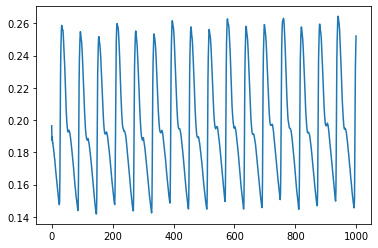

In [4]:
plt.plot(ValData[9])

### Post model

In [4]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', ReparaStd = ReparaStd, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize)
FeatGenModel = FeatGenerator(SigDim=SigDim,CompSize=CompSize, LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, CompSize=CompSize)

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
if LossType =='TCLosses':
    Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 
    SigRepModel = TCLosses(Models, DataSize, ConfigSet[ConfigName])

elif LossType =='FACLosses':
    DiscHiddenSize = ConfigSet[ConfigName]['DiscHiddenSize']
    FacDiscModel = FacDiscriminator(LatDim, DiscHiddenSize)
    Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel, FacDiscModel] 
    SigRepModel = FACLosses(Models, ConfigSet[ConfigName])


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

## The model for evaluation
RecOut = ReconModel(FeatGenModel.output)
GenModel = Model(FeatGenModel.input, RecOut)

## Sampling model
Zs_Out = SigRepModel.get_layer('Zs').output
SampModel = Model(EncModel.input, Zs_Out)


OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ added
kl_Loss_TC added
kl_Loss_DTC added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame (TFOpLambda)    (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 50)       11550       tf.signal.frame[0][0]            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 50)       11550       bidirectional[0][0]   

In [5]:
MaxFreq = 51
MinFreq = 1
NMiniBat = 100
SimSize = 3
MinFreqR=0.
MaxFreqR=0.05
NGen = 100
Ndata = len(ValData)
MASize = Ndata//NMiniBat
AnalData = ValData
NFCs = SigRepModel.get_layer('FCs').output.shape[-1]
NSelZ = 1
FCmuEps = 0.05

### The ratio of the max Power Spectral Density (PSD) value according to the given frequency.

(array([  185.,  4230.,  9098.,  8822.,  9638., 10768.,  9314.,  5947.,
         1863.,   135.]),
 array([0.16154048, 0.23948884, 0.31743719, 0.39538555, 0.47333391,
        0.55128227, 0.62923063, 0.70717898, 0.78512734, 0.8630757 ,
        0.94102406]),
 <BarContainer object of 10 artists>)

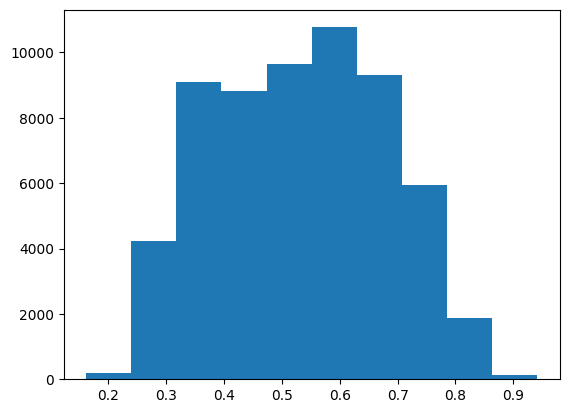

In [6]:
Data = ValData
HalfLen = Data.shape[-1]//2
FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
PSD = (FFTRes**2)/FFTRes.shape[-1]
PSD_Dist = np.max(PSD, axis=-1) / np.sum(PSD, axis=-1)
plt.hist(PSD_Dist, bins=10)

### Calculating and tracking the Conditional Mutual Information metric

In [ ]:
FC_ArangeInp = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,NFCs))

AggMetrics, SubMetrics = CondMI (ValData, SampModel, GenModel, FC_ArangeInp, SimSize = 1, NMiniBat=100, NGen=100, FcLimit=0.05, MinFreq=1, 
        MaxFreq=51, NSelZ = 1, FCmuEps = 0.05, ReparaStd=10, PredBatchSize = 10000)

  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

5/5 [==============================] - 5s 52ms/step


  0%|▏                                                                               | 1/600 [00:07<1:19:11,  7.93s/it]

I_zE_Z : 1.5926047179174743
I_zE_ZjZ : 3.0519107009868596
I_zE_ZjFm : 1.8307879011555497
I_zE_FaZj : 0.1398325811169344
I_fcE_FmZj : 0.03630917441432234
I_fcE_FaZj : 0.6453984349155591
5/5 [==============================] - 0s 54ms/step


  0%|▎                                                                                 | 2/600 [00:09<42:28,  4.26s/it]

I_zE_Z : 1.5812844893730948
I_zE_ZjZ : 3.019269346043472
I_zE_ZjFm : 1.742588577440897
I_zE_FaZj : 0.2298418299012166
I_fcE_FmZj : 0.0358513606962027
I_fcE_FaZj : 0.6270662751446051
5/5 [==============================] - 0s 51ms/step


  0%|▍                                                                                 | 3/600 [00:11<30:45,  3.09s/it]

I_zE_Z : 1.6274133309980605
I_zE_ZjZ : 3.070672976487454
I_zE_ZjFm : 1.8872114834379963
I_zE_FaZj : 0.17057447214429822
I_fcE_FmZj : 0.03590185315161649
I_fcE_FaZj : 0.6139923024678323
5/5 [==============================] - 0s 52ms/step


  1%|▌                                                                                 | 4/600 [00:13<25:12,  2.54s/it]

I_zE_Z : 1.6517855232211685
I_zE_ZjZ : 3.1561373508493915
I_zE_ZjFm : 1.7306051347986458
I_zE_FaZj : 0.1694555648630343
I_fcE_FmZj : 0.0370148507170511
I_fcE_FaZj : 0.6152562577189268
5/5 [==============================] - 0s 53ms/step


  1%|▋                                                                                 | 5/600 [00:14<22:12,  2.24s/it]

I_zE_Z : 1.6658894596119667
I_zE_ZjZ : 2.9281193513248898
I_zE_ZjFm : 1.7537385233667093
I_zE_FaZj : 0.17188608509135786
I_fcE_FmZj : 0.03540119644189376
I_fcE_FaZj : 0.6339837512541447
5/5 [==============================] - 0s 52ms/step


  1%|▊                                                                                 | 6/600 [00:16<20:25,  2.06s/it]

I_zE_Z : 1.5855208102813085
I_zE_ZjZ : 2.899046577495854
I_zE_ZjFm : 1.8601730067098385
I_zE_FaZj : 0.28749223691909703
I_fcE_FmZj : 0.0376840686717891
I_fcE_FaZj : 0.5946180395796048
5/5 [==============================] - 0s 51ms/step


  1%|▉                                                                                 | 7/600 [00:18<19:16,  1.95s/it]

I_zE_Z : 1.6373445010544285
I_zE_ZjZ : 3.086310515875037
I_zE_ZjFm : 1.8188136645935182
I_zE_FaZj : 0.2048790533112032
I_fcE_FmZj : 0.03705888128788064
I_fcE_FaZj : 0.6185137726259381
5/5 [==============================] - 0s 53ms/step


  1%|█                                                                                 | 8/600 [00:19<18:36,  1.89s/it]

I_zE_Z : 1.511133311053574
I_zE_ZjZ : 2.917066159625118
I_zE_ZjFm : 1.81175326309474
I_zE_FaZj : 0.21072236569966066
I_fcE_FmZj : 0.03559587366501077
I_fcE_FaZj : 0.6127366366928556
5/5 [==============================] - 0s 55ms/step


  2%|█▏                                                                                | 9/600 [00:21<18:03,  1.83s/it]

I_zE_Z : 1.6679680222804085
I_zE_ZjZ : 3.1726650663618003
I_zE_ZjFm : 1.8343890364960687
I_zE_FaZj : 0.13498959356809306
I_fcE_FmZj : 0.03554154186776968
I_fcE_FaZj : 0.6186989269992919
5/5 [==============================] - 0s 54ms/step


  2%|█▎                                                                               | 10/600 [00:23<17:42,  1.80s/it]

I_zE_Z : 1.6758487857796727
I_zE_ZjZ : 3.018909541451044
I_zE_ZjFm : 1.7916672881841833
I_zE_FaZj : 0.20734952435025142
I_fcE_FmZj : 0.036723275135724646
I_fcE_FaZj : 0.626462671587717
5/5 [==============================] - 0s 51ms/step


  2%|█▍                                                                               | 11/600 [00:25<17:27,  1.78s/it]

I_zE_Z : 1.5514815238258257
I_zE_ZjZ : 2.9591075877890334
I_zE_ZjFm : 1.8908729046687733
I_zE_FaZj : 0.16117171696040483
I_fcE_FmZj : 0.035107629018853254
I_fcE_FaZj : 0.6454536687499266
5/5 [==============================] - 0s 52ms/step


  2%|█▌                                                                               | 12/600 [00:26<17:17,  1.76s/it]

I_zE_Z : 1.5281272990973576
I_zE_ZjZ : 2.982803110749809
I_zE_ZjFm : 1.8681817307776811
I_zE_FaZj : 0.15808927316985813
I_fcE_FmZj : 0.0355705129237631
I_fcE_FaZj : 0.6230819127552415
5/5 [==============================] - 0s 51ms/step


  2%|█▊                                                                               | 13/600 [00:28<17:13,  1.76s/it]

I_zE_Z : 1.758474014388797
I_zE_ZjZ : 3.203202239996094
I_zE_ZjFm : 1.7506611453830891
I_zE_FaZj : 0.1868226214167273
I_fcE_FmZj : 0.03567018988058307
I_fcE_FaZj : 0.6136316092740352
5/5 [==============================] - 0s 55ms/step


  2%|█▉                                                                               | 14/600 [00:30<17:07,  1.75s/it]

I_zE_Z : 1.6799496552198705
I_zE_ZjZ : 3.064360357407711
I_zE_ZjFm : 1.804958106128467
I_zE_FaZj : 0.1605615068580867
I_fcE_FmZj : 0.03671549841903559
I_fcE_FaZj : 0.6112655043997934
5/5 [==============================] - 0s 52ms/step


  2%|██                                                                               | 15/600 [00:31<16:53,  1.73s/it]

I_zE_Z : 1.620579442178346
I_zE_ZjZ : 3.0949030794077395
I_zE_ZjFm : 1.8153104444089387
I_zE_FaZj : 0.13966774130943338
I_fcE_FmZj : 0.0357248433599103
I_fcE_FaZj : 0.629083204218644
5/5 [==============================] - 0s 54ms/step


  3%|██▏                                                                              | 16/600 [00:33<16:47,  1.72s/it]

I_zE_Z : 1.5304824962309231
I_zE_ZjZ : 2.9219221808164058
I_zE_ZjFm : 1.8751536811430887
I_zE_FaZj : 0.11593557431164539
I_fcE_FmZj : 0.03507792195229207
I_fcE_FaZj : 0.6282226045706584
5/5 [==============================] - 0s 52ms/step


  3%|██▎                                                                              | 17/600 [00:35<16:40,  1.72s/it]

I_zE_Z : 1.6209754827802856
I_zE_ZjZ : 3.0340648321070613
I_zE_ZjFm : 1.6825509621657404
I_zE_FaZj : 0.10776923088254095
I_fcE_FmZj : 0.03627597831102498
I_fcE_FaZj : 0.6179473834186318
5/5 [==============================] - 0s 53ms/step


  3%|██▍                                                                              | 18/600 [00:37<16:36,  1.71s/it]

I_zE_Z : 1.621273992508967
I_zE_ZjZ : 3.0146889762007323
I_zE_ZjFm : 1.7463569575544986
I_zE_FaZj : 0.16525035008040467
I_fcE_FmZj : 0.03574907061291782
I_fcE_FaZj : 0.6188112088215506
5/5 [==============================] - 0s 58ms/step


  3%|██▌                                                                              | 19/600 [00:38<16:35,  1.71s/it]

I_zE_Z : 1.5377478577812531
I_zE_ZjZ : 2.8966590838213135
I_zE_ZjFm : 1.824554549994595
I_zE_FaZj : 0.188587601765137
I_fcE_FmZj : 0.03643061444764534
I_fcE_FaZj : 0.6279073343239484
5/5 [==============================] - 0s 52ms/step


  3%|██▋                                                                              | 20/600 [00:40<16:35,  1.72s/it]

I_zE_Z : 1.5987634790296605
I_zE_ZjZ : 3.0397762193126154
I_zE_ZjFm : 1.82778817698215
I_zE_FaZj : 0.1014762522106032
I_fcE_FmZj : 0.036265956314103266
I_fcE_FaZj : 0.6049145400006176
5/5 [==============================] - 0s 52ms/step


  4%|██▊                                                                              | 21/600 [00:42<16:29,  1.71s/it]

I_zE_Z : 1.5313770382150675
I_zE_ZjZ : 2.823938603061704
I_zE_ZjFm : 1.8006482135147144
I_zE_FaZj : 0.14554735311893224
I_fcE_FmZj : 0.03564667378294547
I_fcE_FaZj : 0.6231789989171079
5/5 [==============================] - 0s 53ms/step


  4%|██▉                                                                              | 22/600 [00:43<16:25,  1.70s/it]

I_zE_Z : 1.5347941412881243
I_zE_ZjZ : 3.1685336605586407
I_zE_ZjFm : 1.7725757531875481
I_zE_FaZj : 0.16272695525445485
I_fcE_FmZj : 0.036059557706828775
I_fcE_FaZj : 0.6208751253326693
5/5 [==============================] - 0s 57ms/step


  4%|███                                                                              | 23/600 [00:45<16:32,  1.72s/it]

I_zE_Z : 1.612941777761436
I_zE_ZjZ : 3.0951562180956698
I_zE_ZjFm : 1.694138346426718
I_zE_FaZj : 0.17512430594219397
I_fcE_FmZj : 0.035281292258382106
I_fcE_FaZj : 0.6312725434809805
5/5 [==============================] - 0s 51ms/step


  4%|███▏                                                                             | 24/600 [00:47<16:36,  1.73s/it]

I_zE_Z : 1.6324757073679579
I_zE_ZjZ : 2.984656462134205
I_zE_ZjFm : 1.7569424081362695
I_zE_FaZj : 0.19376089687081147
I_fcE_FmZj : 0.03506085719095235
I_fcE_FaZj : 0.6036232502056256
5/5 [==============================] - 0s 54ms/step


  4%|███▍                                                                             | 25/600 [00:49<16:37,  1.73s/it]

I_zE_Z : 1.5322523999925761
I_zE_ZjZ : 3.0489558118827182
I_zE_ZjFm : 1.821921282412331
I_zE_FaZj : 0.22323018675178022
I_fcE_FmZj : 0.036226193726524684
I_fcE_FaZj : 0.6233264641040492
5/5 [==============================] - 0s 53ms/step


  4%|███▌                                                                             | 26/600 [00:50<16:36,  1.74s/it]

I_zE_Z : 1.5045100359116026
I_zE_ZjZ : 2.8439011421684666
I_zE_ZjFm : 1.8261291843245033
I_zE_FaZj : 0.13150010301837625
I_fcE_FmZj : 0.03733489698410056
I_fcE_FaZj : 0.6210689836136709
5/5 [==============================] - 0s 52ms/step


  4%|███▋                                                                             | 27/600 [00:52<16:44,  1.75s/it]

I_zE_Z : 1.5686499161089547
I_zE_ZjZ : 2.9940068552144647
I_zE_ZjFm : 1.867318135506756
I_zE_FaZj : 0.21132528809315054
I_fcE_FmZj : 0.03592782518234036
I_fcE_FaZj : 0.6239503259522596
5/5 [==============================] - 0s 56ms/step


  5%|███▊                                                                             | 28/600 [00:54<16:46,  1.76s/it]

I_zE_Z : 1.5399514064079773
I_zE_ZjZ : 2.9724022738866074
I_zE_ZjFm : 1.6844475615918382
I_zE_FaZj : 0.17545716550068635
I_fcE_FmZj : 0.03531220911661632
I_fcE_FaZj : 0.6132825855149445
5/5 [==============================] - 0s 52ms/step


  5%|███▉                                                                             | 29/600 [00:56<16:32,  1.74s/it]

I_zE_Z : 1.5845961069905152
I_zE_ZjZ : 3.039119404775184
I_zE_ZjFm : 1.8911398068387222
I_zE_FaZj : 0.21809161861691925
I_fcE_FmZj : 0.03699136495341481
I_fcE_FaZj : 0.6024013126293537
5/5 [==============================] - 0s 52ms/step


  5%|████                                                                             | 30/600 [00:57<16:27,  1.73s/it]

I_zE_Z : 1.626849852811755
I_zE_ZjZ : 3.0742736655660945
I_zE_ZjFm : 1.7873496303371248
I_zE_FaZj : 0.17314875871856805
I_fcE_FmZj : 0.035044706800309994
I_fcE_FaZj : 0.6212137566723611
5/5 [==============================] - 0s 53ms/step


  5%|████▏                                                                            | 31/600 [00:59<16:25,  1.73s/it]

I_zE_Z : 1.6249918875402696
I_zE_ZjZ : 2.931108676266754
I_zE_ZjFm : 1.9078854942338852
I_zE_FaZj : 0.1678739313666596
I_fcE_FmZj : 0.03662551147730438
I_fcE_FaZj : 0.6143343543027093
5/5 [==============================] - 0s 52ms/step


  5%|████▎                                                                            | 32/600 [01:01<16:19,  1.72s/it]

I_zE_Z : 1.5535696896625344
I_zE_ZjZ : 2.684068909353591
I_zE_ZjFm : 1.817558524829263
I_zE_FaZj : 0.13060051899432865
I_fcE_FmZj : 0.03588111445450419
I_fcE_FaZj : 0.6346076990918956
5/5 [==============================] - 0s 52ms/step


  6%|████▍                                                                            | 33/600 [01:03<16:09,  1.71s/it]

I_zE_Z : 1.574643049428025
I_zE_ZjZ : 2.7885134013783692
I_zE_ZjFm : 1.8055016433531228
I_zE_FaZj : 0.20814515128347894
I_fcE_FmZj : 0.03587632485467067
I_fcE_FaZj : 0.6088351446917375
5/5 [==============================] - 0s 54ms/step


  6%|████▌                                                                            | 34/600 [01:04<16:12,  1.72s/it]

I_zE_Z : 1.6347189174129844
I_zE_ZjZ : 2.8685619340402853
I_zE_ZjFm : 1.8259701220787266
I_zE_FaZj : 0.20457384608037568
I_fcE_FmZj : 0.03732253495401848
I_fcE_FaZj : 0.6204528894194171
5/5 [==============================] - 0s 52ms/step


  6%|████▋                                                                            | 35/600 [01:06<16:08,  1.71s/it]

I_zE_Z : 1.5908463367830452
I_zE_ZjZ : 3.0105708652744636
I_zE_ZjFm : 1.8124002330996103
I_zE_FaZj : 0.1324652303907139
I_fcE_FmZj : 0.03567475267184842
I_fcE_FaZj : 0.6447751188127077
5/5 [==============================] - 0s 52ms/step


  6%|████▊                                                                            | 36/600 [01:08<16:03,  1.71s/it]

I_zE_Z : 1.619790922966953
I_zE_ZjZ : 2.9625128157802156
I_zE_ZjFm : 1.8109436288935328
I_zE_FaZj : 0.2220770445656641
I_fcE_FmZj : 0.036370591888853276
I_fcE_FaZj : 0.6356364709912399
5/5 [==============================] - 0s 54ms/step


  6%|████▉                                                                            | 37/600 [01:09<16:00,  1.71s/it]

I_zE_Z : 1.6154013589072034
I_zE_ZjZ : 3.0189470045938815
I_zE_ZjFm : 1.9122096803074704
I_zE_FaZj : 0.19205739697764856
I_fcE_FmZj : 0.0352721051357093
I_fcE_FaZj : 0.6403725525715219
5/5 [==============================] - 0s 52ms/step


  6%|█████▏                                                                           | 38/600 [01:11<16:00,  1.71s/it]

I_zE_Z : 1.604567669817948
I_zE_ZjZ : 2.93075270622443
I_zE_ZjFm : 1.7675021937626127
I_zE_FaZj : 0.1774545848250163
I_fcE_FmZj : 0.03487578890127163
I_fcE_FaZj : 0.6209239154309353
5/5 [==============================] - 0s 51ms/step


  6%|█████▎                                                                           | 39/600 [01:13<15:54,  1.70s/it]

I_zE_Z : 1.6176921336774566
I_zE_ZjZ : 2.9831606846219962
I_zE_ZjFm : 1.9498272343965533
I_zE_FaZj : 0.13272053378344656
I_fcE_FmZj : 0.036204665202785695
I_fcE_FaZj : 0.6303435881345331
5/5 [==============================] - 0s 55ms/step


  7%|█████▍                                                                           | 40/600 [01:14<15:55,  1.71s/it]

I_zE_Z : 1.690141002003366
I_zE_ZjZ : 2.927407468716387
I_zE_ZjFm : 1.8526582841720376
I_zE_FaZj : 0.17209154157712703
I_fcE_FmZj : 0.0367787829624274
I_fcE_FaZj : 0.6250811070351001
5/5 [==============================] - 0s 52ms/step


  7%|█████▌                                                                           | 41/600 [01:16<15:51,  1.70s/it]

I_zE_Z : 1.6312812346868224
I_zE_ZjZ : 2.9342794569097697
I_zE_ZjFm : 1.8272465198810215
I_zE_FaZj : 0.07710476754187726
I_fcE_FmZj : 0.036335316462332824
I_fcE_FaZj : 0.6325110889051712
5/5 [==============================] - 0s 52ms/step


  7%|█████▋                                                                           | 42/600 [01:18<15:47,  1.70s/it]

I_zE_Z : 1.6110375209522112
I_zE_ZjZ : 2.7778639210467855
I_zE_ZjFm : 1.8508371009684508
I_zE_FaZj : 0.2381836318459678
I_fcE_FmZj : 0.03530461614311971
I_fcE_FaZj : 0.6062174853822314
5/5 [==============================] - 0s 55ms/step


  7%|█████▊                                                                           | 43/600 [01:20<15:46,  1.70s/it]

I_zE_Z : 1.5781120812797405
I_zE_ZjZ : 3.1111164110729046
I_zE_ZjFm : 1.9679233661163489
I_zE_FaZj : 0.22974967283240527
I_fcE_FmZj : 0.036598312337226775
I_fcE_FaZj : 0.623684707007683
5/5 [==============================] - 0s 52ms/step


  7%|█████▉                                                                           | 44/600 [01:21<15:45,  1.70s/it]

I_zE_Z : 1.6207196593246822
I_zE_ZjZ : 3.0496176958757584
I_zE_ZjFm : 1.9412215230023357
I_zE_FaZj : 0.19454828307492925
I_fcE_FmZj : 0.03709170188989892
I_fcE_FaZj : 0.6355879908355712
5/5 [==============================] - 0s 52ms/step


  8%|██████                                                                           | 45/600 [01:23<15:42,  1.70s/it]

I_zE_Z : 1.7051812509423772
I_zE_ZjZ : 3.0512628680360603
I_zE_ZjFm : 1.8360272380620324
I_zE_FaZj : 0.1775513662673175
I_fcE_FmZj : 0.03681133099158458
I_fcE_FaZj : 0.6068811913752126
5/5 [==============================] - 0s 52ms/step


  8%|██████▏                                                                          | 46/600 [01:25<15:40,  1.70s/it]

I_zE_Z : 1.6746783796786382
I_zE_ZjZ : 2.995402594844914
I_zE_ZjFm : 1.6559963086810496
I_zE_FaZj : 0.20061986423569525
I_fcE_FmZj : 0.036136229913289755
I_fcE_FaZj : 0.6105123055569361
5/5 [==============================] - 0s 53ms/step


  8%|██████▎                                                                          | 47/600 [01:26<15:37,  1.70s/it]

I_zE_Z : 1.5703514782769747
I_zE_ZjZ : 2.9917517485301333
I_zE_ZjFm : 1.796235172417319
I_zE_FaZj : 0.21268170481033885
I_fcE_FmZj : 0.03520788294116354
I_fcE_FaZj : 0.6146778453753766
5/5 [==============================] - 0s 51ms/step


  8%|██████▍                                                                          | 48/600 [01:28<15:34,  1.69s/it]

I_zE_Z : 1.610932345585629
I_zE_ZjZ : 2.9619085994712417
I_zE_ZjFm : 1.8679554043939057
I_zE_FaZj : 0.18751526456455406
I_fcE_FmZj : 0.03476461052089795
I_fcE_FaZj : 0.6372337580868791
5/5 [==============================] - 0s 55ms/step


  8%|██████▌                                                                          | 49/600 [01:30<15:40,  1.71s/it]

I_zE_Z : 1.6986516827565377
I_zE_ZjZ : 2.9535880720387375
I_zE_ZjFm : 1.8529929834548975
I_zE_FaZj : 0.18152319914719925
I_fcE_FmZj : 0.03582744114405383
I_fcE_FaZj : 0.6227142205955003
5/5 [==============================] - 0s 52ms/step


  8%|██████▊                                                                          | 50/600 [01:31<15:37,  1.70s/it]

I_zE_Z : 1.6256301465621532
I_zE_ZjZ : 3.012599775094738
I_zE_ZjFm : 1.8223025549217804
I_zE_FaZj : 0.14634553220404745
I_fcE_FmZj : 0.03583080083052973
I_fcE_FaZj : 0.6327294285314462
5/5 [==============================] - 0s 52ms/step


  8%|██████▉                                                                          | 51/600 [01:33<15:36,  1.71s/it]

I_zE_Z : 1.664798675255698
I_zE_ZjZ : 3.1608187202668683
I_zE_ZjFm : 1.8652654336789987
I_zE_FaZj : 0.16824920443227587
I_fcE_FmZj : 0.03632187499284595
I_fcE_FaZj : 0.6244230228802913
5/5 [==============================] - 0s 52ms/step


  9%|███████                                                                          | 52/600 [01:35<15:47,  1.73s/it]

I_zE_Z : 1.6423653500088229
I_zE_ZjZ : 3.0927307577716165
I_zE_ZjFm : 1.7123666264933033
I_zE_FaZj : 0.19804757822551886
I_fcE_FmZj : 0.03548514883495955
I_fcE_FaZj : 0.6171554841842966
5/5 [==============================] - 0s 61ms/step


  9%|███████▏                                                                         | 53/600 [01:37<15:55,  1.75s/it]

I_zE_Z : 1.7240339697628384
I_zE_ZjZ : 3.080521819516494
I_zE_ZjFm : 1.803779840529326
I_zE_FaZj : 0.19858847220836523
I_fcE_FmZj : 0.035878147530434196
I_fcE_FaZj : 0.6330159159872403
5/5 [==============================] - 0s 55ms/step


  9%|███████▎                                                                         | 54/600 [01:38<15:51,  1.74s/it]

I_zE_Z : 1.561214327828695
I_zE_ZjZ : 3.0677452710948665
I_zE_ZjFm : 1.8545715437363128
I_zE_FaZj : 0.1536486396233096
I_fcE_FmZj : 0.035289008978908125
I_fcE_FaZj : 0.6032961562882967
5/5 [==============================] - 0s 55ms/step


  9%|███████▍                                                                         | 55/600 [01:40<15:50,  1.74s/it]

I_zE_Z : 1.5265704262473319
I_zE_ZjZ : 2.876217786848801
I_zE_ZjFm : 1.8752831085915265
I_zE_FaZj : 0.18386160841405377
I_fcE_FmZj : 0.03574335655866973
I_fcE_FaZj : 0.6303205746012219
5/5 [==============================] - 0s 52ms/step


  9%|███████▌                                                                         | 56/600 [01:42<15:45,  1.74s/it]

I_zE_Z : 1.583722769709859
I_zE_ZjZ : 3.0040205614692814
I_zE_ZjFm : 1.6692559739782558
I_zE_FaZj : 0.12719376363437362
I_fcE_FmZj : 0.03585301510490972
I_fcE_FaZj : 0.6318366897624171
5/5 [==============================] - 0s 57ms/step


 10%|███████▋                                                                         | 57/600 [01:44<15:45,  1.74s/it]

I_zE_Z : 1.5388840504180579
I_zE_ZjZ : 2.9937372689554937
I_zE_ZjFm : 1.7401867098216166
I_zE_FaZj : 0.13490704100804615
I_fcE_FmZj : 0.03570082215426018
I_fcE_FaZj : 0.6135999500689459
5/5 [==============================] - 0s 54ms/step


 10%|███████▊                                                                         | 58/600 [01:45<15:41,  1.74s/it]

I_zE_Z : 1.604041063509511
I_zE_ZjZ : 2.784183766614478
I_zE_ZjFm : 1.8222941862949131
I_zE_FaZj : 0.13721907857812637
I_fcE_FmZj : 0.03630035904049466
I_fcE_FaZj : 0.6155652073304904
5/5 [==============================] - 0s 51ms/step


 10%|███████▉                                                                         | 59/600 [01:47<15:36,  1.73s/it]

I_zE_Z : 1.5687422361490602
I_zE_ZjZ : 3.229601146139957
I_zE_ZjFm : 1.715364383761804
I_zE_FaZj : 0.32188757500799825
I_fcE_FmZj : 0.03556284453334452
I_fcE_FaZj : 0.6019310418530341
5/5 [==============================] - 0s 52ms/step


 10%|████████                                                                         | 60/600 [01:49<15:33,  1.73s/it]

I_zE_Z : 1.6939254787795632
I_zE_ZjZ : 3.012636816669911
I_zE_ZjFm : 1.85937371621531
I_zE_FaZj : 0.17715583153534467
I_fcE_FmZj : 0.036795264774730795
I_fcE_FaZj : 0.624129924705628
5/5 [==============================] - 0s 51ms/step


 10%|████████▏                                                                        | 61/600 [01:51<15:28,  1.72s/it]

I_zE_Z : 1.621270193257687
I_zE_ZjZ : 2.8178881823106794
I_zE_ZjFm : 1.7937879971846626
I_zE_FaZj : 0.22383358641338347
I_fcE_FmZj : 0.03577862695758983
I_fcE_FaZj : 0.6245762901451272
5/5 [==============================] - 0s 53ms/step


 10%|████████▎                                                                        | 62/600 [01:52<15:26,  1.72s/it]

I_zE_Z : 1.5106707262914378
I_zE_ZjZ : 2.6571555292574787
I_zE_ZjFm : 1.8176350146777656
I_zE_FaZj : 0.13206893284304186
I_fcE_FmZj : 0.036433881152366614
I_fcE_FaZj : 0.6109213723116657
5/5 [==============================] - 0s 52ms/step


 10%|████████▌                                                                        | 63/600 [01:54<15:22,  1.72s/it]

I_zE_Z : 1.6118052891007373
I_zE_ZjZ : 2.8588308223414303
I_zE_ZjFm : 1.8129081025714813
I_zE_FaZj : 0.12851508502536865
I_fcE_FmZj : 0.03655420718641555
I_fcE_FaZj : 0.6389118804782749
5/5 [==============================] - 0s 55ms/step


 11%|████████▋                                                                        | 64/600 [01:56<15:25,  1.73s/it]

I_zE_Z : 1.562865472215406
I_zE_ZjZ : 2.807104938002368
I_zE_ZjFm : 1.8132359069029789
I_zE_FaZj : 0.22829741803933118
I_fcE_FmZj : 0.037408750306735905
I_fcE_FaZj : 0.6315000073598894
5/5 [==============================] - 0s 57ms/step


 11%|████████▊                                                                        | 65/600 [01:57<15:28,  1.73s/it]

I_zE_Z : 1.6320798191662544
I_zE_ZjZ : 3.0357786668418276
I_zE_ZjFm : 1.7878327662066125
I_zE_FaZj : 0.15290082991798937
I_fcE_FmZj : 0.035753386213476714
I_fcE_FaZj : 0.5998897188538942
5/5 [==============================] - 0s 52ms/step


 11%|████████▉                                                                        | 66/600 [01:59<15:19,  1.72s/it]

I_zE_Z : 1.6132891433475398
I_zE_ZjZ : 2.929984226542561
I_zE_ZjFm : 1.7968140409394795
I_zE_FaZj : 0.16861740777358872
I_fcE_FmZj : 0.036504873912526145
I_fcE_FaZj : 0.6315603751921324
5/5 [==============================] - 0s 53ms/step


 11%|█████████                                                                        | 67/600 [02:01<15:18,  1.72s/it]

I_zE_Z : 1.6223174467364654
I_zE_ZjZ : 3.020275863901389
I_zE_ZjFm : 1.8150409615888479
I_zE_FaZj : 0.16078815645601646
I_fcE_FmZj : 0.03617914822455897
I_fcE_FaZj : 0.6141869748279202
5/5 [==============================] - 0s 51ms/step


 11%|█████████▏                                                                       | 68/600 [02:03<15:14,  1.72s/it]

I_zE_Z : 1.5874683272456347
I_zE_ZjZ : 2.9142273698260635
I_zE_ZjFm : 1.7951732354335546
I_zE_FaZj : 0.17696050961817109
I_fcE_FmZj : 0.03528685385307134
I_fcE_FaZj : 0.6225352793470691
5/5 [==============================] - 0s 52ms/step


 12%|█████████▎                                                                       | 69/600 [02:04<15:09,  1.71s/it]

I_zE_Z : 1.546677678558331
I_zE_ZjZ : 2.851929284527106
I_zE_ZjFm : 1.7604974866620853
I_zE_FaZj : 0.19746257858151423
I_fcE_FmZj : 0.035328496298110336
I_fcE_FaZj : 0.600573999154578
5/5 [==============================] - 0s 51ms/step


 12%|█████████▍                                                                       | 70/600 [02:06<15:04,  1.71s/it]

I_zE_Z : 1.5756434017699201
I_zE_ZjZ : 3.017746702813369
I_zE_ZjFm : 1.7370605908218761
I_zE_FaZj : 0.23973025218642063
I_fcE_FmZj : 0.03605105641004533
I_fcE_FaZj : 0.610677079570968
5/5 [==============================] - 0s 52ms/step


 12%|█████████▌                                                                       | 71/600 [02:08<15:01,  1.70s/it]

I_zE_Z : 1.6362470135919858
I_zE_ZjZ : 3.0016628096552322
I_zE_ZjFm : 1.822425536477297
I_zE_FaZj : 0.18428623339312453
I_fcE_FmZj : 0.035401359219836476
I_fcE_FaZj : 0.6111284540478535
5/5 [==============================] - 0s 52ms/step


 12%|█████████▋                                                                       | 72/600 [02:09<14:58,  1.70s/it]

I_zE_Z : 1.5423608818273349
I_zE_ZjZ : 2.8445977615786675
I_zE_ZjFm : 1.8328261880401708
I_zE_FaZj : 0.24873564216188482
I_fcE_FmZj : 0.03608591441056875
I_fcE_FaZj : 0.6200837685305419
5/5 [==============================] - 0s 53ms/step


 12%|█████████▊                                                                       | 73/600 [02:11<14:54,  1.70s/it]

I_zE_Z : 1.5734155770708012
I_zE_ZjZ : 3.020673920654165
I_zE_ZjFm : 1.7762638958280943
I_zE_FaZj : 0.19498337116775527
I_fcE_FmZj : 0.036766520324908826
I_fcE_FaZj : 0.6369122097728929
5/5 [==============================] - 0s 54ms/step


 12%|█████████▉                                                                       | 74/600 [02:13<14:53,  1.70s/it]

I_zE_Z : 1.5567250211393877
I_zE_ZjZ : 3.0433413016946163
I_zE_ZjFm : 1.7748969499679899
I_zE_FaZj : 0.13647221186780092
I_fcE_FmZj : 0.03396995484222849
I_fcE_FaZj : 0.6264757711805411
5/5 [==============================] - 0s 51ms/step


 12%|██████████▏                                                                      | 75/600 [02:14<14:49,  1.69s/it]

I_zE_Z : 1.610949790026606
I_zE_ZjZ : 3.133255901861325
I_zE_ZjFm : 1.7917593130123017
I_zE_FaZj : 0.1620381858644112
I_fcE_FmZj : 0.03546779871583572
I_fcE_FaZj : 0.621893571238647
5/5 [==============================] - 0s 53ms/step


 13%|██████████▎                                                                      | 76/600 [02:16<14:48,  1.70s/it]

I_zE_Z : 1.6944162927232338
I_zE_ZjZ : 3.0760756721795706
I_zE_ZjFm : 1.795657357723494
I_zE_FaZj : 0.18807823628095605
I_fcE_FmZj : 0.03712702245879185
I_fcE_FaZj : 0.6191893777326067
5/5 [==============================] - 0s 54ms/step


 13%|██████████▍                                                                      | 77/600 [02:18<14:47,  1.70s/it]

I_zE_Z : 1.6107401591316874
I_zE_ZjZ : 2.962316599383748
I_zE_ZjFm : 1.7160715750963562
I_zE_FaZj : 0.20294209682667622
I_fcE_FmZj : 0.03596839842851587
I_fcE_FaZj : 0.60484228395221
5/5 [==============================] - 0s 51ms/step


 13%|██████████▌                                                                      | 78/600 [02:20<14:47,  1.70s/it]

I_zE_Z : 1.62409213085501
I_zE_ZjZ : 2.9211530893243283
I_zE_ZjFm : 1.8449839748150263
I_zE_FaZj : 0.16942231040850458
I_fcE_FmZj : 0.03521510372123938
I_fcE_FaZj : 0.610613250944791
5/5 [==============================] - 0s 51ms/step


 13%|██████████▋                                                                      | 79/600 [02:21<14:41,  1.69s/it]

I_zE_Z : 1.481847696077314
I_zE_ZjZ : 2.6752948754696733
I_zE_ZjFm : 1.7362412318692675
I_zE_FaZj : 0.22015467427281937
I_fcE_FmZj : 0.03590544198255037
I_fcE_FaZj : 0.6294092702752313
5/5 [==============================] - 0s 51ms/step


 13%|██████████▊                                                                      | 80/600 [02:23<14:45,  1.70s/it]

I_zE_Z : 1.5658585407801373
I_zE_ZjZ : 3.0000881465116573
I_zE_ZjFm : 1.8212540137065767
I_zE_FaZj : 0.2434023784117395
I_fcE_FmZj : 0.036539044808825125
I_fcE_FaZj : 0.6169295115410619
5/5 [==============================] - 0s 52ms/step


 14%|██████████▉                                                                      | 81/600 [02:25<14:46,  1.71s/it]

I_zE_Z : 1.6760543886295458
I_zE_ZjZ : 3.250089394763809
I_zE_ZjFm : 1.7498755029580808
I_zE_FaZj : 0.22705448645439752
I_fcE_FmZj : 0.0370094610379793
I_fcE_FaZj : 0.6010805388649544
5/5 [==============================] - 0s 52ms/step


 14%|███████████                                                                      | 82/600 [02:26<14:53,  1.72s/it]

I_zE_Z : 1.6195821539309434
I_zE_ZjZ : 3.022543695015197
I_zE_ZjFm : 1.766898569911899
I_zE_FaZj : 0.10712989692579418
I_fcE_FmZj : 0.03578258876436592
I_fcE_FaZj : 0.6223946968786112
5/5 [==============================] - 0s 52ms/step


 14%|███████████▏                                                                     | 83/600 [02:28<14:52,  1.73s/it]

I_zE_Z : 1.5403978542731023
I_zE_ZjZ : 3.178326461258053
I_zE_ZjFm : 1.9248517216823462
I_zE_FaZj : 0.17931616387900745
I_fcE_FmZj : 0.03629281244159664
I_fcE_FaZj : 0.613011903610135
5/5 [==============================] - 0s 63ms/step


 14%|███████████▎                                                                     | 84/600 [02:30<15:06,  1.76s/it]

I_zE_Z : 1.54101550773559
I_zE_ZjZ : 2.9590710284964272
I_zE_ZjFm : 1.752798625277579
I_zE_FaZj : 0.20228399361911006
I_fcE_FmZj : 0.03557058380113555
I_fcE_FaZj : 0.6190784334135859
5/5 [==============================] - 0s 60ms/step


 14%|███████████▍                                                                     | 85/600 [02:32<15:04,  1.76s/it]

I_zE_Z : 1.6706786464086159
I_zE_ZjZ : 3.2221255922499483
I_zE_ZjFm : 1.8422171463149937
I_zE_FaZj : 0.13329197105202728
I_fcE_FmZj : 0.03721313066162607
I_fcE_FaZj : 0.6052933089960763
5/5 [==============================] - 0s 51ms/step


 14%|███████████▌                                                                     | 86/600 [02:34<15:06,  1.76s/it]

I_zE_Z : 1.575127947581995
I_zE_ZjZ : 3.0712354054726414
I_zE_ZjFm : 1.8154273723523868
I_zE_FaZj : 0.17063496371092954
I_fcE_FmZj : 0.03635579787899608
I_fcE_FaZj : 0.5969422373955473
5/5 [==============================] - 0s 57ms/step


 14%|███████████▋                                                                     | 87/600 [02:35<15:10,  1.77s/it]

I_zE_Z : 1.589140316537259
I_zE_ZjZ : 3.0612024417734522
I_zE_ZjFm : 1.7562469275638046
I_zE_FaZj : 0.12038735986968689
I_fcE_FmZj : 0.03542308401044926
I_fcE_FaZj : 0.6095091585775865
5/5 [==============================] - 0s 58ms/step


 15%|███████████▉                                                                     | 88/600 [02:37<15:09,  1.78s/it]

I_zE_Z : 1.5928271382488282
I_zE_ZjZ : 3.045147881874974
I_zE_ZjFm : 1.8267808479958052
I_zE_FaZj : 0.10238707093060506
I_fcE_FmZj : 0.03535425855137558
I_fcE_FaZj : 0.6309818170699361
5/5 [==============================] - 0s 60ms/step


 15%|████████████                                                                     | 89/600 [02:39<15:15,  1.79s/it]

I_zE_Z : 1.6363608402195169
I_zE_ZjZ : 3.069191268036204
I_zE_ZjFm : 1.8250611484558215
I_zE_FaZj : 0.16213183484424984
I_fcE_FmZj : 0.03673333383061174
I_fcE_FaZj : 0.6162821841646218
5/5 [==============================] - 0s 57ms/step


 15%|████████████▏                                                                    | 90/600 [02:41<15:17,  1.80s/it]

I_zE_Z : 1.6146678703884672
I_zE_ZjZ : 2.944471368917608
I_zE_ZjFm : 1.832302610399121
I_zE_FaZj : 0.18849376384171296
I_fcE_FmZj : 0.03636202575534432
I_fcE_FaZj : 0.6115677786657558
5/5 [==============================] - 0s 53ms/step


 15%|████████████▎                                                                    | 91/600 [02:43<15:08,  1.79s/it]

I_zE_Z : 1.6133384674842746
I_zE_ZjZ : 2.956557148711992
I_zE_ZjFm : 1.7824571572672219
I_zE_FaZj : 0.13451766663927278
I_fcE_FmZj : 0.03544738918892542
I_fcE_FaZj : 0.6277819014891433
5/5 [==============================] - 0s 53ms/step


 15%|████████████▍                                                                    | 92/600 [02:44<14:52,  1.76s/it]

I_zE_Z : 1.6180994900646015
I_zE_ZjZ : 2.9423492699526155
I_zE_ZjFm : 1.7818481097159895
I_zE_FaZj : 0.175576390081236
I_fcE_FmZj : 0.03566159932412865
I_fcE_FaZj : 0.6157336874382328
5/5 [==============================] - 0s 55ms/step


 16%|████████████▌                                                                    | 93/600 [02:46<14:41,  1.74s/it]

I_zE_Z : 1.7142739866391437
I_zE_ZjZ : 3.1013203842763626
I_zE_ZjFm : 1.78407467158042
I_zE_FaZj : 0.1388133309050942
I_fcE_FmZj : 0.03679942083905462
I_fcE_FaZj : 0.6190384228925199
5/5 [==============================] - 0s 52ms/step


 16%|████████████▋                                                                    | 94/600 [02:48<14:34,  1.73s/it]

I_zE_Z : 1.5633363621176044
I_zE_ZjZ : 3.09689836921736
I_zE_ZjFm : 1.7727890816659329
I_zE_FaZj : 0.12342733925654434
I_fcE_FmZj : 0.036368012304001385
I_fcE_FaZj : 0.6253061170148965
5/5 [==============================] - 0s 52ms/step


 16%|████████████▊                                                                    | 95/600 [02:49<14:27,  1.72s/it]

I_zE_Z : 1.6131979663751073
I_zE_ZjZ : 3.0155553214887347
I_zE_ZjFm : 1.763782013980286
I_zE_FaZj : 0.18292084580634438
I_fcE_FmZj : 0.034503249925337987
I_fcE_FaZj : 0.6170244016144347
5/5 [==============================] - 0s 54ms/step


 16%|████████████▉                                                                    | 96/600 [02:51<14:20,  1.71s/it]

I_zE_Z : 1.6092905286701977
I_zE_ZjZ : 2.9431298451946737
I_zE_ZjFm : 1.692977460786683
I_zE_FaZj : 0.2354802863449673
I_fcE_FmZj : 0.03696868788615171
I_fcE_FaZj : 0.6097320222233702
5/5 [==============================] - 0s 52ms/step


 16%|█████████████                                                                    | 97/600 [02:53<14:16,  1.70s/it]

I_zE_Z : 1.5280984381112526
I_zE_ZjZ : 3.0753016329002674
I_zE_ZjFm : 1.8825689188768677
I_zE_FaZj : 0.21329302523465724
I_fcE_FmZj : 0.036355553572345885
I_fcE_FaZj : 0.611882305327837
5/5 [==============================] - 0s 53ms/step


 16%|█████████████▏                                                                   | 98/600 [02:54<14:13,  1.70s/it]

I_zE_Z : 1.5966927837470697
I_zE_ZjZ : 2.9620605986608775
I_zE_ZjFm : 1.8308125479543558
I_zE_FaZj : 0.1887502210985975
I_fcE_FmZj : 0.036155492088024474
I_fcE_FaZj : 0.6282071533155614
5/5 [==============================] - 0s 51ms/step


 16%|█████████████▎                                                                   | 99/600 [02:56<14:10,  1.70s/it]

I_zE_Z : 1.6358737694646095
I_zE_ZjZ : 2.7670433889941797
I_zE_ZjFm : 1.8095650858430374
I_zE_FaZj : 0.16881222172710092
I_fcE_FmZj : 0.03617126608019598
I_fcE_FaZj : 0.6318780134410358
5/5 [==============================] - 0s 52ms/step


 17%|█████████████▎                                                                  | 100/600 [02:58<14:09,  1.70s/it]

I_zE_Z : 1.5543612941521987
I_zE_ZjZ : 2.8621864537901605
I_zE_ZjFm : 1.83890324885937
I_zE_FaZj : 0.34348203293163776
I_fcE_FmZj : 0.036151586316678246
I_fcE_FaZj : 0.623043927307784
5/5 [==============================] - 0s 52ms/step


 17%|█████████████▍                                                                  | 101/600 [02:59<14:06,  1.70s/it]

I_zE_Z : 1.5607742589351306
I_zE_ZjZ : 3.0203666635237125
I_zE_ZjFm : 1.8473760484954385
I_zE_FaZj : 0.18987590082824837
I_fcE_FmZj : 0.035068099203068734
I_fcE_FaZj : 0.6244182227173578
5/5 [==============================] - 0s 51ms/step


 17%|█████████████▌                                                                  | 102/600 [03:01<14:02,  1.69s/it]

I_zE_Z : 1.605472007599833
I_zE_ZjZ : 3.2565365313652865
I_zE_ZjFm : 1.8212175792924856
I_zE_FaZj : 0.14734150049864184
I_fcE_FmZj : 0.03706831108820761
I_fcE_FaZj : 0.6048250199712428
5/5 [==============================] - 0s 52ms/step


 17%|█████████████▋                                                                  | 103/600 [03:03<14:02,  1.70s/it]

I_zE_Z : 1.6909280722695161
I_zE_ZjZ : 3.2789737459474804
I_zE_ZjFm : 1.771505050729771
I_zE_FaZj : 0.16749598609180416
I_fcE_FmZj : 0.03719259825201725
I_fcE_FaZj : 0.6369252954112143
5/5 [==============================] - 0s 53ms/step


 17%|█████████████▊                                                                  | 104/600 [03:05<14:05,  1.71s/it]

I_zE_Z : 1.5797131600077992
I_zE_ZjZ : 2.961992444848517
I_zE_ZjFm : 1.7335938576584164
I_zE_FaZj : 0.18075874666945083
I_fcE_FmZj : 0.03579056926810781
I_fcE_FaZj : 0.6096820428531788
5/5 [==============================] - 0s 52ms/step


 18%|██████████████                                                                  | 105/600 [03:06<14:04,  1.71s/it]

I_zE_Z : 1.6072219900878637
I_zE_ZjZ : 3.361145798493548
I_zE_ZjFm : 1.7651701513612403
I_zE_FaZj : 0.12064862299892969
I_fcE_FmZj : 0.035483304521031156
I_fcE_FaZj : 0.6321728546959017
5/5 [==============================] - 0s 53ms/step


 18%|██████████████▏                                                                 | 106/600 [03:08<14:01,  1.70s/it]

I_zE_Z : 1.5771341376394192
I_zE_ZjZ : 3.0860811876013723
I_zE_ZjFm : 1.8159381321770456
I_zE_FaZj : 0.12546256991828816
I_fcE_FmZj : 0.03668214719615074
I_fcE_FaZj : 0.6285685506522204
5/5 [==============================] - 0s 52ms/step


 18%|██████████████▎                                                                 | 107/600 [03:10<14:00,  1.70s/it]

I_zE_Z : 1.612549926836983
I_zE_ZjZ : 3.240370610527523
I_zE_ZjFm : 1.8222719166898944
I_zE_FaZj : 0.1688249148685202
I_fcE_FmZj : 0.036581171431261716
I_fcE_FaZj : 0.6099824823565128
5/5 [==============================] - 0s 56ms/step


 18%|██████████████▍                                                                 | 108/600 [03:11<14:08,  1.73s/it]

I_zE_Z : 1.6564650309752305
I_zE_ZjZ : 3.1839907168561625
I_zE_ZjFm : 1.8326770030678956
I_zE_FaZj : 0.23317778582117032
I_fcE_FmZj : 0.034613222981989426
I_fcE_FaZj : 0.6149864551771268
5/5 [==============================] - 0s 52ms/step


 18%|██████████████▌                                                                 | 109/600 [03:13<14:11,  1.73s/it]

I_zE_Z : 1.5806393963167633
I_zE_ZjZ : 3.0166494927940244
I_zE_ZjFm : 1.7233775961149072
I_zE_FaZj : 0.19055198765956785
I_fcE_FmZj : 0.037341322477909146
I_fcE_FaZj : 0.6119543971083472
5/5 [==============================] - 0s 53ms/step


 18%|██████████████▋                                                                 | 110/600 [03:15<14:16,  1.75s/it]

I_zE_Z : 1.5398435496368108
I_zE_ZjZ : 2.8634913014495065
I_zE_ZjFm : 1.76212986670149
I_zE_FaZj : 0.13307368772041586
I_fcE_FmZj : 0.03476935077019878
I_fcE_FaZj : 0.5949560549554374
5/5 [==============================] - 0s 57ms/step


 18%|██████████████▊                                                                 | 111/600 [03:17<14:19,  1.76s/it]

I_zE_Z : 1.5743102358897842
I_zE_ZjZ : 2.966684425486851
I_zE_ZjFm : 1.7576517768754167
I_zE_FaZj : 0.21929059839310316
I_fcE_FmZj : 0.034424494560674944
I_fcE_FaZj : 0.6271161067184687
5/5 [==============================] - 0s 63ms/step


 19%|██████████████▉                                                                 | 112/600 [03:19<14:20,  1.76s/it]

I_zE_Z : 1.584043083690501
I_zE_ZjZ : 2.9764990338014314
I_zE_ZjFm : 1.7657168102780714
I_zE_FaZj : 0.13382204519673788
I_fcE_FmZj : 0.035814271289786793
I_fcE_FaZj : 0.6191758512660438
5/5 [==============================] - 0s 52ms/step


 19%|███████████████                                                                 | 113/600 [03:20<14:07,  1.74s/it]

I_zE_Z : 1.6722622298596261
I_zE_ZjZ : 3.0127676009239575
I_zE_ZjFm : 1.7483875444915922
I_zE_FaZj : 0.1827166942499126
I_fcE_FmZj : 0.03643207244391941
I_fcE_FaZj : 0.6065581562902083
5/5 [==============================] - 0s 53ms/step


 19%|███████████████▏                                                                | 114/600 [03:22<13:58,  1.72s/it]

I_zE_Z : 1.5659069919929534
I_zE_ZjZ : 3.019981549967401
I_zE_ZjFm : 1.7851392348956228
I_zE_FaZj : 0.10888259323103573
I_fcE_FmZj : 0.036081564882367995
I_fcE_FaZj : 0.6300676067880299
5/5 [==============================] - 0s 52ms/step


 19%|███████████████▎                                                                | 115/600 [03:24<13:51,  1.72s/it]

I_zE_Z : 1.5686186138076434
I_zE_ZjZ : 2.852154237683193
I_zE_ZjFm : 1.8630795023160334
I_zE_FaZj : 0.16240618129116002
I_fcE_FmZj : 0.035997329161345945
I_fcE_FaZj : 0.6212945838549588
5/5 [==============================] - 0s 52ms/step


 19%|███████████████▍                                                                | 116/600 [03:25<13:47,  1.71s/it]

I_zE_Z : 1.6371991665775034
I_zE_ZjZ : 3.0215303441433274
I_zE_ZjFm : 1.8759010674481034
I_zE_FaZj : 0.12486458687716719
I_fcE_FmZj : 0.034919318784463894
I_fcE_FaZj : 0.6291862627567685
5/5 [==============================] - 0s 53ms/step


 20%|███████████████▌                                                                | 117/600 [03:27<13:43,  1.70s/it]

I_zE_Z : 1.6278627018055698
I_zE_ZjZ : 3.0322579798182328
I_zE_ZjFm : 1.7671344208834838
I_zE_FaZj : 0.17075848700887422
I_fcE_FmZj : 0.03525207026708261
I_fcE_FaZj : 0.6048556778814079
5/5 [==============================] - 0s 51ms/step


 20%|███████████████▋                                                                | 118/600 [03:29<13:40,  1.70s/it]

I_zE_Z : 1.5826823141833375
I_zE_ZjZ : 2.912227387124932
I_zE_ZjFm : 1.7871629571279768
I_zE_FaZj : 0.21565158551323996
I_fcE_FmZj : 0.036124602410565594
I_fcE_FaZj : 0.6093782876957459
5/5 [==============================] - 0s 54ms/step


 20%|███████████████▊                                                                | 119/600 [03:30<13:36,  1.70s/it]

I_zE_Z : 1.5933563402393696
I_zE_ZjZ : 2.883626987096568
I_zE_ZjFm : 1.7510248398232833
I_zE_FaZj : 0.18259414954884703
I_fcE_FmZj : 0.03573099881272862
I_fcE_FaZj : 0.6038733804601747
5/5 [==============================] - 0s 54ms/step


 20%|████████████████                                                                | 120/600 [03:32<13:34,  1.70s/it]

I_zE_Z : 1.5946970623428647
I_zE_ZjZ : 2.8316817863663477
I_zE_ZjFm : 1.7945509233554637
I_zE_FaZj : 0.21501964659358794
I_fcE_FmZj : 0.03710574379590029
I_fcE_FaZj : 0.6146552647050545
5/5 [==============================] - 0s 51ms/step


 20%|████████████████▏                                                               | 121/600 [03:34<13:34,  1.70s/it]

I_zE_Z : 1.5796356945218162
I_zE_ZjZ : 3.225714632343426
I_zE_ZjFm : 1.7951246869300763
I_zE_FaZj : 0.18369855705922444
I_fcE_FmZj : 0.03612854639094725
I_fcE_FaZj : 0.6285834821784543
5/5 [==============================] - 0s 52ms/step


 20%|████████████████▎                                                               | 122/600 [03:35<13:31,  1.70s/it]

I_zE_Z : 1.6715597982431274
I_zE_ZjZ : 3.018268080684149
I_zE_ZjFm : 1.7859880591491293
I_zE_FaZj : 0.19054314242080003
I_fcE_FmZj : 0.03717885463293014
I_fcE_FaZj : 0.6211940406003327
5/5 [==============================] - 0s 52ms/step


 20%|████████████████▍                                                               | 123/600 [03:37<13:27,  1.69s/it]

I_zE_Z : 1.6598438333333019
I_zE_ZjZ : 3.148942874489738
I_zE_ZjFm : 1.8099871379635264
I_zE_FaZj : 0.25685471131253595
I_fcE_FmZj : 0.03698934038983382
I_fcE_FaZj : 0.619826859215018
5/5 [==============================] - 0s 52ms/step


 21%|████████████████▌                                                               | 124/600 [03:39<13:24,  1.69s/it]

I_zE_Z : 1.586097980525744
I_zE_ZjZ : 2.8194677311163217
I_zE_ZjFm : 1.7814550016172337
I_zE_FaZj : 0.1678311461358302
I_fcE_FmZj : 0.03667770926168793
I_fcE_FaZj : 0.6175830992303
5/5 [==============================] - 0s 52ms/step


 21%|████████████████▋                                                               | 125/600 [03:41<13:22,  1.69s/it]

I_zE_Z : 1.5437433818824915
I_zE_ZjZ : 3.0135617757554205
I_zE_ZjFm : 1.6936996697313027
I_zE_FaZj : 0.18553573156331088
I_fcE_FmZj : 0.03684688171656265
I_fcE_FaZj : 0.6260803186695988
5/5 [==============================] - 0s 54ms/step


 21%|████████████████▊                                                               | 126/600 [03:42<13:23,  1.70s/it]

I_zE_Z : 1.570785054754893
I_zE_ZjZ : 3.1315005102336655
I_zE_ZjFm : 1.7823414416883716
I_zE_FaZj : 0.19180661360556578
I_fcE_FmZj : 0.036623718800274825
I_fcE_FaZj : 0.6154846820079647
5/5 [==============================] - 0s 51ms/step


 21%|████████████████▉                                                               | 127/600 [03:44<13:23,  1.70s/it]

I_zE_Z : 1.602543072125505
I_zE_ZjZ : 2.877707505851666
I_zE_ZjFm : 1.6718295599589275
I_zE_FaZj : 0.1683148023422366
I_fcE_FmZj : 0.036511737598083946
I_fcE_FaZj : 0.6018011532570251
5/5 [==============================] - 0s 52ms/step


 21%|█████████████████                                                               | 128/600 [03:46<13:19,  1.69s/it]

I_zE_Z : 1.625848712801893
I_zE_ZjZ : 2.9949466066720545
I_zE_ZjFm : 1.7901892090528826
I_zE_FaZj : 0.15579452196378774
I_fcE_FmZj : 0.03689236812522461
I_fcE_FaZj : 0.613195301500466
5/5 [==============================] - 0s 55ms/step


 22%|█████████████████▏                                                              | 129/600 [03:47<13:17,  1.69s/it]

I_zE_Z : 1.526814853382879
I_zE_ZjZ : 2.95921072808596
I_zE_ZjFm : 1.74594624154977
I_zE_FaZj : 0.16558511632446646
I_fcE_FmZj : 0.03549900062279524
I_fcE_FaZj : 0.6200152605819151
5/5 [==============================] - 0s 51ms/step


 22%|█████████████████▎                                                              | 130/600 [03:49<13:16,  1.70s/it]

I_zE_Z : 1.5845722860865987
I_zE_ZjZ : 3.0803646590947102
I_zE_ZjFm : 1.6973837956964892
I_zE_FaZj : 0.1402663992061058
I_fcE_FmZj : 0.0362706694132879
I_fcE_FaZj : 0.6250842858383588
5/5 [==============================] - 0s 52ms/step


 22%|█████████████████▍                                                              | 131/600 [03:51<13:24,  1.72s/it]

I_zE_Z : 1.6439901705511284
I_zE_ZjZ : 3.022247222140743
I_zE_ZjFm : 1.7871217581891576
I_zE_FaZj : 0.1617133732390264
I_fcE_FmZj : 0.03540922022951044
I_fcE_FaZj : 0.6223049802524186
5/5 [==============================] - 0s 57ms/step


 22%|█████████████████▌                                                              | 132/600 [03:53<13:36,  1.74s/it]

I_zE_Z : 1.6138959859417512
I_zE_ZjZ : 3.029719889287068
I_zE_ZjFm : 1.788720545762009
I_zE_FaZj : 0.1714166864096487
I_fcE_FmZj : 0.03666872789487968
I_fcE_FaZj : 0.6128779492152872
5/5 [==============================] - 0s 55ms/step


 22%|█████████████████▋                                                              | 133/600 [03:54<13:30,  1.74s/it]

I_zE_Z : 1.5680212899354302
I_zE_ZjZ : 2.9851536854635357
I_zE_ZjFm : 1.795566990565583
I_zE_FaZj : 0.12530157142241585
I_fcE_FmZj : 0.036259940448504446
I_fcE_FaZj : 0.6366326804007596
5/5 [==============================] - 0s 52ms/step


 22%|█████████████████▊                                                              | 134/600 [03:56<13:31,  1.74s/it]

I_zE_Z : 1.6518915072020735
I_zE_ZjZ : 2.952131572819291
I_zE_ZjFm : 1.8097101198121373
I_zE_FaZj : 0.24576130174681146
I_fcE_FmZj : 0.035963362511121276
I_fcE_FaZj : 0.6213979750253493
5/5 [==============================] - 0s 60ms/step


 22%|██████████████████                                                              | 135/600 [03:58<13:54,  1.79s/it]

I_zE_Z : 1.5685577221924651
I_zE_ZjZ : 3.068540546462621
I_zE_ZjFm : 1.85043103667454
I_zE_FaZj : 0.0991702773090326
I_fcE_FmZj : 0.03413980130327795
I_fcE_FaZj : 0.6349090770959891
5/5 [==============================] - 0s 59ms/step


 23%|██████████████████▏                                                             | 136/600 [04:00<13:57,  1.80s/it]

I_zE_Z : 1.6337702575399098
I_zE_ZjZ : 2.959086199523826
I_zE_ZjFm : 1.8011372264609185
I_zE_FaZj : 0.15441498471230095
I_fcE_FmZj : 0.03596573391714378
I_fcE_FaZj : 0.6161265598359958
5/5 [==============================] - 0s 53ms/step


 23%|██████████████████▎                                                             | 137/600 [04:02<13:42,  1.78s/it]

I_zE_Z : 1.5931986538312943
I_zE_ZjZ : 3.126708076408814
I_zE_ZjFm : 1.813219562565215
I_zE_FaZj : 0.17639874689872712
I_fcE_FmZj : 0.03625412588517186
I_fcE_FaZj : 0.6135420814084369
5/5 [==============================] - 0s 55ms/step


 23%|██████████████████▍                                                             | 138/600 [04:03<13:32,  1.76s/it]

I_zE_Z : 1.5376363888103333
I_zE_ZjZ : 2.8640929705521323
I_zE_ZjFm : 1.9455680137098952
I_zE_FaZj : 0.16362405461885807
I_fcE_FmZj : 0.03781772220481798
I_fcE_FaZj : 0.6119866246691589
5/5 [==============================] - 0s 52ms/step


 23%|██████████████████▌                                                             | 139/600 [04:05<13:23,  1.74s/it]

I_zE_Z : 1.7355612386362917
I_zE_ZjZ : 3.063494035541692
I_zE_ZjFm : 1.8711893288187116
I_zE_FaZj : 0.09346724181249418
I_fcE_FmZj : 0.03507275988728286
I_fcE_FaZj : 0.6114001500645742
5/5 [==============================] - 0s 52ms/step


 23%|██████████████████▋                                                             | 140/600 [04:07<13:15,  1.73s/it]

I_zE_Z : 1.5343504106682986
I_zE_ZjZ : 2.8982999107850365
I_zE_ZjFm : 1.8509031854078293
I_zE_FaZj : 0.19298248781825564
I_fcE_FmZj : 0.03644749152028353
I_fcE_FaZj : 0.619341951491085
5/5 [==============================] - 0s 54ms/step


 24%|██████████████████▊                                                             | 141/600 [04:08<13:10,  1.72s/it]

I_zE_Z : 1.5796374030185556
I_zE_ZjZ : 2.9134803975035384
I_zE_ZjFm : 1.8165618500647123
I_zE_FaZj : 0.24383410696397026
I_fcE_FmZj : 0.03582133837824607
I_fcE_FaZj : 0.6275190355976938
5/5 [==============================] - 0s 52ms/step


 24%|██████████████████▉                                                             | 142/600 [04:10<13:05,  1.72s/it]

I_zE_Z : 1.557205331225137
I_zE_ZjZ : 3.0642347991903502
I_zE_ZjFm : 1.7722420828458423
I_zE_FaZj : 0.1412782343586331
I_fcE_FmZj : 0.035579476880445784
I_fcE_FaZj : 0.6214715678427501
5/5 [==============================] - 0s 51ms/step


 24%|███████████████████                                                             | 143/600 [04:12<13:00,  1.71s/it]

I_zE_Z : 1.6943182275436734
I_zE_ZjZ : 3.1631020696053054
I_zE_ZjFm : 1.8524269749982003
I_zE_FaZj : 0.24672681965252533
I_fcE_FmZj : 0.034950959435342904
I_fcE_FaZj : 0.6175023036234394
5/5 [==============================] - 0s 55ms/step


 24%|███████████████████▏                                                            | 144/600 [04:13<13:00,  1.71s/it]

I_zE_Z : 1.5343759907024102
I_zE_ZjZ : 2.9534041276054883
I_zE_ZjFm : 1.7728083809079052
I_zE_FaZj : 0.10982083537898038
I_fcE_FmZj : 0.03689036024365539
I_fcE_FaZj : 0.6030603497052346
5/5 [==============================] - 0s 53ms/step


 24%|███████████████████▎                                                            | 145/600 [04:15<13:00,  1.71s/it]

I_zE_Z : 1.619433792148069
I_zE_ZjZ : 2.8454668650864785
I_zE_ZjFm : 1.8493685660290982
I_zE_FaZj : 0.17943324938956884
I_fcE_FmZj : 0.03566343879603065
I_fcE_FaZj : 0.6363479895334875
5/5 [==============================] - 0s 53ms/step


 24%|███████████████████▍                                                            | 146/600 [04:17<13:00,  1.72s/it]

I_zE_Z : 1.7224324780684088
I_zE_ZjZ : 2.997980555056418
I_zE_ZjFm : 1.8474928499121364
I_zE_FaZj : 0.1377770915065732
I_fcE_FmZj : 0.03693691946918531
I_fcE_FaZj : 0.5985170886124973
5/5 [==============================] - 0s 53ms/step


 24%|███████████████████▌                                                            | 147/600 [04:19<12:57,  1.72s/it]

I_zE_Z : 1.6731352663850125
I_zE_ZjZ : 2.97210808147687
I_zE_ZjFm : 1.776800990714485
I_zE_FaZj : 0.2762446809477614
I_fcE_FmZj : 0.03536598481070471
I_fcE_FaZj : 0.618524433322852
5/5 [==============================] - 0s 53ms/step


 25%|███████████████████▋                                                            | 148/600 [04:20<13:00,  1.73s/it]

I_zE_Z : 1.5598717102055328
I_zE_ZjZ : 2.761438395699734
I_zE_ZjFm : 1.9028527152595331
I_zE_FaZj : 0.25348157097433427
I_fcE_FmZj : 0.03688586307943336
I_fcE_FaZj : 0.6084831153965091
5/5 [==============================] - 0s 54ms/step


 25%|███████████████████▊                                                            | 149/600 [04:22<12:58,  1.73s/it]

I_zE_Z : 1.5407552103799507
I_zE_ZjZ : 3.061263371628452
I_zE_ZjFm : 1.7024056351968218
I_zE_FaZj : 0.14367937798912872
I_fcE_FmZj : 0.03575633064772826
I_fcE_FaZj : 0.6260097439258853
5/5 [==============================] - 0s 53ms/step


 25%|████████████████████                                                            | 150/600 [04:24<12:53,  1.72s/it]

I_zE_Z : 1.5677622695704085
I_zE_ZjZ : 2.9347307068622013
I_zE_ZjFm : 1.6781648245517125
I_zE_FaZj : 0.18330369635194238
I_fcE_FmZj : 0.03609935182416351
I_fcE_FaZj : 0.6490551773040087
5/5 [==============================] - 0s 56ms/step


 25%|████████████████████▏                                                           | 151/600 [04:26<12:57,  1.73s/it]

I_zE_Z : 1.5266927807284159
I_zE_ZjZ : 2.991485958605262
I_zE_ZjFm : 1.7970774122314332
I_zE_FaZj : 0.20940671606139397
I_fcE_FmZj : 0.035482690948694606
I_fcE_FaZj : 0.6292629398807971
5/5 [==============================] - 0s 52ms/step


 25%|████████████████████▎                                                           | 152/600 [04:27<12:51,  1.72s/it]

I_zE_Z : 1.6230130342506828
I_zE_ZjZ : 3.0537958222896564
I_zE_ZjFm : 1.720596403874375
I_zE_FaZj : 0.1377845375283481
I_fcE_FmZj : 0.03567874476260228
I_fcE_FaZj : 0.6340306810917248
5/5 [==============================] - 0s 53ms/step


 26%|████████████████████▍                                                           | 153/600 [04:29<12:50,  1.72s/it]

I_zE_Z : 1.560042279115704
I_zE_ZjZ : 3.1293191884562055
I_zE_ZjFm : 1.8227234405356958
I_zE_FaZj : 0.19978977626727623
I_fcE_FmZj : 0.03545834708304993
I_fcE_FaZj : 0.5986749814888666
5/5 [==============================] - 0s 53ms/step


 26%|████████████████████▌                                                           | 154/600 [04:31<12:47,  1.72s/it]

I_zE_Z : 1.6306729847049701
I_zE_ZjZ : 3.0314832626908093
I_zE_ZjFm : 1.7043625048580244
I_zE_FaZj : 0.18450413510605038
I_fcE_FmZj : 0.03755896324265359
I_fcE_FaZj : 0.6241208077724562
5/5 [==============================] - 0s 52ms/step


 26%|████████████████████▋                                                           | 155/600 [04:32<12:44,  1.72s/it]

I_zE_Z : 1.5248867994330606
I_zE_ZjZ : 2.9641462053176464
I_zE_ZjFm : 1.8330116435869674
I_zE_FaZj : 0.1332499146921178
I_fcE_FmZj : 0.03543447284881837
I_fcE_FaZj : 0.6098351404107707
5/5 [==============================] - 0s 53ms/step


 26%|████████████████████▊                                                           | 156/600 [04:34<12:40,  1.71s/it]

I_zE_Z : 1.6516835031300636
I_zE_ZjZ : 3.005928133252055
I_zE_ZjFm : 1.852320242573761
I_zE_FaZj : 0.19942930684998356
I_fcE_FmZj : 0.03606359446034562
I_fcE_FaZj : 0.6170740757624361
5/5 [==============================] - 0s 52ms/step


 26%|████████████████████▉                                                           | 157/600 [04:36<12:39,  1.72s/it]

I_zE_Z : 1.6168711909355822
I_zE_ZjZ : 3.0072903012748013
I_zE_ZjFm : 1.7834248037415819
I_zE_FaZj : 0.17169545419630708
I_fcE_FmZj : 0.03604625813197449
I_fcE_FaZj : 0.6319280258188055
5/5 [==============================] - 0s 52ms/step


 26%|█████████████████████                                                           | 158/600 [04:38<12:42,  1.72s/it]

I_zE_Z : 1.587032076471474
I_zE_ZjZ : 2.8266963276082646
I_zE_ZjFm : 1.8668445551416206
I_zE_FaZj : 0.1357797248861567
I_fcE_FmZj : 0.03733301781401505
I_fcE_FaZj : 0.6048178269856604
5/5 [==============================] - 0s 53ms/step


 26%|█████████████████████▏                                                          | 159/600 [04:39<12:45,  1.73s/it]

I_zE_Z : 1.6251826129160265
I_zE_ZjZ : 2.9963655295350007
I_zE_ZjFm : 1.8058584288814612
I_zE_FaZj : 0.13108260737211014
I_fcE_FmZj : 0.03628178452761806
I_fcE_FaZj : 0.6120992739797595
5/5 [==============================] - 0s 53ms/step


 27%|█████████████████████▎                                                          | 160/600 [04:41<12:51,  1.75s/it]

I_zE_Z : 1.5988384596082168
I_zE_ZjZ : 2.9938693580896616
I_zE_ZjFm : 1.7521707986633759
I_zE_FaZj : 0.13178919241932432
I_fcE_FmZj : 0.035462707726104
I_fcE_FaZj : 0.6181426667518403
5/5 [==============================] - 0s 57ms/step


 27%|█████████████████████▍                                                          | 161/600 [04:43<12:55,  1.77s/it]

I_zE_Z : 1.7053152138809404
I_zE_ZjZ : 3.0462468830347325
I_zE_ZjFm : 1.7720259402301324
I_zE_FaZj : 0.18850302306349803
I_fcE_FmZj : 0.03702266511014878
I_fcE_FaZj : 0.6289522119718334
5/5 [==============================] - 0s 53ms/step


 27%|█████████████████████▌                                                          | 162/600 [04:45<12:43,  1.74s/it]

I_zE_Z : 1.7307612293279007
I_zE_ZjZ : 3.0361953846575243
I_zE_ZjFm : 1.824683628196341
I_zE_FaZj : 0.21916882828812792
I_fcE_FmZj : 0.03494187486081206
I_fcE_FaZj : 0.6075259647280805
5/5 [==============================] - 0s 51ms/step


 27%|█████████████████████▋                                                          | 163/600 [04:46<12:34,  1.73s/it]

I_zE_Z : 1.6032288328622943
I_zE_ZjZ : 3.05563817221356
I_zE_ZjFm : 1.829652485013596
I_zE_FaZj : 0.15177984685875498
I_fcE_FmZj : 0.03637205658216484
I_fcE_FaZj : 0.6106350430129834
5/5 [==============================] - 0s 52ms/step


 27%|█████████████████████▊                                                          | 164/600 [04:48<12:27,  1.71s/it]

I_zE_Z : 1.6020862661500925
I_zE_ZjZ : 3.1021503575192644
I_zE_ZjFm : 1.8601644470570102
I_zE_FaZj : 0.2102850138958762
I_fcE_FmZj : 0.036419677508797925
I_fcE_FaZj : 0.6271786266651135
5/5 [==============================] - 0s 55ms/step


 28%|██████████████████████                                                          | 165/600 [04:50<12:24,  1.71s/it]

I_zE_Z : 1.594644141716547
I_zE_ZjZ : 3.0483614175914027
I_zE_ZjFm : 1.8172210547805383
I_zE_FaZj : 0.17519360264208209
I_fcE_FmZj : 0.03653170900878915
I_fcE_FaZj : 0.6199529790458103
5/5 [==============================] - 0s 51ms/step


 28%|██████████████████████▏                                                         | 166/600 [04:51<12:20,  1.71s/it]

I_zE_Z : 1.531805552930304
I_zE_ZjZ : 2.829202123567799
I_zE_ZjFm : 1.7703887307532753
I_zE_FaZj : 0.16396920896683176
I_fcE_FmZj : 0.03794323694947446
I_fcE_FaZj : 0.6185467309735334
5/5 [==============================] - 0s 52ms/step


 28%|██████████████████████▎                                                         | 167/600 [04:53<12:16,  1.70s/it]

I_zE_Z : 1.6004431617378565
I_zE_ZjZ : 3.0895658169899205
I_zE_ZjFm : 1.8883473716627
I_zE_FaZj : 0.16651122939134763
I_fcE_FmZj : 0.03687312375206648
I_fcE_FaZj : 0.6082208969039378
5/5 [==============================] - 0s 52ms/step


 28%|██████████████████████▍                                                         | 168/600 [04:55<12:12,  1.70s/it]

I_zE_Z : 1.6693675859507946
I_zE_ZjZ : 3.126731147594461
I_zE_ZjFm : 1.7043673245611868
I_zE_FaZj : 0.174857583162803
I_fcE_FmZj : 0.03554228183605215
I_fcE_FaZj : 0.6047455050683558
5/5 [==============================] - 0s 52ms/step


 28%|██████████████████████▌                                                         | 169/600 [04:56<12:12,  1.70s/it]

I_zE_Z : 1.5890619971866853
I_zE_ZjZ : 2.9949528821217397
I_zE_ZjFm : 1.814358531327069
I_zE_FaZj : 0.18195073729324665
I_fcE_FmZj : 0.03588104346501529
I_fcE_FaZj : 0.6301488904391273
5/5 [==============================] - 0s 53ms/step


 28%|██████████████████████▋                                                         | 170/600 [04:58<12:10,  1.70s/it]

I_zE_Z : 1.642977351940935
I_zE_ZjZ : 2.950363524426726
I_zE_ZjFm : 1.8328132541984465
I_zE_FaZj : 0.17335538721622143
I_fcE_FmZj : 0.035873167074512415
I_fcE_FaZj : 0.6024882328529516
5/5 [==============================] - 0s 51ms/step


 28%|██████████████████████▊                                                         | 171/600 [05:00<12:10,  1.70s/it]

I_zE_Z : 1.5615873032108523
I_zE_ZjZ : 3.13244230770638
I_zE_ZjFm : 1.8433565988237985
I_zE_FaZj : 0.20622149395448633
I_fcE_FmZj : 0.03576843934301277
I_fcE_FaZj : 0.6230897612134774
5/5 [==============================] - 0s 54ms/step


 29%|██████████████████████▉                                                         | 172/600 [05:02<12:07,  1.70s/it]

I_zE_Z : 1.6173212454965153
I_zE_ZjZ : 2.8240860848988096
I_zE_ZjFm : 1.7863199618605454
I_zE_FaZj : 0.19684259376168803
I_fcE_FmZj : 0.0374454460944447
I_fcE_FaZj : 0.6043207235051155
5/5 [==============================] - 0s 52ms/step


 29%|███████████████████████                                                         | 173/600 [05:03<12:06,  1.70s/it]

I_zE_Z : 1.5753455405467722
I_zE_ZjZ : 3.098493012712337
I_zE_ZjFm : 1.7736877734379204
I_zE_FaZj : 0.18878498241877564
I_fcE_FmZj : 0.035772072624043784
I_fcE_FaZj : 0.6125476058203025
5/5 [==============================] - 0s 53ms/step


 29%|███████████████████████▏                                                        | 174/600 [05:05<12:05,  1.70s/it]

I_zE_Z : 1.6717464859178344
I_zE_ZjZ : 3.078577329886643
I_zE_ZjFm : 1.7403636164138427
I_zE_FaZj : 0.13606958854849296
I_fcE_FmZj : 0.03519084762077108
I_fcE_FaZj : 0.6140196858323246
5/5 [==============================] - 0s 52ms/step


 29%|███████████████████████▎                                                        | 175/600 [05:07<12:03,  1.70s/it]

I_zE_Z : 1.6454070714651372
I_zE_ZjZ : 2.871449330013511
I_zE_ZjFm : 1.711363440685137
I_zE_FaZj : 0.147129335124747
I_fcE_FmZj : 0.0350157905136737
I_fcE_FaZj : 0.6235008464981544
5/5 [==============================] - 0s 52ms/step


 29%|███████████████████████▍                                                        | 176/600 [05:08<12:01,  1.70s/it]

I_zE_Z : 1.7342194243701379
I_zE_ZjZ : 3.169473230424915
I_zE_ZjFm : 1.8415303261624376
I_zE_FaZj : 0.1243447438002235
I_fcE_FmZj : 0.03755198906329929
I_fcE_FaZj : 0.6253796469231396
5/5 [==============================] - 0s 52ms/step


 30%|███████████████████████▌                                                        | 177/600 [05:10<11:58,  1.70s/it]

I_zE_Z : 1.5215510269166606
I_zE_ZjZ : 2.968564370001062
I_zE_ZjFm : 1.8469042475528021
I_zE_FaZj : 0.13873213277557714
I_fcE_FmZj : 0.036378441191684395
I_fcE_FaZj : 0.631062124330266
5/5 [==============================] - 0s 53ms/step


 30%|███████████████████████▋                                                        | 178/600 [05:12<11:55,  1.70s/it]

I_zE_Z : 1.5569417355840918
I_zE_ZjZ : 2.8423832778719635
I_zE_ZjFm : 1.820101870493402
I_zE_FaZj : 0.1473818411539083
I_fcE_FmZj : 0.035781092972050545
I_fcE_FaZj : 0.635672511972499
5/5 [==============================] - 0s 52ms/step


 30%|███████████████████████▊                                                        | 179/600 [05:13<11:55,  1.70s/it]

I_zE_Z : 1.6508764997771217
I_zE_ZjZ : 3.1360120693536184
I_zE_ZjFm : 1.7621204506524208
I_zE_FaZj : 0.16426191989841596
I_fcE_FmZj : 0.03626966186737084
I_fcE_FaZj : 0.6289903928417183
5/5 [==============================] - 0s 52ms/step


 30%|████████████████████████                                                        | 180/600 [05:15<11:52,  1.70s/it]

I_zE_Z : 1.5640475330896737
I_zE_ZjZ : 3.1294602515783487
I_zE_ZjFm : 1.7572355976838017
I_zE_FaZj : 0.11858330318086985
I_fcE_FmZj : 0.037017543391872125
I_fcE_FaZj : 0.6267624921046218
5/5 [==============================] - 0s 53ms/step


 30%|████████████████████████▏                                                       | 181/600 [05:17<11:50,  1.69s/it]

I_zE_Z : 1.5437645936086253
I_zE_ZjZ : 2.8915370308599724
I_zE_ZjFm : 1.8064398687337984
I_zE_FaZj : 0.2196319288223913
I_fcE_FmZj : 0.03594894790795591
I_fcE_FaZj : 0.6091088233637036
5/5 [==============================] - 0s 53ms/step


 30%|████████████████████████▎                                                       | 182/600 [05:19<11:48,  1.70s/it]

I_zE_Z : 1.6172195163662741
I_zE_ZjZ : 2.952212483419121
I_zE_ZjFm : 1.9657970172500865
I_zE_FaZj : 0.20394188703617924
I_fcE_FmZj : 0.03587794343156212
I_fcE_FaZj : 0.6307147851285209
5/5 [==============================] - 0s 52ms/step


 30%|████████████████████████▍                                                       | 183/600 [05:20<11:46,  1.69s/it]

I_zE_Z : 1.538645609851935
I_zE_ZjZ : 2.918953717392987
I_zE_ZjFm : 1.830583592258956
I_zE_FaZj : 0.141407198504806
I_fcE_FmZj : 0.036826239763154196
I_fcE_FaZj : 0.6330328172173781
5/5 [==============================] - 0s 53ms/step


 31%|████████████████████████▌                                                       | 184/600 [05:22<11:45,  1.70s/it]

I_zE_Z : 1.6271843064653524
I_zE_ZjZ : 3.025930177789024
I_zE_ZjFm : 1.7476387040029602
I_zE_FaZj : 0.16935339683494693
I_fcE_FmZj : 0.035035836053133554
I_fcE_FaZj : 0.6215988851489421
5/5 [==============================] - 0s 51ms/step


 31%|████████████████████████▋                                                       | 185/600 [05:24<11:44,  1.70s/it]

I_zE_Z : 1.5726778248733504
I_zE_ZjZ : 2.9287844797722173
I_zE_ZjFm : 1.7649451386104278
I_zE_FaZj : 0.16600840629174565
I_fcE_FmZj : 0.03489886939809041
I_fcE_FaZj : 0.6300017378361149
5/5 [==============================] - 0s 52ms/step


 31%|████████████████████████▊                                                       | 186/600 [05:25<11:43,  1.70s/it]

I_zE_Z : 1.6367346502356899
I_zE_ZjZ : 3.0806180536284296
I_zE_ZjFm : 1.7550202463801303
I_zE_FaZj : 0.17686926208979664
I_fcE_FmZj : 0.034512469483364915
I_fcE_FaZj : 0.6191441509905253
5/5 [==============================] - 0s 52ms/step


 31%|████████████████████████▉                                                       | 187/600 [05:27<11:42,  1.70s/it]

I_zE_Z : 1.5328100231323136
I_zE_ZjZ : 2.8933530647769583
I_zE_ZjFm : 1.83479182997405
I_zE_FaZj : 0.18763349884699743
I_fcE_FmZj : 0.03558760743548844
I_fcE_FaZj : 0.6249057647264201
5/5 [==============================] - 0s 54ms/step


 31%|█████████████████████████                                                       | 188/600 [05:29<11:40,  1.70s/it]

I_zE_Z : 1.5821355755567206
I_zE_ZjZ : 2.755977551928861
I_zE_ZjFm : 1.7688789236609384
I_zE_FaZj : 0.19599541534079787
I_fcE_FmZj : 0.0358739006129056
I_fcE_FaZj : 0.6186776764080443
5/5 [==============================] - 0s 52ms/step


 32%|█████████████████████████▏                                                      | 189/600 [05:30<11:39,  1.70s/it]

I_zE_Z : 1.633308964738945
I_zE_ZjZ : 3.1758329211769216
I_zE_ZjFm : 1.8184651446854159
I_zE_FaZj : 0.19844872272674421
I_fcE_FmZj : 0.03694874704642537
I_fcE_FaZj : 0.6215358504876237
5/5 [==============================] - 0s 52ms/step


 32%|█████████████████████████▎                                                      | 190/600 [05:32<11:36,  1.70s/it]

I_zE_Z : 1.6354600640881218
I_zE_ZjZ : 3.06494759451634
I_zE_ZjFm : 1.891457390105536
I_zE_FaZj : 0.13958112236089038
I_fcE_FmZj : 0.03609371653943441
I_fcE_FaZj : 0.6184597228694929
5/5 [==============================] - 0s 54ms/step


 32%|█████████████████████████▍                                                      | 191/600 [05:34<11:36,  1.70s/it]

I_zE_Z : 1.6104844764122748
I_zE_ZjZ : 3.0675974089965683
I_zE_ZjFm : 1.71857047217836
I_zE_FaZj : 0.15566110948947326
I_fcE_FmZj : 0.03547678200868616
I_fcE_FaZj : 0.6299712145497508
5/5 [==============================] - 0s 53ms/step


 32%|█████████████████████████▌                                                      | 192/600 [05:36<11:45,  1.73s/it]

I_zE_Z : 1.5688056978093121
I_zE_ZjZ : 2.9066982441538296
I_zE_ZjFm : 1.7537497319147786
I_zE_FaZj : 0.18419945756509915
I_fcE_FmZj : 0.03529483378113331
I_fcE_FaZj : 0.6094600837147593
5/5 [==============================] - 0s 53ms/step


 32%|█████████████████████████▋                                                      | 193/600 [05:37<11:44,  1.73s/it]

I_zE_Z : 1.6039169657385233
I_zE_ZjZ : 2.9959557329875817
I_zE_ZjFm : 1.7461615544390348
I_zE_FaZj : 0.17914657011806387
I_fcE_FmZj : 0.0363144318540296
I_fcE_FaZj : 0.6199836317127271
5/5 [==============================] - 0s 52ms/step


 32%|█████████████████████████▊                                                      | 194/600 [05:39<11:42,  1.73s/it]

I_zE_Z : 1.7534791785761235
I_zE_ZjZ : 2.9978134519116257
I_zE_ZjFm : 1.7234373316508638
I_zE_FaZj : 0.2207742650048472
I_fcE_FmZj : 0.035886025121741
I_fcE_FaZj : 0.6099579244953887
5/5 [==============================] - 0s 54ms/step


 32%|██████████████████████████                                                      | 195/600 [05:41<11:38,  1.72s/it]

I_zE_Z : 1.613908707469656
I_zE_ZjZ : 3.009567187331494
I_zE_ZjFm : 1.872624570156082
I_zE_FaZj : 0.11328463454817853
I_fcE_FmZj : 0.036140979542314836
I_fcE_FaZj : 0.622320637122522
5/5 [==============================] - 0s 51ms/step


 33%|██████████████████████████▏                                                     | 196/600 [05:43<11:31,  1.71s/it]

I_zE_Z : 1.6306647202226674
I_zE_ZjZ : 2.920061824736596
I_zE_ZjFm : 1.9327154407633578
I_zE_FaZj : 0.20674871333447428
I_fcE_FmZj : 0.03527355750974392
I_fcE_FaZj : 0.624396980864032
5/5 [==============================] - 0s 52ms/step


 33%|██████████████████████████▎                                                     | 197/600 [05:44<11:26,  1.70s/it]

I_zE_Z : 1.710409127446455
I_zE_ZjZ : 2.974164529812627
I_zE_ZjFm : 1.7469151459336982
I_zE_FaZj : 0.1305729109501125
I_fcE_FmZj : 0.03559354474557887
I_fcE_FaZj : 0.6293447759720223
5/5 [==============================] - 0s 54ms/step


 33%|██████████████████████████▍                                                     | 198/600 [05:46<11:24,  1.70s/it]

I_zE_Z : 1.626517707711719
I_zE_ZjZ : 3.082347396597112
I_zE_ZjFm : 1.8072502149767897
I_zE_FaZj : 0.15653706695415726
I_fcE_FmZj : 0.035629466651134895
I_fcE_FaZj : 0.6250038991941738
5/5 [==============================] - 0s 52ms/step


 33%|██████████████████████████▌                                                     | 199/600 [05:48<11:23,  1.70s/it]

I_zE_Z : 1.5318051926590102
I_zE_ZjZ : 2.9317175813663656
I_zE_ZjFm : 1.7157029933506533
I_zE_FaZj : 0.18171544714763777
I_fcE_FmZj : 0.0347494186511653
I_fcE_FaZj : 0.6177502445617745
5/5 [==============================] - 0s 52ms/step


 33%|██████████████████████████▋                                                     | 200/600 [05:49<11:19,  1.70s/it]

I_zE_Z : 1.6024452040453048
I_zE_ZjZ : 2.988515320807129
I_zE_ZjFm : 1.7939355383020719
I_zE_FaZj : 0.17859406808431008
I_fcE_FmZj : 0.0359402924166631
I_fcE_FaZj : 0.6119607914913918
5/5 [==============================] - 0s 55ms/step


 34%|██████████████████████████▊                                                     | 201/600 [05:51<11:17,  1.70s/it]

I_zE_Z : 1.5387236663441464
I_zE_ZjZ : 2.942892241691847
I_zE_ZjFm : 1.8834522966621543
I_zE_FaZj : 0.2460686224763154
I_fcE_FmZj : 0.03608532634881135
I_fcE_FaZj : 0.6163029326383028
5/5 [==============================] - 0s 51ms/step


 34%|██████████████████████████▉                                                     | 202/600 [05:53<11:14,  1.69s/it]

I_zE_Z : 1.5964155714782027
I_zE_ZjZ : 2.993440192521338
I_zE_ZjFm : 1.736958112096705
I_zE_FaZj : 0.17144631835994914
I_fcE_FmZj : 0.036939623101282584
I_fcE_FaZj : 0.6264222886829888
5/5 [==============================] - 0s 51ms/step


 34%|███████████████████████████                                                     | 203/600 [05:54<11:09,  1.69s/it]

I_zE_Z : 1.5803200290717785
I_zE_ZjZ : 2.728636615927911
I_zE_ZjFm : 1.7614416295590434
I_zE_FaZj : 0.15713639200467705
I_fcE_FmZj : 0.03570782316047318
I_fcE_FaZj : 0.620446118937741
5/5 [==============================] - 0s 54ms/step


 34%|███████████████████████████▏                                                    | 204/600 [05:56<11:08,  1.69s/it]

I_zE_Z : 1.7102496813412689
I_zE_ZjZ : 3.3346613033523034
I_zE_ZjFm : 1.767079589873244
I_zE_FaZj : 0.14742742879802154
I_fcE_FmZj : 0.03545290891631542
I_fcE_FaZj : 0.6073845445991548
5/5 [==============================] - 0s 52ms/step


 34%|███████████████████████████▎                                                    | 205/600 [05:58<11:07,  1.69s/it]

I_zE_Z : 1.5707736552351854
I_zE_ZjZ : 2.9929950046140203
I_zE_ZjFm : 1.8925203768284546
I_zE_FaZj : 0.24496850774839846
I_fcE_FmZj : 0.03558804188922355
I_fcE_FaZj : 0.5946423842292506
5/5 [==============================] - 0s 53ms/step


 34%|███████████████████████████▍                                                    | 206/600 [05:59<11:05,  1.69s/it]

I_zE_Z : 1.579082715328034
I_zE_ZjZ : 3.127260414054183
I_zE_ZjFm : 1.7146620191252457
I_zE_FaZj : 0.09774797338704035
I_fcE_FmZj : 0.036837445078637676
I_fcE_FaZj : 0.6266937001235233
5/5 [==============================] - 0s 55ms/step


 34%|███████████████████████████▌                                                    | 207/600 [06:01<11:04,  1.69s/it]

I_zE_Z : 1.6092105551269433
I_zE_ZjZ : 3.039955920927483
I_zE_ZjFm : 1.7280308504721014
I_zE_FaZj : 0.24905015756111645
I_fcE_FmZj : 0.03575853225722458
I_fcE_FaZj : 0.6122336256466476
5/5 [==============================] - 0s 51ms/step


 35%|███████████████████████████▋                                                    | 208/600 [06:03<11:04,  1.69s/it]

I_zE_Z : 1.5891363673721408
I_zE_ZjZ : 3.1371307088268354
I_zE_ZjFm : 1.8573451152396665
I_zE_FaZj : 0.23704786412618412
I_fcE_FmZj : 0.036445826841528216
I_fcE_FaZj : 0.6420843893925898
5/5 [==============================] - 0s 52ms/step


 35%|███████████████████████████▊                                                    | 209/600 [06:05<11:02,  1.70s/it]

I_zE_Z : 1.6038499039655727
I_zE_ZjZ : 3.04760630450693
I_zE_ZjFm : 1.7072807243696844
I_zE_FaZj : 0.22632292173674984
I_fcE_FmZj : 0.035646127272105387
I_fcE_FaZj : 0.6188459012728165
5/5 [==============================] - 0s 53ms/step


 35%|████████████████████████████                                                    | 210/600 [06:06<11:00,  1.69s/it]

I_zE_Z : 1.5117710247069258
I_zE_ZjZ : 2.8955772011214584
I_zE_ZjFm : 1.780729144518873
I_zE_FaZj : 0.16179960711138178
I_fcE_FmZj : 0.03672402409836457
I_fcE_FaZj : 0.6072983126109269
5/5 [==============================] - 0s 53ms/step


 35%|████████████████████████████▏                                                   | 211/600 [06:08<10:59,  1.70s/it]

I_zE_Z : 1.5905375677004896
I_zE_ZjZ : 3.0341863042321484
I_zE_ZjFm : 1.7619540516671217
I_zE_FaZj : 0.13105859279565144
I_fcE_FmZj : 0.03616159874490031
I_fcE_FaZj : 0.6303208112360228
5/5 [==============================] - 0s 51ms/step


 35%|████████████████████████████▎                                                   | 212/600 [06:10<10:56,  1.69s/it]

I_zE_Z : 1.6887183433997999
I_zE_ZjZ : 2.97894019224152
I_zE_ZjFm : 1.8413612229528329
I_zE_FaZj : 0.16275286265647193
I_fcE_FmZj : 0.037186763617770555
I_fcE_FaZj : 0.6419240236932927
5/5 [==============================] - 0s 53ms/step


 36%|████████████████████████████▍                                                   | 213/600 [06:11<10:54,  1.69s/it]

I_zE_Z : 1.6164594371334084
I_zE_ZjZ : 3.0533933079491895
I_zE_ZjFm : 1.8467106759693521
I_zE_FaZj : 0.15088259835345377
I_fcE_FmZj : 0.03465661795736885
I_fcE_FaZj : 0.6289007691822922
5/5 [==============================] - 0s 55ms/step


 36%|████████████████████████████▌                                                   | 214/600 [06:13<10:54,  1.70s/it]

I_zE_Z : 1.6263276559536612
I_zE_ZjZ : 3.1338588849065774
I_zE_ZjFm : 1.840157887173445
I_zE_FaZj : 0.14340723509110537
I_fcE_FmZj : 0.03677191541333748
I_fcE_FaZj : 0.6105225694497198
5/5 [==============================] - 0s 53ms/step


 36%|████████████████████████████▋                                                   | 215/600 [06:15<10:54,  1.70s/it]

I_zE_Z : 1.5355040796010402
I_zE_ZjZ : 2.860951146402471
I_zE_ZjFm : 1.781772627973034
I_zE_FaZj : 0.14837001117763496
I_fcE_FmZj : 0.03581813958243697
I_fcE_FaZj : 0.6301996002533733
5/5 [==============================] - 0s 51ms/step


 36%|████████████████████████████▊                                                   | 216/600 [06:16<10:50,  1.70s/it]

I_zE_Z : 1.6231823225150241
I_zE_ZjZ : 3.0018713410363227
I_zE_ZjFm : 1.8454493325020551
I_zE_FaZj : 0.19009298021039012
I_fcE_FmZj : 0.03534576062355795
I_fcE_FaZj : 0.6159400979608028
5/5 [==============================] - 0s 53ms/step


 36%|████████████████████████████▉                                                   | 217/600 [06:18<10:48,  1.69s/it]

I_zE_Z : 1.621388954507966
I_zE_ZjZ : 2.9626480512620748
I_zE_ZjFm : 1.788275450028158
I_zE_FaZj : 0.16476090243985853
I_fcE_FmZj : 0.03596184797569231
I_fcE_FaZj : 0.6215742769200718
5/5 [==============================] - 0s 52ms/step


 36%|█████████████████████████████                                                   | 218/600 [06:20<10:47,  1.69s/it]

I_zE_Z : 1.610191232733207
I_zE_ZjZ : 3.008419371902404
I_zE_ZjFm : 1.806359901319315
I_zE_FaZj : 0.14322691470802343
I_fcE_FmZj : 0.03591346433811605
I_fcE_FaZj : 0.6388644382412649
5/5 [==============================] - 0s 52ms/step


 36%|█████████████████████████████▏                                                  | 219/600 [06:21<10:44,  1.69s/it]

I_zE_Z : 1.744939404619036
I_zE_ZjZ : 3.074803955987164
I_zE_ZjFm : 1.7998039989531498
I_zE_FaZj : 0.17289565143799993
I_fcE_FmZj : 0.035938567800327934
I_fcE_FaZj : 0.6167078567428256
5/5 [==============================] - 0s 55ms/step


 37%|█████████████████████████████▎                                                  | 220/600 [06:23<10:44,  1.69s/it]

I_zE_Z : 1.5659231389937622
I_zE_ZjZ : 2.9796192798265277
I_zE_ZjFm : 1.8071445135539022
I_zE_FaZj : 0.21307492619816495
I_fcE_FmZj : 0.03533780144510355
I_fcE_FaZj : 0.6313260602959222
5/5 [==============================] - 0s 52ms/step


 37%|█████████████████████████████▍                                                  | 221/600 [06:25<10:42,  1.70s/it]

I_zE_Z : 1.5918695547420223
I_zE_ZjZ : 2.912998565180109
I_zE_ZjFm : 1.736296112368028
I_zE_FaZj : 0.13350170148681148
I_fcE_FmZj : 0.03703250100396191
I_fcE_FaZj : 0.6236086976928795
5/5 [==============================] - 0s 52ms/step


 37%|█████████████████████████████▌                                                  | 222/600 [06:27<10:39,  1.69s/it]

I_zE_Z : 1.574707917201012
I_zE_ZjZ : 2.9205231693156013
I_zE_ZjFm : 1.813229657503897
I_zE_FaZj : 0.19665006321679676
I_fcE_FmZj : 0.036022884412586095
I_fcE_FaZj : 0.6153455020977108
5/5 [==============================] - 0s 54ms/step


 37%|█████████████████████████████▋                                                  | 223/600 [06:28<10:37,  1.69s/it]

I_zE_Z : 1.5584620642301192
I_zE_ZjZ : 2.8479632663112384
I_zE_ZjFm : 1.8450616320381652
I_zE_FaZj : 0.19089132678290405
I_fcE_FmZj : 0.036184018664867076
I_fcE_FaZj : 0.6106678092425469
5/5 [==============================] - 0s 52ms/step


 37%|█████████████████████████████▊                                                  | 224/600 [06:30<10:34,  1.69s/it]

I_zE_Z : 1.576679469141371
I_zE_ZjZ : 3.071253359363222
I_zE_ZjFm : 1.7412562514632433
I_zE_FaZj : 0.15426797376969079
I_fcE_FmZj : 0.03531777191637813
I_fcE_FaZj : 0.6167183002980404
5/5 [==============================] - 0s 53ms/step


 38%|██████████████████████████████                                                  | 225/600 [06:32<10:33,  1.69s/it]

I_zE_Z : 1.5245285388887087
I_zE_ZjZ : 2.9263765636944505
I_zE_ZjFm : 1.8460023600409945
I_zE_FaZj : 0.16616460282983683
I_fcE_FmZj : 0.03549939666411053
I_fcE_FaZj : 0.6048275387751181
5/5 [==============================] - 0s 54ms/step


 38%|██████████████████████████████▏                                                 | 226/600 [06:33<10:33,  1.69s/it]

I_zE_Z : 1.6029895841338209
I_zE_ZjZ : 3.026394551008667
I_zE_ZjFm : 1.7315155374795221
I_zE_FaZj : 0.17784053818030202
I_fcE_FmZj : 0.03573071363375185
I_fcE_FaZj : 0.6077747957251757
5/5 [==============================] - 0s 52ms/step


 38%|██████████████████████████████▎                                                 | 227/600 [06:35<10:34,  1.70s/it]

I_zE_Z : 1.5502428936307258
I_zE_ZjZ : 3.0314476840346116
I_zE_ZjFm : 1.8634178909000836
I_zE_FaZj : 0.1809080188927552
I_fcE_FmZj : 0.03541752258545826
I_fcE_FaZj : 0.6281753243535658
5/5 [==============================] - 0s 52ms/step


 38%|██████████████████████████████▍                                                 | 228/600 [06:37<10:31,  1.70s/it]

I_zE_Z : 1.613674212925407
I_zE_ZjZ : 2.959698427227368
I_zE_ZjFm : 1.730267176466104
I_zE_FaZj : 0.16798451093253564
I_fcE_FmZj : 0.03509488963792096
I_fcE_FaZj : 0.5939287026305263
5/5 [==============================] - 0s 51ms/step


 38%|██████████████████████████████▌                                                 | 229/600 [06:38<10:28,  1.69s/it]

I_zE_Z : 1.5889797156208931
I_zE_ZjZ : 2.904068070816555
I_zE_ZjFm : 1.6956613634770958
I_zE_FaZj : 0.21588934606249915
I_fcE_FmZj : 0.03620876993899073
I_fcE_FaZj : 0.6269305578011929
5/5 [==============================] - 0s 52ms/step


 38%|██████████████████████████████▋                                                 | 230/600 [06:40<10:29,  1.70s/it]

I_zE_Z : 1.6622363060150582
I_zE_ZjZ : 3.070730752116362
I_zE_ZjFm : 1.7862399569201484
I_zE_FaZj : 0.23180627658618277
I_fcE_FmZj : 0.03550952813997622
I_fcE_FaZj : 0.6223604306763858
5/5 [==============================] - 0s 52ms/step


 38%|██████████████████████████████▊                                                 | 231/600 [06:42<10:25,  1.69s/it]

I_zE_Z : 1.6623359511892803
I_zE_ZjZ : 3.179262889529843
I_zE_ZjFm : 1.8577002253757848
I_zE_FaZj : 0.20966301376439073
I_fcE_FmZj : 0.034903461604502105
I_fcE_FaZj : 0.6220457619028925
5/5 [==============================] - 0s 52ms/step


 39%|██████████████████████████████▉                                                 | 232/600 [06:43<10:23,  1.69s/it]

I_zE_Z : 1.6624992993077163
I_zE_ZjZ : 3.1298312719409567
I_zE_ZjFm : 1.8122038426402054
I_zE_FaZj : 0.14873223392126086
I_fcE_FmZj : 0.03421214899934956
I_fcE_FaZj : 0.6090423161484716
5/5 [==============================] - 0s 54ms/step


 39%|███████████████████████████████                                                 | 233/600 [06:45<10:21,  1.69s/it]

I_zE_Z : 1.6900735007214513
I_zE_ZjZ : 2.906581931039694
I_zE_ZjFm : 1.836972394374673
I_zE_FaZj : 0.21623282346703118
I_fcE_FmZj : 0.03653542732771614
I_fcE_FaZj : 0.6311031674846452
5/5 [==============================] - 0s 51ms/step


 39%|███████████████████████████████▏                                                | 234/600 [06:47<10:18,  1.69s/it]

I_zE_Z : 1.5545384598329859
I_zE_ZjZ : 2.8553663364338475
I_zE_ZjFm : 1.8451434059240348
I_zE_FaZj : 0.1679141844720005
I_fcE_FmZj : 0.03511913068955726
I_fcE_FaZj : 0.6110928341926146
5/5 [==============================] - 0s 52ms/step


 39%|███████████████████████████████▎                                                | 235/600 [06:49<10:18,  1.69s/it]

I_zE_Z : 1.5490740179582705
I_zE_ZjZ : 2.8596055958096236
I_zE_ZjFm : 1.7687447001045138
I_zE_FaZj : 0.15788664655091747
I_fcE_FmZj : 0.035882454567487836
I_fcE_FaZj : 0.6196574460393951
5/5 [==============================] - 0s 54ms/step


 39%|███████████████████████████████▍                                                | 236/600 [06:50<10:16,  1.69s/it]

I_zE_Z : 1.6152941019349172
I_zE_ZjZ : 2.968046688825188
I_zE_ZjFm : 1.8292218225235402
I_zE_FaZj : 0.13032334185788583
I_fcE_FmZj : 0.036022726218328714
I_fcE_FaZj : 0.6245891713879393
5/5 [==============================] - 0s 52ms/step


 40%|███████████████████████████████▌                                                | 237/600 [06:52<10:15,  1.69s/it]

I_zE_Z : 1.6055459308004185
I_zE_ZjZ : 3.102885354356965
I_zE_ZjFm : 1.738563960535459
I_zE_FaZj : 0.16360073423560653
I_fcE_FmZj : 0.03532860887863656
I_fcE_FaZj : 0.5910393762322976
5/5 [==============================] - 0s 51ms/step


 40%|███████████████████████████████▋                                                | 238/600 [06:54<10:11,  1.69s/it]

I_zE_Z : 1.580384461075459
I_zE_ZjZ : 2.969042330025404
I_zE_ZjFm : 1.8077180661816206
I_zE_FaZj : 0.18885434919933441
I_fcE_FmZj : 0.03554908363867959
I_fcE_FaZj : 0.6199431820246633
5/5 [==============================] - 0s 57ms/step


 40%|███████████████████████████████▊                                                | 239/600 [06:55<10:11,  1.70s/it]

I_zE_Z : 1.6005061401882417
I_zE_ZjZ : 2.874250670522288
I_zE_ZjFm : 1.7948576657458315
I_zE_FaZj : 0.18370997886846413
I_fcE_FmZj : 0.034657307284754926
I_fcE_FaZj : 0.6039249363992903
5/5 [==============================] - 0s 52ms/step


 40%|████████████████████████████████                                                | 240/600 [06:57<10:11,  1.70s/it]

I_zE_Z : 1.6138095357941133
I_zE_ZjZ : 3.0386209986554094
I_zE_ZjFm : 1.7670434899503287
I_zE_FaZj : 0.1434365209660481
I_fcE_FmZj : 0.03636050178024148
I_fcE_FaZj : 0.6077138506113795
5/5 [==============================] - 0s 51ms/step


 40%|████████████████████████████████▏                                               | 241/600 [06:59<10:07,  1.69s/it]

I_zE_Z : 1.5129237810861738
I_zE_ZjZ : 2.819837733988478
I_zE_ZjFm : 1.7295475068704542
I_zE_FaZj : 0.2545947158327756
I_fcE_FmZj : 0.03674644731423448
I_fcE_FaZj : 0.6197974824582051
5/5 [==============================] - 0s 56ms/step


 40%|████████████████████████████████▎                                               | 242/600 [07:00<10:07,  1.70s/it]

I_zE_Z : 1.6297194303776126
I_zE_ZjZ : 3.067789275180175
I_zE_ZjFm : 1.834671362867234
I_zE_FaZj : 0.17203556410651835
I_fcE_FmZj : 0.03595692329953758
I_fcE_FaZj : 0.6415003657023062
5/5 [==============================] - 0s 55ms/step


 40%|████████████████████████████████▍                                               | 243/600 [07:02<10:21,  1.74s/it]

I_zE_Z : 1.5915418226852367
I_zE_ZjZ : 3.0425171957943853
I_zE_ZjFm : 1.795744749577815
I_zE_FaZj : 0.18293882349058688
I_fcE_FmZj : 0.037133774075462304
I_fcE_FaZj : 0.6081511420369017
5/5 [==============================] - 0s 51ms/step


 41%|████████████████████████████████▌                                               | 244/600 [07:04<10:14,  1.73s/it]

I_zE_Z : 1.5714842892859093
I_zE_ZjZ : 3.17632081056366
I_zE_ZjFm : 1.809268152484209
I_zE_FaZj : 0.14594872257862934
I_fcE_FmZj : 0.035183991301065934
I_fcE_FaZj : 0.6150283460515099
5/5 [==============================] - 0s 52ms/step


 41%|████████████████████████████████▋                                               | 245/600 [07:06<10:10,  1.72s/it]

I_zE_Z : 1.5525211610637806
I_zE_ZjZ : 2.978706161269597
I_zE_ZjFm : 1.856735132631881
I_zE_FaZj : 0.1464167635981195
I_fcE_FmZj : 0.036532949576184665
I_fcE_FaZj : 0.6373243972181274
5/5 [==============================] - 0s 53ms/step


 41%|████████████████████████████████▊                                               | 246/600 [07:07<10:06,  1.71s/it]

I_zE_Z : 1.5938603034905956
I_zE_ZjZ : 3.0354371644241356
I_zE_ZjFm : 1.7598294665468395
I_zE_FaZj : 0.12423786556349473
I_fcE_FmZj : 0.036604958777759156
I_fcE_FaZj : 0.6232522167378118
5/5 [==============================] - 0s 52ms/step


 41%|████████████████████████████████▉                                               | 247/600 [07:09<10:02,  1.71s/it]

I_zE_Z : 1.6377357192230884
I_zE_ZjZ : 3.1261622572617274
I_zE_ZjFm : 1.731697788393829
I_zE_FaZj : 0.2191723222353201
I_fcE_FmZj : 0.03639226553265255
I_fcE_FaZj : 0.6168417263981731
5/5 [==============================] - 0s 53ms/step


 41%|█████████████████████████████████                                               | 248/600 [07:11<09:59,  1.70s/it]

I_zE_Z : 1.5890501154156857
I_zE_ZjZ : 2.882269912379166
I_zE_ZjFm : 1.7091105601963565
I_zE_FaZj : 0.14778507148641762
I_fcE_FmZj : 0.03668410915142007
I_fcE_FaZj : 0.5983200476683426
5/5 [==============================] - 0s 55ms/step


 42%|█████████████████████████████████▏                                              | 249/600 [07:12<09:58,  1.70s/it]

I_zE_Z : 1.6559253022175997
I_zE_ZjZ : 3.0798094695044993
I_zE_ZjFm : 1.8570950735875646
I_zE_FaZj : 0.13467949804771512
I_fcE_FmZj : 0.03620465629274844
I_fcE_FaZj : 0.6159038569521449
5/5 [==============================] - 0s 52ms/step


 42%|█████████████████████████████████▎                                              | 250/600 [07:14<09:55,  1.70s/it]

I_zE_Z : 1.6678676463954685
I_zE_ZjZ : 2.743973895111616
I_zE_ZjFm : 1.8434329618523102
I_zE_FaZj : 0.1765669162794278
I_fcE_FmZj : 0.0359760834608491
I_fcE_FaZj : 0.6062746085600967
5/5 [==============================] - 0s 51ms/step


 42%|█████████████████████████████████▍                                              | 251/600 [07:16<09:51,  1.69s/it]

I_zE_Z : 1.6105402419262673
I_zE_ZjZ : 2.9619205933431942
I_zE_ZjFm : 1.7799063346015191
I_zE_FaZj : 0.1735440576725864
I_fcE_FmZj : 0.035811925634340665
I_fcE_FaZj : 0.6132448077613343
5/5 [==============================] - 0s 55ms/step


 42%|█████████████████████████████████▌                                              | 252/600 [07:18<09:49,  1.70s/it]

I_zE_Z : 1.5528704861402332
I_zE_ZjZ : 3.1690264393662426
I_zE_ZjFm : 1.8235332570695522
I_zE_FaZj : 0.12124310083198075
I_fcE_FmZj : 0.03529608380574845
I_fcE_FaZj : 0.6004098886504924
5/5 [==============================] - 0s 52ms/step


 42%|█████████████████████████████████▋                                              | 253/600 [07:19<09:47,  1.69s/it]

I_zE_Z : 1.5540524253878767
I_zE_ZjZ : 2.8301275416087845
I_zE_ZjFm : 1.7559781717929446
I_zE_FaZj : 0.2039102548114717
I_fcE_FmZj : 0.03705274475981475
I_fcE_FaZj : 0.6228731328805156
5/5 [==============================] - 0s 52ms/step


 42%|█████████████████████████████████▊                                              | 254/600 [07:21<09:46,  1.70s/it]

I_zE_Z : 1.53014744748261
I_zE_ZjZ : 3.002171911687168
I_zE_ZjFm : 1.770762585412
I_zE_FaZj : 0.1524807291394796
I_fcE_FmZj : 0.03564204391969796
I_fcE_FaZj : 0.609529417746742
5/5 [==============================] - 0s 51ms/step


 42%|██████████████████████████████████                                              | 255/600 [07:23<09:45,  1.70s/it]

I_zE_Z : 1.7528653171799171
I_zE_ZjZ : 3.0535244614446198
I_zE_ZjFm : 1.8889320369874218
I_zE_FaZj : 0.2610447794393345
I_fcE_FmZj : 0.03599357429895188
I_fcE_FaZj : 0.6226780013786686
5/5 [==============================] - 0s 52ms/step


 43%|██████████████████████████████████▏                                             | 256/600 [07:24<09:45,  1.70s/it]

I_zE_Z : 1.6652485432351944
I_zE_ZjZ : 2.9131044315873917
I_zE_ZjFm : 1.7860550832414097
I_zE_FaZj : 0.176579671324612
I_fcE_FmZj : 0.03693398210705214
I_fcE_FaZj : 0.606595361138081
5/5 [==============================] - 0s 51ms/step


 43%|██████████████████████████████████▎                                             | 257/600 [07:26<09:41,  1.70s/it]

I_zE_Z : 1.5869083820026488
I_zE_ZjZ : 2.8986778779095435
I_zE_ZjFm : 1.788866889141067
I_zE_FaZj : 0.15472729089723225
I_fcE_FmZj : 0.03716756832227703
I_fcE_FaZj : 0.6047599721190391
5/5 [==============================] - 0s 52ms/step


 43%|██████████████████████████████████▍                                             | 258/600 [07:28<09:39,  1.69s/it]

I_zE_Z : 1.6308877593899036
I_zE_ZjZ : 3.0440936578010853
I_zE_ZjFm : 1.7900776390244033
I_zE_FaZj : 0.2261519249751118
I_fcE_FmZj : 0.03584134660926582
I_fcE_FaZj : 0.6265915588043266
5/5 [==============================] - 0s 54ms/step


 43%|██████████████████████████████████▌                                             | 259/600 [07:29<09:39,  1.70s/it]

I_zE_Z : 1.6981027529305437
I_zE_ZjZ : 3.091218417149955
I_zE_ZjFm : 1.7635402317926787
I_zE_FaZj : 0.19796165055758322
I_fcE_FmZj : 0.03616082084515624
I_fcE_FaZj : 0.6153788956255393
5/5 [==============================] - 0s 52ms/step


 43%|██████████████████████████████████▋                                             | 260/600 [07:31<09:37,  1.70s/it]

I_zE_Z : 1.6294556442867805
I_zE_ZjZ : 3.0280631821918216
I_zE_ZjFm : 1.7661790590545987
I_zE_FaZj : 0.250332820043428
I_fcE_FmZj : 0.036599969076769934
I_fcE_FaZj : 0.6155645742004292
5/5 [==============================] - 0s 53ms/step


 44%|██████████████████████████████████▊                                             | 261/600 [07:33<09:33,  1.69s/it]

I_zE_Z : 1.5608580080766419
I_zE_ZjZ : 2.8844156423642056
I_zE_ZjFm : 1.8469011728641795
I_zE_FaZj : 0.19082434789675828
I_fcE_FmZj : 0.03494155939837873
I_fcE_FaZj : 0.6215348631335399
5/5 [==============================] - 0s 55ms/step


 44%|██████████████████████████████████▉                                             | 262/600 [07:34<09:33,  1.70s/it]

I_zE_Z : 1.5999662650918907
I_zE_ZjZ : 2.8920436001937033
I_zE_ZjFm : 1.834580648917362
I_zE_FaZj : 0.17732115429283346
I_fcE_FmZj : 0.03643160221374602
I_fcE_FaZj : 0.6063301926827911
5/5 [==============================] - 0s 51ms/step


 44%|███████████████████████████████████                                             | 263/600 [07:36<09:32,  1.70s/it]

I_zE_Z : 1.6645760668596046
I_zE_ZjZ : 3.1394798881271777
I_zE_ZjFm : 1.819692567669175
I_zE_FaZj : 0.21323298564548715
I_fcE_FmZj : 0.03652364878525656
I_fcE_FaZj : 0.6112206111038486
5/5 [==============================] - 0s 52ms/step


 44%|███████████████████████████████████▏                                            | 264/600 [07:38<09:30,  1.70s/it]

I_zE_Z : 1.6192368828695347
I_zE_ZjZ : 2.931087736438025
I_zE_ZjFm : 1.8384987293289599
I_zE_FaZj : 0.20099972941393063
I_fcE_FmZj : 0.036628364541203065
I_fcE_FaZj : 0.6061357434416623
5/5 [==============================] - 0s 55ms/step


 44%|███████████████████████████████████▎                                            | 265/600 [07:40<09:29,  1.70s/it]

I_zE_Z : 1.463058611573348
I_zE_ZjZ : 2.999153464285215
I_zE_ZjFm : 1.7953566476799239
I_zE_FaZj : 0.1904801958898443
I_fcE_FmZj : 0.03588811449759727
I_fcE_FaZj : 0.611462936620786
5/5 [==============================] - 0s 51ms/step


 44%|███████████████████████████████████▍                                            | 266/600 [07:41<09:26,  1.70s/it]

I_zE_Z : 1.658615240728564
I_zE_ZjZ : 3.235943360741225
I_zE_ZjFm : 1.8175839396918791
I_zE_FaZj : 0.1882845308905692
I_fcE_FmZj : 0.036852426407129976
I_fcE_FaZj : 0.6218335611310501
5/5 [==============================] - 0s 51ms/step


 44%|███████████████████████████████████▌                                            | 267/600 [07:43<09:23,  1.69s/it]

I_zE_Z : 1.6068296464978786
I_zE_ZjZ : 3.006114481621822
I_zE_ZjFm : 1.7319368827006878
I_zE_FaZj : 0.1794222796663446
I_fcE_FmZj : 0.03523537578547059
I_fcE_FaZj : 0.6168144052527681
5/5 [==============================] - 0s 52ms/step


 45%|███████████████████████████████████▋                                            | 268/600 [07:45<09:23,  1.70s/it]

I_zE_Z : 1.5908735963619254
I_zE_ZjZ : 2.802619537015521
I_zE_ZjFm : 1.8335779407180266
I_zE_FaZj : 0.08820213702456177
I_fcE_FmZj : 0.03719280302178
I_fcE_FaZj : 0.6185378696765118
5/5 [==============================] - 0s 51ms/step


 45%|███████████████████████████████████▊                                            | 269/600 [07:46<09:21,  1.70s/it]

I_zE_Z : 1.5476120136476936
I_zE_ZjZ : 2.946325035767131
I_zE_ZjFm : 1.843561591288829
I_zE_FaZj : 0.19476100334295662
I_fcE_FmZj : 0.03644360832788789
I_fcE_FaZj : 0.6294418474502844
5/5 [==============================] - 0s 52ms/step


 45%|████████████████████████████████████                                            | 270/600 [07:48<09:18,  1.69s/it]

I_zE_Z : 1.5812259558080441
I_zE_ZjZ : 2.860521675798657
I_zE_ZjFm : 1.7619322828341568
I_zE_FaZj : 0.14173958204664955
I_fcE_FmZj : 0.03610888565933908
I_fcE_FaZj : 0.6146661195528477
5/5 [==============================] - 0s 51ms/step


 45%|████████████████████████████████████▏                                           | 271/600 [07:50<09:15,  1.69s/it]

I_zE_Z : 1.624216830042201
I_zE_ZjZ : 2.863664613228876
I_zE_ZjFm : 1.875392200021746
I_zE_FaZj : 0.1947501913122827
I_fcE_FmZj : 0.035988389323828265
I_fcE_FaZj : 0.6280168009753359
5/5 [==============================] - 0s 53ms/step


 45%|████████████████████████████████████▎                                           | 272/600 [07:51<09:15,  1.69s/it]

I_zE_Z : 1.557136533635338
I_zE_ZjZ : 3.1147938571398477
I_zE_ZjFm : 1.826058011302048
I_zE_FaZj : 0.2021808163328451
I_fcE_FmZj : 0.036169777904429455
I_fcE_FaZj : 0.6224436693549429
5/5 [==============================] - 0s 52ms/step


 46%|████████████████████████████████████▍                                           | 273/600 [07:53<09:13,  1.69s/it]

I_zE_Z : 1.5331945225297985
I_zE_ZjZ : 2.880292170778771
I_zE_ZjFm : 1.8027417096215563
I_zE_FaZj : 0.19194543194389474
I_fcE_FmZj : 0.03675388156286323
I_fcE_FaZj : 0.6135216859221452
5/5 [==============================] - 0s 52ms/step


 46%|████████████████████████████████████▌                                           | 274/600 [07:55<09:12,  1.69s/it]

I_zE_Z : 1.621697039836227
I_zE_ZjZ : 3.0466026282133094
I_zE_ZjFm : 1.8568844564169757
I_zE_FaZj : 0.16471786998183346
I_fcE_FmZj : 0.036879206470581634
I_fcE_FaZj : 0.6148075087080183
5/5 [==============================] - 0s 53ms/step


 46%|████████████████████████████████████▋                                           | 275/600 [07:57<09:10,  1.69s/it]

I_zE_Z : 1.531925963028524
I_zE_ZjZ : 2.7658060318607625
I_zE_ZjFm : 1.699504172929157
I_zE_FaZj : 0.15906481462514305
I_fcE_FmZj : 0.035250758378691134
I_fcE_FaZj : 0.6408764613566916
5/5 [==============================] - 0s 52ms/step


 46%|████████████████████████████████████▊                                           | 276/600 [07:58<09:08,  1.69s/it]

I_zE_Z : 1.5352150576280439
I_zE_ZjZ : 2.9545776328006634
I_zE_ZjFm : 1.8440657890053764
I_zE_FaZj : 0.18669820869569642
I_fcE_FmZj : 0.03533016372935634
I_fcE_FaZj : 0.6160981175880159
5/5 [==============================] - 0s 52ms/step


 46%|████████████████████████████████████▉                                           | 277/600 [08:00<09:05,  1.69s/it]

I_zE_Z : 1.6094925582905497
I_zE_ZjZ : 2.991880997407325
I_zE_ZjFm : 1.629349898589367
I_zE_FaZj : 0.20061589438674737
I_fcE_FmZj : 0.03536666499243773
I_fcE_FaZj : 0.6263262461896802
5/5 [==============================] - 0s 53ms/step


 46%|█████████████████████████████████████                                           | 278/600 [08:02<09:04,  1.69s/it]

I_zE_Z : 1.6011468262483448
I_zE_ZjZ : 2.902729489454144
I_zE_ZjFm : 1.779295751896606
I_zE_FaZj : 0.14263213712631673
I_fcE_FmZj : 0.03769647126303164
I_fcE_FaZj : 0.6189008425232687
5/5 [==============================] - 0s 51ms/step


 46%|█████████████████████████████████████▏                                          | 279/600 [08:03<09:04,  1.70s/it]

I_zE_Z : 1.5811454551752868
I_zE_ZjZ : 3.0600461627111444
I_zE_ZjFm : 1.8182825949237311
I_zE_FaZj : 0.14274680063851466
I_fcE_FmZj : 0.03652863789072443
I_fcE_FaZj : 0.6199362022475585
5/5 [==============================] - 0s 51ms/step


 47%|█████████████████████████████████████▎                                          | 280/600 [08:05<09:02,  1.70s/it]

I_zE_Z : 1.7022911941631849
I_zE_ZjZ : 2.9566242694126834
I_zE_ZjFm : 1.841028845327814
I_zE_FaZj : 0.11114884838226784
I_fcE_FmZj : 0.03637460318719569
I_fcE_FaZj : 0.610524474458289
5/5 [==============================] - 0s 55ms/step


 47%|█████████████████████████████████████▍                                          | 281/600 [08:07<09:01,  1.70s/it]

I_zE_Z : 1.6354360417247082
I_zE_ZjZ : 3.1866917561387744
I_zE_ZjFm : 1.6796194315747714
I_zE_FaZj : 0.19301926049011192
I_fcE_FmZj : 0.037494189817035325
I_fcE_FaZj : 0.6192200181129263
5/5 [==============================] - 0s 52ms/step


 47%|█████████████████████████████████████▌                                          | 282/600 [08:08<08:59,  1.70s/it]

I_zE_Z : 1.6580165764389125
I_zE_ZjZ : 2.8712675759227877
I_zE_ZjFm : 1.7634827593425786
I_zE_FaZj : 0.1782769667144543
I_fcE_FmZj : 0.036198286537328817
I_fcE_FaZj : 0.613295162872929
5/5 [==============================] - 0s 52ms/step


 47%|█████████████████████████████████████▋                                          | 283/600 [08:10<08:57,  1.70s/it]

I_zE_Z : 1.6627048375944051
I_zE_ZjZ : 3.080279975151831
I_zE_ZjFm : 1.7517420443371643
I_zE_FaZj : 0.18427359210705102
I_fcE_FmZj : 0.03697271359554296
I_fcE_FaZj : 0.6338865213900312
5/5 [==============================] - 0s 51ms/step


 47%|█████████████████████████████████████▊                                          | 284/600 [08:12<08:57,  1.70s/it]

I_zE_Z : 1.5511289990195782
I_zE_ZjZ : 2.8691689258969983
I_zE_ZjFm : 1.8814892045356728
I_zE_FaZj : 0.14437004214069066
I_fcE_FmZj : 0.035820147398403765
I_fcE_FaZj : 0.6204099393283211
5/5 [==============================] - 0s 52ms/step


 48%|██████████████████████████████████████                                          | 285/600 [08:14<08:56,  1.70s/it]

I_zE_Z : 1.6855520682834333
I_zE_ZjZ : 3.075078388939553
I_zE_ZjFm : 1.831287719961039
I_zE_FaZj : 0.12548634160021283
I_fcE_FmZj : 0.03556479956294961
I_fcE_FaZj : 0.6209922251284816
5/5 [==============================] - 0s 52ms/step


 48%|██████████████████████████████████████▏                                         | 286/600 [08:15<08:52,  1.70s/it]

I_zE_Z : 1.6929147762392418
I_zE_ZjZ : 3.1711134775202328
I_zE_ZjFm : 1.6052014437287598
I_zE_FaZj : 0.16320951551292256
I_fcE_FmZj : 0.035565218260963545
I_fcE_FaZj : 0.5898574355694808
5/5 [==============================] - 0s 52ms/step


 48%|██████████████████████████████████████▎                                         | 287/600 [08:17<08:50,  1.69s/it]

I_zE_Z : 1.5912257924756625
I_zE_ZjZ : 2.838478627440769
I_zE_ZjFm : 1.7739709011035165
I_zE_FaZj : 0.13183359098957706
I_fcE_FmZj : 0.03602304794767028
I_fcE_FaZj : 0.6092222678729439
5/5 [==============================] - 0s 54ms/step


 48%|██████████████████████████████████████▍                                         | 288/600 [08:19<08:49,  1.70s/it]

I_zE_Z : 1.6185557440517115
I_zE_ZjZ : 2.980170129987274
I_zE_ZjFm : 1.8634285307144483
I_zE_FaZj : 0.14720044328777074
I_fcE_FmZj : 0.03555860697219198
I_fcE_FaZj : 0.6278987646805428
5/5 [==============================] - 0s 53ms/step


 48%|██████████████████████████████████████▌                                         | 289/600 [08:20<08:48,  1.70s/it]

I_zE_Z : 1.6136763403112382
I_zE_ZjZ : 2.9403818115768585
I_zE_ZjFm : 1.8049722618566806
I_zE_FaZj : 0.20996231731434048
I_fcE_FmZj : 0.03590293273093614
I_fcE_FaZj : 0.6086072011354047
5/5 [==============================] - 0s 53ms/step


 48%|██████████████████████████████████████▋                                         | 290/600 [08:22<08:56,  1.73s/it]

I_zE_Z : 1.5993643694939375
I_zE_ZjZ : 2.954904106557966
I_zE_ZjFm : 1.7850780254871146
I_zE_FaZj : 0.20024507021562182
I_fcE_FmZj : 0.0364919688273013
I_fcE_FaZj : 0.6350345212353432
5/5 [==============================] - 0s 58ms/step


 48%|██████████████████████████████████████▊                                         | 291/600 [08:24<09:05,  1.76s/it]

I_zE_Z : 1.5273442968093702
I_zE_ZjZ : 2.6864743092382595
I_zE_ZjFm : 1.8465279258814888
I_zE_FaZj : 0.14214054161217657
I_fcE_FmZj : 0.03535302060749094
I_fcE_FaZj : 0.6132710322445821
5/5 [==============================] - 0s 60ms/step


 49%|██████████████████████████████████████▉                                         | 292/600 [08:26<09:05,  1.77s/it]

I_zE_Z : 1.6504229223928955
I_zE_ZjZ : 3.069431584460349
I_zE_ZjFm : 1.8090850101050244
I_zE_FaZj : 0.1337950586522656
I_fcE_FmZj : 0.03589637231065064
I_fcE_FaZj : 0.6177203280328046
5/5 [==============================] - 0s 53ms/step


 49%|███████████████████████████████████████                                         | 293/600 [08:27<09:02,  1.77s/it]

I_zE_Z : 1.5272592015166395
I_zE_ZjZ : 3.037645184093664
I_zE_ZjFm : 1.8849668299306008
I_zE_FaZj : 0.19257154140868377
I_fcE_FmZj : 0.036181096911558776
I_fcE_FaZj : 0.63660938314667
5/5 [==============================] - 0s 58ms/step


 49%|███████████████████████████████████████▏                                        | 294/600 [08:29<08:58,  1.76s/it]

I_zE_Z : 1.6024405267371673
I_zE_ZjZ : 3.1510990860193364
I_zE_ZjFm : 1.6550296971342686
I_zE_FaZj : 0.12414315999058044
I_fcE_FmZj : 0.03551553884013244
I_fcE_FaZj : 0.6209837193673807
5/5 [==============================] - 0s 58ms/step


 49%|███████████████████████████████████████▎                                        | 295/600 [08:31<08:56,  1.76s/it]

I_zE_Z : 1.5960008921365516
I_zE_ZjZ : 2.770127415284689
I_zE_ZjFm : 1.7782277005918155
I_zE_FaZj : 0.1158490677425032
I_fcE_FmZj : 0.035812888987517076
I_fcE_FaZj : 0.6274795718786319
5/5 [==============================] - 0s 54ms/step


 49%|███████████████████████████████████████▍                                        | 296/600 [08:33<08:48,  1.74s/it]

I_zE_Z : 1.6346629253450304
I_zE_ZjZ : 3.2316213258585775
I_zE_ZjFm : 1.801049941201894
I_zE_FaZj : 0.2341639873461766
I_fcE_FmZj : 0.035612939348573174
I_fcE_FaZj : 0.6111940236493607
5/5 [==============================] - 0s 53ms/step


 50%|███████████████████████████████████████▌                                        | 297/600 [08:34<08:42,  1.72s/it]

I_zE_Z : 1.549766367163185
I_zE_ZjZ : 2.941144547971717
I_zE_ZjFm : 1.8005965588330282
I_zE_FaZj : 0.18867126624100428
I_fcE_FmZj : 0.03694603591109235
I_fcE_FaZj : 0.6251394989051471
5/5 [==============================] - 0s 51ms/step


 50%|███████████████████████████████████████▋                                        | 298/600 [08:36<08:37,  1.71s/it]

I_zE_Z : 1.5600825955183368
I_zE_ZjZ : 2.797868033733776
I_zE_ZjFm : 1.7761365639815117
I_zE_FaZj : 0.18675543069711523
I_fcE_FmZj : 0.035133628496043234
I_fcE_FaZj : 0.6126971470152514
5/5 [==============================] - 0s 56ms/step


 50%|███████████████████████████████████████▊                                        | 299/600 [08:38<08:35,  1.71s/it]

I_zE_Z : 1.6207811174905031
I_zE_ZjZ : 2.9277052305006226
I_zE_ZjFm : 1.8421121900863364
I_zE_FaZj : 0.1354241122541019
I_fcE_FmZj : 0.035909548005664864
I_fcE_FaZj : 0.607078744297514
5/5 [==============================] - 0s 52ms/step


 50%|████████████████████████████████████████                                        | 300/600 [08:39<08:32,  1.71s/it]

I_zE_Z : 1.6017184658166357
I_zE_ZjZ : 2.845282567076207
I_zE_ZjFm : 1.901024603390829
I_zE_FaZj : 0.1726523426777606
I_fcE_FmZj : 0.036367307863700404
I_fcE_FaZj : 0.6361059857432778
5/5 [==============================] - 0s 52ms/step


 50%|████████████████████████████████████████▏                                       | 301/600 [08:41<08:28,  1.70s/it]

I_zE_Z : 1.6041763463905756
I_zE_ZjZ : 2.9828292463460473
I_zE_ZjFm : 1.811523360861889
I_zE_FaZj : 0.20072616445220987
I_fcE_FmZj : 0.03658990571122422
I_fcE_FaZj : 0.6254185801035417
5/5 [==============================] - 0s 54ms/step


 50%|████████████████████████████████████████▎                                       | 302/600 [08:43<08:26,  1.70s/it]

I_zE_Z : 1.5655747579817625
I_zE_ZjZ : 2.9467494067945506
I_zE_ZjFm : 1.7546843929418725
I_zE_FaZj : 0.1538578411413916
I_fcE_FmZj : 0.03557921751518793
I_fcE_FaZj : 0.6263996717932315
5/5 [==============================] - 0s 53ms/step


 50%|████████████████████████████████████████▍                                       | 303/600 [08:45<08:26,  1.70s/it]

I_zE_Z : 1.6124775280902202
I_zE_ZjZ : 3.018019147068522
I_zE_ZjFm : 1.764259505333848
I_zE_FaZj : 0.1966121596398705
I_fcE_FmZj : 0.035946864933174394
I_fcE_FaZj : 0.6292183462082647
5/5 [==============================] - 0s 51ms/step


 51%|████████████████████████████████████████▌                                       | 304/600 [08:46<08:22,  1.70s/it]

I_zE_Z : 1.5679815426223078
I_zE_ZjZ : 3.0890742084761893
I_zE_ZjFm : 1.8566898734041797
I_zE_FaZj : 0.1320427005385926
I_fcE_FmZj : 0.035333338421622694
I_fcE_FaZj : 0.6087888947081077
5/5 [==============================] - 0s 52ms/step


 51%|████████████████████████████████████████▋                                       | 305/600 [08:48<08:20,  1.70s/it]

I_zE_Z : 1.5823874282931671
I_zE_ZjZ : 2.985469905553895
I_zE_ZjFm : 1.8614409043969755
I_zE_FaZj : 0.12979965046836658
I_fcE_FmZj : 0.0350986359056719
I_fcE_FaZj : 0.6350105528815251
5/5 [==============================] - 0s 51ms/step


 51%|████████████████████████████████████████▊                                       | 306/600 [08:50<08:19,  1.70s/it]

I_zE_Z : 1.5630059032915937
I_zE_ZjZ : 2.9052037936360984
I_zE_ZjFm : 1.8363506313697975
I_zE_FaZj : 0.13077321911349815
I_fcE_FmZj : 0.034214001661704706
I_fcE_FaZj : 0.6245888638823868
5/5 [==============================] - 0s 60ms/step


 51%|████████████████████████████████████████▉                                       | 307/600 [08:51<08:24,  1.72s/it]

I_zE_Z : 1.6434621462002732
I_zE_ZjZ : 3.126921754456303
I_zE_ZjFm : 1.7656177831455933
I_zE_FaZj : 0.1888625154399092
I_fcE_FmZj : 0.03537718954078999
I_fcE_FaZj : 0.6019836881244175
5/5 [==============================] - 0s 52ms/step


 51%|█████████████████████████████████████████                                       | 308/600 [08:53<08:19,  1.71s/it]

I_zE_Z : 1.4907530905653035
I_zE_ZjZ : 2.8387031537813026
I_zE_ZjFm : 1.7214536532447784
I_zE_FaZj : 0.13371810752124014
I_fcE_FmZj : 0.036768670914023256
I_fcE_FaZj : 0.6338424433524605
5/5 [==============================] - 0s 53ms/step


 52%|█████████████████████████████████████████▏                                      | 309/600 [08:55<08:17,  1.71s/it]

I_zE_Z : 1.547235651035394
I_zE_ZjZ : 2.960453832213534
I_zE_ZjFm : 1.8360699210800897
I_zE_FaZj : 0.14708342961714976
I_fcE_FmZj : 0.0347523080816802
I_fcE_FaZj : 0.6347857379687311
5/5 [==============================] - 0s 52ms/step


 52%|█████████████████████████████████████████▎                                      | 310/600 [08:56<08:13,  1.70s/it]

I_zE_Z : 1.5764882233119848
I_zE_ZjZ : 2.896134670892277
I_zE_ZjFm : 1.8151995316179708
I_zE_FaZj : 0.17381133701395868
I_fcE_FmZj : 0.0367151929806879
I_fcE_FaZj : 0.6180083028166211
5/5 [==============================] - 0s 51ms/step


 52%|█████████████████████████████████████████▍                                      | 311/600 [08:58<08:10,  1.70s/it]

I_zE_Z : 1.5066668555528122
I_zE_ZjZ : 2.7310581837529613
I_zE_ZjFm : 1.8654997301633558
I_zE_FaZj : 0.1750243814846889
I_fcE_FmZj : 0.03648510088340658
I_fcE_FaZj : 0.612376745960904
5/5 [==============================] - 0s 54ms/step


 52%|█████████████████████████████████████████▌                                      | 312/600 [09:00<08:09,  1.70s/it]

I_zE_Z : 1.6153770621626204
I_zE_ZjZ : 2.966991912433863
I_zE_ZjFm : 1.8977671861827647
I_zE_FaZj : 0.19792793767482075
I_fcE_FmZj : 0.035304621337342745
I_fcE_FaZj : 0.5979151581385053
5/5 [==============================] - 0s 53ms/step


 52%|█████████████████████████████████████████▋                                      | 313/600 [09:02<08:08,  1.70s/it]

I_zE_Z : 1.5789076008176008
I_zE_ZjZ : 2.8276346156468968
I_zE_ZjFm : 1.7015773378543302
I_zE_FaZj : 0.12424581560082969
I_fcE_FmZj : 0.03611890011023413
I_fcE_FaZj : 0.6345032401083897
5/5 [==============================] - 0s 52ms/step


 52%|█████████████████████████████████████████▊                                      | 314/600 [09:03<08:05,  1.70s/it]

I_zE_Z : 1.5602492177643654
I_zE_ZjZ : 2.8204226721579677
I_zE_ZjFm : 1.8757414661009293
I_zE_FaZj : 0.18364349349428744
I_fcE_FmZj : 0.03588458197214757
I_fcE_FaZj : 0.6187433692787555
5/5 [==============================] - 0s 55ms/step


 52%|██████████████████████████████████████████                                      | 315/600 [09:05<08:05,  1.70s/it]

I_zE_Z : 1.6246038961529956
I_zE_ZjZ : 2.92984283649211
I_zE_ZjFm : 1.7963981545890484
I_zE_FaZj : 0.1635104552460105
I_fcE_FmZj : 0.03561075054649031
I_fcE_FaZj : 0.6272233645291357
5/5 [==============================] - 0s 52ms/step


 53%|██████████████████████████████████████████▏                                     | 316/600 [09:07<08:03,  1.70s/it]

I_zE_Z : 1.6746472444179887
I_zE_ZjZ : 3.0023983793674502
I_zE_ZjFm : 1.7596694530814887
I_zE_FaZj : 0.16356195467201357
I_fcE_FmZj : 0.03607137843577263
I_fcE_FaZj : 0.628394678467079
5/5 [==============================] - 0s 53ms/step


 53%|██████████████████████████████████████████▎                                     | 317/600 [09:08<08:01,  1.70s/it]

I_zE_Z : 1.590721473973542
I_zE_ZjZ : 3.0475928678214848
I_zE_ZjFm : 1.6769949877136603
I_zE_FaZj : 0.13631961788383598
I_fcE_FmZj : 0.03511998528895186
I_fcE_FaZj : 0.6270862301309453
5/5 [==============================] - 0s 52ms/step


 53%|██████████████████████████████████████████▍                                     | 318/600 [09:10<08:00,  1.70s/it]

I_zE_Z : 1.5704657175631598
I_zE_ZjZ : 2.902978405337487
I_zE_ZjFm : 1.7267054642603832
I_zE_FaZj : 0.1064942578424559
I_fcE_FmZj : 0.0357228832685984
I_fcE_FaZj : 0.6248144930924678
5/5 [==============================] - 0s 51ms/step


 53%|██████████████████████████████████████████▌                                     | 319/600 [09:12<07:57,  1.70s/it]

I_zE_Z : 1.6300564481260817
I_zE_ZjZ : 3.0256557604663086
I_zE_ZjFm : 1.7897010255763859
I_zE_FaZj : 0.2150712146953533
I_fcE_FmZj : 0.03594686665447548
I_fcE_FaZj : 0.6352728062439763
5/5 [==============================] - 0s 52ms/step


 53%|██████████████████████████████████████████▋                                     | 320/600 [09:13<07:54,  1.69s/it]

I_zE_Z : 1.6123054940285206
I_zE_ZjZ : 2.909886991046428
I_zE_ZjFm : 1.862484625976556
I_zE_FaZj : 0.18337286146778445
I_fcE_FmZj : 0.035793185747313154
I_fcE_FaZj : 0.6193862967581926
5/5 [==============================] - 0s 52ms/step


 54%|██████████████████████████████████████████▊                                     | 321/600 [09:15<07:53,  1.70s/it]

I_zE_Z : 1.6112939236596098
I_zE_ZjZ : 2.985475603169432
I_zE_ZjFm : 1.7984770385093993
I_zE_FaZj : 0.20069210623141498
I_fcE_FmZj : 0.03618523121613077
I_fcE_FaZj : 0.6138856129939261
5/5 [==============================] - 0s 54ms/step


 54%|██████████████████████████████████████████▉                                     | 322/600 [09:17<07:51,  1.70s/it]

I_zE_Z : 1.6464151278007888
I_zE_ZjZ : 3.128265321647049
I_zE_ZjFm : 1.769931493618609
I_zE_FaZj : 0.14524477298948346
I_fcE_FmZj : 0.035207244030571315
I_fcE_FaZj : 0.6339756594206855
5/5 [==============================] - 0s 52ms/step


 54%|███████████████████████████████████████████                                     | 323/600 [09:19<07:49,  1.70s/it]

I_zE_Z : 1.6344148036483406
I_zE_ZjZ : 3.0664111746365545
I_zE_ZjFm : 1.9041749369950742
I_zE_FaZj : 0.15593748290621318
I_fcE_FmZj : 0.035571578887591035
I_fcE_FaZj : 0.6015997121178762
5/5 [==============================] - 0s 52ms/step


 54%|███████████████████████████████████████████▏                                    | 324/600 [09:20<07:46,  1.69s/it]

I_zE_Z : 1.5831457538186597
I_zE_ZjZ : 3.1578389308807275
I_zE_ZjFm : 1.80444869130885
I_zE_FaZj : 0.1636535110587164
I_fcE_FmZj : 0.03591646118347968
I_fcE_FaZj : 0.6282472181398974
5/5 [==============================] - 0s 54ms/step


 54%|███████████████████████████████████████████▎                                    | 325/600 [09:22<07:45,  1.69s/it]

I_zE_Z : 1.5306001252523942
I_zE_ZjZ : 3.0049220727101216
I_zE_ZjFm : 1.7400495621569099
I_zE_FaZj : 0.22367295595495712
I_fcE_FmZj : 0.03542656210717543
I_fcE_FaZj : 0.6208770282038831
5/5 [==============================] - 0s 51ms/step


 54%|███████████████████████████████████████████▍                                    | 326/600 [09:24<07:42,  1.69s/it]

I_zE_Z : 1.6156830307197294
I_zE_ZjZ : 3.098232899964095
I_zE_ZjFm : 1.7973955719142374
I_zE_FaZj : 0.10332927056589218
I_fcE_FmZj : 0.03631042507357863
I_fcE_FaZj : 0.6296223314217192
5/5 [==============================] - 0s 52ms/step


 55%|███████████████████████████████████████████▌                                    | 327/600 [09:25<07:40,  1.69s/it]

I_zE_Z : 1.7166103916986513
I_zE_ZjZ : 3.056488409719603
I_zE_ZjFm : 1.8943809242315048
I_zE_FaZj : 0.20519399907225344
I_fcE_FmZj : 0.035729395786173436
I_fcE_FaZj : 0.6219603503109867
5/5 [==============================] - 0s 54ms/step


 55%|███████████████████████████████████████████▋                                    | 328/600 [09:27<07:38,  1.69s/it]

I_zE_Z : 1.6226129687054387
I_zE_ZjZ : 3.093431590373651
I_zE_ZjFm : 1.725413071779158
I_zE_FaZj : 0.19978201430880285
I_fcE_FmZj : 0.036319384363960094
I_fcE_FaZj : 0.615182518261135
5/5 [==============================] - 0s 51ms/step


 55%|███████████████████████████████████████████▊                                    | 329/600 [09:29<07:37,  1.69s/it]

I_zE_Z : 1.664385492276146
I_zE_ZjZ : 3.3331400474801907
I_zE_ZjFm : 1.7278094618364102
I_zE_FaZj : 0.15450894164350454
I_fcE_FmZj : 0.037211225860658746
I_fcE_FaZj : 0.6258847817449529
5/5 [==============================] - 0s 53ms/step


 55%|████████████████████████████████████████████                                    | 330/600 [09:30<07:36,  1.69s/it]

I_zE_Z : 1.6520380953538905
I_zE_ZjZ : 2.9177674992595257
I_zE_ZjFm : 1.7487366113270888
I_zE_FaZj : 0.17767342449976697
I_fcE_FmZj : 0.036264619403961
I_fcE_FaZj : 0.5992944135013988
5/5 [==============================] - 0s 56ms/step


 55%|████████████████████████████████████████████▏                                   | 331/600 [09:32<07:35,  1.69s/it]

I_zE_Z : 1.6251852064957601
I_zE_ZjZ : 2.875758039456882
I_zE_ZjFm : 1.7031923340049928
I_zE_FaZj : 0.15386639271065228
I_fcE_FmZj : 0.03689132715455072
I_fcE_FaZj : 0.6190417719565787
5/5 [==============================] - 0s 52ms/step


 55%|████████████████████████████████████████████▎                                   | 332/600 [09:34<07:34,  1.70s/it]

I_zE_Z : 1.5842829845590136
I_zE_ZjZ : 3.0481089291979315
I_zE_ZjFm : 1.8612710650652584
I_zE_FaZj : 0.2402152738892778
I_fcE_FmZj : 0.03596261527045102
I_fcE_FaZj : 0.6389512106148053
5/5 [==============================] - 0s 51ms/step


 56%|████████████████████████████████████████████▍                                   | 333/600 [09:35<07:32,  1.70s/it]

I_zE_Z : 1.593468122244036
I_zE_ZjZ : 3.0508396098874813
I_zE_ZjFm : 1.8830891769896838
I_zE_FaZj : 0.20028407027649975
I_fcE_FmZj : 0.0363154889630949
I_fcE_FaZj : 0.6168911383784307
5/5 [==============================] - 0s 55ms/step


 56%|████████████████████████████████████████████▌                                   | 334/600 [09:37<07:30,  1.69s/it]

I_zE_Z : 1.556363852462676
I_zE_ZjZ : 2.9035844053305215
I_zE_ZjFm : 1.7150556496695506
I_zE_FaZj : 0.14353903658265887
I_fcE_FmZj : 0.036015229530874444
I_fcE_FaZj : 0.621795820781094
5/5 [==============================] - 0s 53ms/step


 56%|████████████████████████████████████████████▋                                   | 335/600 [09:39<07:28,  1.69s/it]

I_zE_Z : 1.5159501709080159
I_zE_ZjZ : 2.908052478179941
I_zE_ZjFm : 1.7233451939141164
I_zE_FaZj : 0.1756891658918261
I_fcE_FmZj : 0.03493657380583911
I_fcE_FaZj : 0.6040965673254833
5/5 [==============================] - 0s 52ms/step


 56%|████████████████████████████████████████████▊                                   | 336/600 [09:41<07:26,  1.69s/it]

I_zE_Z : 1.6085925532127578
I_zE_ZjZ : 2.969086388667661
I_zE_ZjFm : 1.7974633696912
I_zE_FaZj : 0.13452906960498046
I_fcE_FmZj : 0.035726154236633195
I_fcE_FaZj : 0.6225799290000413
5/5 [==============================] - 0s 55ms/step


 56%|████████████████████████████████████████████▉                                   | 337/600 [09:42<07:25,  1.69s/it]

I_zE_Z : 1.6292455340565053
I_zE_ZjZ : 3.0879596511737772
I_zE_ZjFm : 1.7410361174955442
I_zE_FaZj : 0.2068649658309399
I_fcE_FmZj : 0.03619464755087488
I_fcE_FaZj : 0.6114011652774676
5/5 [==============================] - 0s 52ms/step


 56%|█████████████████████████████████████████████                                   | 338/600 [09:44<07:24,  1.70s/it]

I_zE_Z : 1.514038977075126
I_zE_ZjZ : 2.830880767908488
I_zE_ZjFm : 1.8010894985235182
I_zE_FaZj : 0.1862871158891877
I_fcE_FmZj : 0.03703918557294839
I_fcE_FaZj : 0.6260512945451868
5/5 [==============================] - 0s 51ms/step


 56%|█████████████████████████████████████████████▏                                  | 339/600 [09:46<07:21,  1.69s/it]

I_zE_Z : 1.6177076032026505
I_zE_ZjZ : 3.1343690543183804
I_zE_ZjFm : 1.7094984920764704
I_zE_FaZj : 0.17679993062136146
I_fcE_FmZj : 0.036152597206133154
I_fcE_FaZj : 0.6053591989482388
5/5 [==============================] - 0s 55ms/step


 57%|█████████████████████████████████████████████▎                                  | 340/600 [09:47<07:20,  1.69s/it]

I_zE_Z : 1.537262813671933
I_zE_ZjZ : 3.0508181175687046
I_zE_ZjFm : 1.8063024714817353
I_zE_FaZj : 0.19634611379572692
I_fcE_FmZj : 0.0360720813081472
I_fcE_FaZj : 0.6317949784503178
5/5 [==============================] - 0s 52ms/step


 57%|█████████████████████████████████████████████▍                                  | 341/600 [09:49<07:18,  1.69s/it]

I_zE_Z : 1.514162420306576
I_zE_ZjZ : 2.8870432322407957
I_zE_ZjFm : 1.8662282908494279
I_zE_FaZj : 0.18717215587149108
I_fcE_FmZj : 0.03748991237512491
I_fcE_FaZj : 0.616689419983543
5/5 [==============================] - 0s 52ms/step


 57%|█████████████████████████████████████████████▌                                  | 342/600 [09:51<07:16,  1.69s/it]

I_zE_Z : 1.6504083304481725
I_zE_ZjZ : 3.0023417558094696
I_zE_ZjFm : 1.8443356370550104
I_zE_FaZj : 0.1535417724778398
I_fcE_FmZj : 0.035546286257020006
I_fcE_FaZj : 0.6132274891848205
5/5 [==============================] - 0s 53ms/step


 57%|█████████████████████████████████████████████▋                                  | 343/600 [09:52<07:15,  1.69s/it]

I_zE_Z : 1.643479686825882
I_zE_ZjZ : 3.084427400805643
I_zE_ZjFm : 1.7653399810798565
I_zE_FaZj : 0.22190737182590203
I_fcE_FmZj : 0.0368723761373353
I_fcE_FaZj : 0.5844227280603598
5/5 [==============================] - 0s 53ms/step


 57%|█████████████████████████████████████████████▊                                  | 344/600 [09:54<07:13,  1.69s/it]

I_zE_Z : 1.7146831931198085
I_zE_ZjZ : 3.068902885269984
I_zE_ZjFm : 1.756862244602961
I_zE_FaZj : 0.1701384761790966
I_fcE_FmZj : 0.036325833481255516
I_fcE_FaZj : 0.6175201483235336
5/5 [==============================] - 0s 52ms/step


 57%|██████████████████████████████████████████████                                  | 345/600 [09:56<07:11,  1.69s/it]

I_zE_Z : 1.6043177936282231
I_zE_ZjZ : 3.0122929091826176
I_zE_ZjFm : 1.7136297353837295
I_zE_FaZj : 0.16458109234687568
I_fcE_FmZj : 0.036414865771717375
I_fcE_FaZj : 0.6238659343084312
5/5 [==============================] - 0s 52ms/step


 58%|██████████████████████████████████████████████▏                                 | 346/600 [09:57<07:09,  1.69s/it]

I_zE_Z : 1.499872427775129
I_zE_ZjZ : 2.9848084752542543
I_zE_ZjFm : 1.7099166340465022
I_zE_FaZj : 0.1428762736634477
I_fcE_FmZj : 0.03491784019057603
I_fcE_FaZj : 0.632007373394999
5/5 [==============================] - 0s 53ms/step


 58%|██████████████████████████████████████████████▎                                 | 347/600 [09:59<07:09,  1.70s/it]

I_zE_Z : 1.647215213455236
I_zE_ZjZ : 3.082608137920123
I_zE_ZjFm : 1.809171715118958
I_zE_FaZj : 0.1470865971930041
I_fcE_FmZj : 0.03625538005516674
I_fcE_FaZj : 0.6321519347784527
5/5 [==============================] - 0s 51ms/step


 58%|██████████████████████████████████████████████▍                                 | 348/600 [10:01<07:07,  1.70s/it]

I_zE_Z : 1.6379340639467095
I_zE_ZjZ : 2.8765582858241823
I_zE_ZjFm : 1.748396669039446
I_zE_FaZj : 0.15613650498765488
I_fcE_FmZj : 0.03650144239706026
I_fcE_FaZj : 0.6093375124578037
5/5 [==============================] - 0s 51ms/step


 58%|██████████████████████████████████████████████▌                                 | 349/600 [10:03<07:05,  1.70s/it]

I_zE_Z : 1.6034699655224594
I_zE_ZjZ : 2.9729590203054586
I_zE_ZjFm : 1.8958241124685844
I_zE_FaZj : 0.13590936749106963
I_fcE_FmZj : 0.03514384200600949
I_fcE_FaZj : 0.6081809781909605
5/5 [==============================] - 0s 56ms/step


 58%|██████████████████████████████████████████████▋                                 | 350/600 [10:04<07:04,  1.70s/it]

I_zE_Z : 1.6244412415691096
I_zE_ZjZ : 3.1075341298975787
I_zE_ZjFm : 1.7453200541331133
I_zE_FaZj : 0.18550161670851628
I_fcE_FmZj : 0.03545909216586785
I_fcE_FaZj : 0.6126071889022513
5/5 [==============================] - 0s 52ms/step


 58%|██████████████████████████████████████████████▊                                 | 351/600 [10:06<07:04,  1.71s/it]

I_zE_Z : 1.5376596746060722
I_zE_ZjZ : 3.106684119015823
I_zE_ZjFm : 1.7595715833820536
I_zE_FaZj : 0.19800589996116835
I_fcE_FmZj : 0.03716981473866167
I_fcE_FaZj : 0.6226719798462614
5/5 [==============================] - 0s 52ms/step


 59%|██████████████████████████████████████████████▉                                 | 352/600 [10:08<07:01,  1.70s/it]

I_zE_Z : 1.5392649049656961
I_zE_ZjZ : 2.9089821531298554
I_zE_ZjFm : 1.731333473653504
I_zE_FaZj : 0.18904170271788515
I_fcE_FmZj : 0.03637923760050904
I_fcE_FaZj : 0.6232885184583188
5/5 [==============================] - 0s 55ms/step


 59%|███████████████████████████████████████████████                                 | 353/600 [10:09<07:00,  1.70s/it]

I_zE_Z : 1.6474103766799704
I_zE_ZjZ : 3.1593003113521347
I_zE_ZjFm : 1.8143446489364026
I_zE_FaZj : 0.20885183325966977
I_fcE_FmZj : 0.03612112179006399
I_fcE_FaZj : 0.6069525581221568
5/5 [==============================] - 0s 52ms/step


 59%|███████████████████████████████████████████████▏                                | 354/600 [10:11<06:59,  1.70s/it]

I_zE_Z : 1.6118271891382616
I_zE_ZjZ : 2.734433049903367
I_zE_ZjFm : 1.9254918125930038
I_zE_FaZj : 0.09820818432818404
I_fcE_FmZj : 0.0374019771508608
I_fcE_FaZj : 0.6370223208817417
5/5 [==============================] - 0s 51ms/step


 59%|███████████████████████████████████████████████▎                                | 355/600 [10:13<06:55,  1.70s/it]

I_zE_Z : 1.6220850544973044
I_zE_ZjZ : 3.0363768678985643
I_zE_ZjFm : 1.8347060215061444
I_zE_FaZj : 0.19024721041945195
I_fcE_FmZj : 0.03610963097171761
I_fcE_FaZj : 0.6067661178900158
5/5 [==============================] - 0s 52ms/step


 59%|███████████████████████████████████████████████▍                                | 356/600 [10:14<06:53,  1.69s/it]

I_zE_Z : 1.5927674298014947
I_zE_ZjZ : 3.123611452303769
I_zE_ZjFm : 1.8544730761488606
I_zE_FaZj : 0.16590585042096545
I_fcE_FmZj : 0.03558010661107704
I_fcE_FaZj : 0.6250418353630269
5/5 [==============================] - 0s 51ms/step


 60%|███████████████████████████████████████████████▌                                | 357/600 [10:16<06:52,  1.70s/it]

I_zE_Z : 1.5405747260078957
I_zE_ZjZ : 2.9050991727983573
I_zE_ZjFm : 1.826590283616413
I_zE_FaZj : 0.14782339430254898
I_fcE_FmZj : 0.03690743079368889
I_fcE_FaZj : 0.6271571205377068
5/5 [==============================] - 0s 52ms/step


 60%|███████████████████████████████████████████████▋                                | 358/600 [10:18<06:49,  1.69s/it]

I_zE_Z : 1.5131262168185884
I_zE_ZjZ : 3.017632439568756
I_zE_ZjFm : 1.8025785385761413
I_zE_FaZj : 0.16572315800489545
I_fcE_FmZj : 0.036139358232087464
I_fcE_FaZj : 0.6095596937415325
5/5 [==============================] - 0s 52ms/step


 60%|███████████████████████████████████████████████▊                                | 359/600 [10:20<06:47,  1.69s/it]

I_zE_Z : 1.6370846645743728
I_zE_ZjZ : 2.8634057766468923
I_zE_ZjFm : 1.7123689150764778
I_zE_FaZj : 0.11758639402156429
I_fcE_FmZj : 0.03681057245586527
I_fcE_FaZj : 0.6285268354226379
5/5 [==============================] - 0s 52ms/step


 60%|████████████████████████████████████████████████                                | 360/600 [10:21<06:46,  1.69s/it]

I_zE_Z : 1.6923568036852463
I_zE_ZjZ : 3.037997978476543
I_zE_ZjFm : 1.710748671105619
I_zE_FaZj : 0.17332754198779274
I_fcE_FmZj : 0.03627872803521636
I_fcE_FaZj : 0.6215260225120848
5/5 [==============================] - 0s 52ms/step


 60%|████████████████████████████████████████████████▏                               | 361/600 [10:23<06:43,  1.69s/it]

I_zE_Z : 1.6519421983380145
I_zE_ZjZ : 3.065468553516257
I_zE_ZjFm : 1.722635999843685
I_zE_FaZj : 0.19513769627673105
I_fcE_FmZj : 0.035312679896490735
I_fcE_FaZj : 0.6234274080944046
5/5 [==============================] - 0s 52ms/step


 60%|████████████████████████████████████████████████▎                               | 362/600 [10:25<06:41,  1.69s/it]

I_zE_Z : 1.686045060682985
I_zE_ZjZ : 2.8992210323670533
I_zE_ZjFm : 1.832440625474235
I_zE_FaZj : 0.20907513850036813
I_fcE_FmZj : 0.035503385582893426
I_fcE_FaZj : 0.6127727833658048
5/5 [==============================] - 0s 54ms/step


 60%|████████████████████████████████████████████████▍                               | 363/600 [10:26<06:40,  1.69s/it]

I_zE_Z : 1.5315635728844006
I_zE_ZjZ : 3.02147106009003
I_zE_ZjFm : 1.903474812394664
I_zE_FaZj : 0.1670506359651817
I_fcE_FmZj : 0.036468021582553765
I_fcE_FaZj : 0.6357342237267429
5/5 [==============================] - 0s 52ms/step


 61%|████████████████████████████████████████████████▌                               | 364/600 [10:28<06:39,  1.69s/it]

I_zE_Z : 1.6057585681298425
I_zE_ZjZ : 2.70719855841979
I_zE_ZjFm : 1.8072913077488082
I_zE_FaZj : 0.16312265207150872
I_fcE_FmZj : 0.03548140924174196
I_fcE_FaZj : 0.6280216867375843
5/5 [==============================] - 0s 52ms/step


 61%|████████████████████████████████████████████████▋                               | 365/600 [10:30<06:37,  1.69s/it]

I_zE_Z : 1.5822177749790383
I_zE_ZjZ : 3.091774109920045
I_zE_ZjFm : 1.870721291505464
I_zE_FaZj : 0.20416017439050468
I_fcE_FmZj : 0.03629398886778817
I_fcE_FaZj : 0.6347774921319197
5/5 [==============================] - 0s 57ms/step


 61%|████████████████████████████████████████████████▊                               | 366/600 [10:31<06:36,  1.70s/it]

I_zE_Z : 1.5729090970262407
I_zE_ZjZ : 2.9998195020509644
I_zE_ZjFm : 1.841093741341833
I_zE_FaZj : 0.15347903635041146
I_fcE_FmZj : 0.03630032651023664
I_fcE_FaZj : 0.6112135210217496
5/5 [==============================] - 0s 51ms/step


 61%|████████████████████████████████████████████████▉                               | 367/600 [10:33<06:35,  1.70s/it]

I_zE_Z : 1.6244462363762338
I_zE_ZjZ : 3.1186886177017783
I_zE_ZjFm : 1.8053244561295756
I_zE_FaZj : 0.19535236675684695
I_fcE_FmZj : 0.035938536232076615
I_fcE_FaZj : 0.6213606928736988
5/5 [==============================] - 0s 51ms/step


 61%|█████████████████████████████████████████████████                               | 368/600 [10:35<06:33,  1.70s/it]

I_zE_Z : 1.5817689563952186
I_zE_ZjZ : 3.031491119914577
I_zE_ZjFm : 1.7190146089530298
I_zE_FaZj : 0.1250283542076664
I_fcE_FmZj : 0.03670378700711266
I_fcE_FaZj : 0.6218697017698803
5/5 [==============================] - 0s 54ms/step


 62%|█████████████████████████████████████████████████▏                              | 369/600 [10:36<06:31,  1.69s/it]

I_zE_Z : 1.6505626146930106
I_zE_ZjZ : 3.217041970609277
I_zE_ZjFm : 1.7833576296077436
I_zE_FaZj : 0.19019124353474726
I_fcE_FmZj : 0.035548844434929
I_fcE_FaZj : 0.6199711315211224
5/5 [==============================] - 0s 52ms/step


 62%|█████████████████████████████████████████████████▎                              | 370/600 [10:38<06:29,  1.69s/it]

I_zE_Z : 1.5893508595357897
I_zE_ZjZ : 2.971857447288554
I_zE_ZjFm : 1.7930910807151894
I_zE_FaZj : 0.1652296063904087
I_fcE_FmZj : 0.03604107947982557
I_fcE_FaZj : 0.6098482876756481
5/5 [==============================] - 0s 52ms/step


 62%|█████████████████████████████████████████████████▍                              | 371/600 [10:40<06:27,  1.69s/it]

I_zE_Z : 1.5921740762153072
I_zE_ZjZ : 2.871271804965561
I_zE_ZjFm : 1.8534845029688096
I_zE_FaZj : 0.30740688377425324
I_fcE_FmZj : 0.035074577110860976
I_fcE_FaZj : 0.6177732173944797
5/5 [==============================] - 0s 55ms/step


 62%|█████████████████████████████████████████████████▌                              | 372/600 [10:42<06:25,  1.69s/it]

I_zE_Z : 1.5478958802273697
I_zE_ZjZ : 2.7931817573002866
I_zE_ZjFm : 1.7470680609327005
I_zE_FaZj : 0.1876604251790236
I_fcE_FmZj : 0.03640854940599134
I_fcE_FaZj : 0.6212224252599211
5/5 [==============================] - 0s 51ms/step


 62%|█████████████████████████████████████████████████▋                              | 373/600 [10:43<06:23,  1.69s/it]

I_zE_Z : 1.6286240602064586
I_zE_ZjZ : 2.9830800252756906
I_zE_ZjFm : 1.8058966597783768
I_zE_FaZj : 0.21228802859493648
I_fcE_FmZj : 0.036604216446634495
I_fcE_FaZj : 0.616911412822801
5/5 [==============================] - 0s 52ms/step


 62%|█████████████████████████████████████████████████▊                              | 374/600 [10:45<06:21,  1.69s/it]

I_zE_Z : 1.5414599528108561
I_zE_ZjZ : 3.103440302095272
I_zE_ZjFm : 1.738118726530238
I_zE_FaZj : 0.14128453863762339
I_fcE_FmZj : 0.03605197070194839
I_fcE_FaZj : 0.6035043011450297
5/5 [==============================] - 0s 51ms/step


 62%|██████████████████████████████████████████████████                              | 375/600 [10:47<06:21,  1.69s/it]

I_zE_Z : 1.5548341121436813
I_zE_ZjZ : 3.2019754121745634
I_zE_ZjFm : 1.7776805851753448
I_zE_FaZj : 0.1813470394751912
I_fcE_FmZj : 0.035810788985390835
I_fcE_FaZj : 0.5999502702482136
5/5 [==============================] - 0s 53ms/step


 63%|██████████████████████████████████████████████████▏                             | 376/600 [10:48<06:19,  1.70s/it]

I_zE_Z : 1.62535031301532
I_zE_ZjZ : 3.042329844667266
I_zE_ZjFm : 1.8816033276700312
I_zE_FaZj : 0.21400964022745086
I_fcE_FmZj : 0.03683441551386702
I_fcE_FaZj : 0.6077627401576703
5/5 [==============================] - 0s 51ms/step


 63%|██████████████████████████████████████████████████▎                             | 377/600 [10:50<06:17,  1.69s/it]

I_zE_Z : 1.6495572200641453
I_zE_ZjZ : 3.0519065331422377
I_zE_ZjFm : 1.753892616315165
I_zE_FaZj : 0.13919117522055113
I_fcE_FmZj : 0.03689927697597479
I_fcE_FaZj : 0.6266136585957112
5/5 [==============================] - 0s 53ms/step


 63%|██████████████████████████████████████████████████▍                             | 378/600 [10:52<06:15,  1.69s/it]

I_zE_Z : 1.5801967797427126
I_zE_ZjZ : 2.9961091114800587
I_zE_ZjFm : 1.7477001228004454
I_zE_FaZj : 0.19998481795131492
I_fcE_FmZj : 0.03594165025092065
I_fcE_FaZj : 0.6310828650034026
5/5 [==============================] - 0s 54ms/step


 63%|██████████████████████████████████████████████████▌                             | 379/600 [10:53<06:14,  1.69s/it]

I_zE_Z : 1.635462798060322
I_zE_ZjZ : 3.171716759273919
I_zE_ZjFm : 1.8352283198202894
I_zE_FaZj : 0.2568786021390734
I_fcE_FmZj : 0.03512806058023305
I_fcE_FaZj : 0.6097587909437054
5/5 [==============================] - 0s 52ms/step


 63%|██████████████████████████████████████████████████▋                             | 380/600 [10:55<06:12,  1.69s/it]

I_zE_Z : 1.647246327812463
I_zE_ZjZ : 3.0521752433014857
I_zE_ZjFm : 1.8272675522192166
I_zE_FaZj : 0.20553420459629362
I_fcE_FmZj : 0.0366418806155873
I_fcE_FaZj : 0.622964002963397
5/5 [==============================] - 0s 52ms/step


 64%|██████████████████████████████████████████████████▊                             | 381/600 [10:57<06:10,  1.69s/it]

I_zE_Z : 1.6338367934595541
I_zE_ZjZ : 3.0714264785770404
I_zE_ZjFm : 1.7243607236641856
I_zE_FaZj : 0.24132354407014778
I_fcE_FmZj : 0.03677252670217433
I_fcE_FaZj : 0.6134715150584706
5/5 [==============================] - 0s 55ms/step


 64%|██████████████████████████████████████████████████▉                             | 382/600 [10:58<06:09,  1.69s/it]

I_zE_Z : 1.5559971021968122
I_zE_ZjZ : 3.10255134671909
I_zE_ZjFm : 1.8367979596370827
I_zE_FaZj : 0.19530424199993843
I_fcE_FmZj : 0.03535516207838768
I_fcE_FaZj : 0.611623652555666
5/5 [==============================] - 0s 52ms/step


 64%|███████████████████████████████████████████████████                             | 383/600 [11:00<06:07,  1.69s/it]

I_zE_Z : 1.6951151200113106
I_zE_ZjZ : 3.17320141560421
I_zE_ZjFm : 1.8687736085306599
I_zE_FaZj : 0.15762005319155065
I_fcE_FmZj : 0.035736840335715225
I_fcE_FaZj : 0.6526832507319977
5/5 [==============================] - 0s 52ms/step


 64%|███████████████████████████████████████████████████▏                            | 384/600 [11:02<06:06,  1.70s/it]

I_zE_Z : 1.610533208023153
I_zE_ZjZ : 2.9259358165091647
I_zE_ZjFm : 1.7478316501791573
I_zE_FaZj : 0.1690330966456803
I_fcE_FmZj : 0.03542998000784871
I_fcE_FaZj : 0.6214688564675127
5/5 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▎                            | 385/600 [11:04<06:13,  1.74s/it]

I_zE_Z : 1.62424292691654
I_zE_ZjZ : 3.0186904938632244
I_zE_ZjFm : 1.8083996605150419
I_zE_FaZj : 0.1653203145910015
I_fcE_FmZj : 0.03690909204721948
I_fcE_FaZj : 0.6032570265456981
5/5 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████▍                            | 386/600 [11:06<06:19,  1.77s/it]

I_zE_Z : 1.6821144435475457
I_zE_ZjZ : 3.0926821467411894
I_zE_ZjFm : 1.855517770339563
I_zE_FaZj : 0.2291882964735799
I_fcE_FmZj : 0.03572384078533458
I_fcE_FaZj : 0.6157070152107459
5/5 [==============================] - 0s 53ms/step


 64%|███████████████████████████████████████████████████▌                            | 387/600 [11:07<06:15,  1.76s/it]

I_zE_Z : 1.577952703580527
I_zE_ZjZ : 2.9123754622826863
I_zE_ZjFm : 1.7750700560580126
I_zE_FaZj : 0.14395325016147462
I_fcE_FmZj : 0.03523103100190048
I_fcE_FaZj : 0.6253095487006443
5/5 [==============================] - 0s 53ms/step


 65%|███████████████████████████████████████████████████▋                            | 388/600 [11:09<06:12,  1.76s/it]

I_zE_Z : 1.6658239685409493
I_zE_ZjZ : 3.191551361541585
I_zE_ZjFm : 1.8192409392367372
I_zE_FaZj : 0.16883889765540325
I_fcE_FmZj : 0.035162966075122905
I_fcE_FaZj : 0.6291853845866744
5/5 [==============================] - 0s 53ms/step


 65%|███████████████████████████████████████████████████▊                            | 389/600 [11:11<06:07,  1.74s/it]

I_zE_Z : 1.6267543609990556
I_zE_ZjZ : 3.0114054815076283
I_zE_ZjFm : 1.7256568119272717
I_zE_FaZj : 0.11534627498144513
I_fcE_FmZj : 0.03594248135230361
I_fcE_FaZj : 0.6278486316606613
5/5 [==============================] - 0s 52ms/step


 65%|████████████████████████████████████████████████████                            | 390/600 [11:12<06:03,  1.73s/it]

I_zE_Z : 1.572244769648358
I_zE_ZjZ : 2.9810936401007426
I_zE_ZjFm : 1.8223580845353629
I_zE_FaZj : 0.16435514233150722
I_fcE_FmZj : 0.03623276360566209
I_fcE_FaZj : 0.6179821509797921
5/5 [==============================] - 0s 52ms/step


 65%|████████████████████████████████████████████████████▏                           | 391/600 [11:14<05:58,  1.71s/it]

I_zE_Z : 1.6153000619200537
I_zE_ZjZ : 3.0001560962935634
I_zE_ZjFm : 1.7382268324310164
I_zE_FaZj : 0.1227888845433525
I_fcE_FmZj : 0.03607377827246149
I_fcE_FaZj : 0.631821344046541
5/5 [==============================] - 0s 53ms/step


 65%|████████████████████████████████████████████████████▎                           | 392/600 [11:16<05:55,  1.71s/it]

I_zE_Z : 1.6512768001897413
I_zE_ZjZ : 3.0810267299456298
I_zE_ZjFm : 1.8240173362208458
I_zE_FaZj : 0.1585733714741893
I_fcE_FmZj : 0.03669091649918853
I_fcE_FaZj : 0.6238858973350351
5/5 [==============================] - 0s 54ms/step


 66%|████████████████████████████████████████████████████▍                           | 393/600 [11:18<05:53,  1.71s/it]

I_zE_Z : 1.6010646561555562
I_zE_ZjZ : 2.9312686418792855
I_zE_ZjFm : 1.8179326692596476
I_zE_FaZj : 0.14918591007255377
I_fcE_FmZj : 0.03698915755592902
I_fcE_FaZj : 0.6209646624657092
5/5 [==============================] - 0s 52ms/step


 66%|████████████████████████████████████████████████████▌                           | 394/600 [11:19<05:51,  1.71s/it]

I_zE_Z : 1.6142808633330572
I_zE_ZjZ : 2.9921162914224646
I_zE_ZjFm : 1.9196234722473116
I_zE_FaZj : 0.2121872046934268
I_fcE_FmZj : 0.03524073833650482
I_fcE_FaZj : 0.6301083140202894
5/5 [==============================] - 0s 52ms/step


 66%|████████████████████████████████████████████████████▋                           | 395/600 [11:21<05:48,  1.70s/it]

I_zE_Z : 1.5752068220032307
I_zE_ZjZ : 2.85530835207698
I_zE_ZjFm : 1.9447820208947757
I_zE_FaZj : 0.14391022629153813
I_fcE_FmZj : 0.03632562835443188
I_fcE_FaZj : 0.6344287272519228
5/5 [==============================] - 0s 55ms/step


 66%|████████████████████████████████████████████████████▊                           | 396/600 [11:23<05:46,  1.70s/it]

I_zE_Z : 1.6340946380363002
I_zE_ZjZ : 2.9493027852191314
I_zE_ZjFm : 1.7253948473750265
I_zE_FaZj : 0.20621503023668042
I_fcE_FmZj : 0.03634193627131647
I_fcE_FaZj : 0.6082661098440041
5/5 [==============================] - 0s 53ms/step


 66%|████████████████████████████████████████████████████▉                           | 397/600 [11:24<05:44,  1.70s/it]

I_zE_Z : 1.5609879815402783
I_zE_ZjZ : 2.9206726032174144
I_zE_ZjFm : 1.826140403534692
I_zE_FaZj : 0.12213208937887675
I_fcE_FmZj : 0.03597728978710596
I_fcE_FaZj : 0.6044769106074657
5/5 [==============================] - 0s 51ms/step


 66%|█████████████████████████████████████████████████████                           | 398/600 [11:26<05:41,  1.69s/it]

I_zE_Z : 1.6441532660220362
I_zE_ZjZ : 2.791174955298989
I_zE_ZjFm : 1.887667965795998
I_zE_FaZj : 0.1648705737656633
I_fcE_FmZj : 0.03571805080941235
I_fcE_FaZj : 0.6073781879634987
5/5 [==============================] - 0s 54ms/step


 66%|█████████████████████████████████████████████████████▏                          | 399/600 [11:28<05:39,  1.69s/it]

I_zE_Z : 1.5867625251660442
I_zE_ZjZ : 2.9534619547474623
I_zE_ZjFm : 1.7935375770105848
I_zE_FaZj : 0.16668497247980724
I_fcE_FmZj : 0.034525350182778254
I_fcE_FaZj : 0.6444406244408644
5/5 [==============================] - 0s 52ms/step


 67%|█████████████████████████████████████████████████████▎                          | 400/600 [11:29<05:37,  1.69s/it]

I_zE_Z : 1.4971522216117017
I_zE_ZjZ : 2.9775873675317626
I_zE_ZjFm : 1.849981693079409
I_zE_FaZj : 0.21609362290492984
I_fcE_FmZj : 0.035237937201479476
I_fcE_FaZj : 0.5977855779510238
5/5 [==============================] - 0s 51ms/step


 67%|█████████████████████████████████████████████████████▍                          | 401/600 [11:31<05:35,  1.69s/it]

I_zE_Z : 1.5558890979871944
I_zE_ZjZ : 2.747247441851199
I_zE_ZjFm : 1.7390127453319766
I_zE_FaZj : 0.2212745742623387
I_fcE_FmZj : 0.03511744734136199
I_fcE_FaZj : 0.6032285899662675
5/5 [==============================] - 0s 54ms/step


 67%|█████████████████████████████████████████████████████▌                          | 402/600 [11:33<05:34,  1.69s/it]

I_zE_Z : 1.61304597687943
I_zE_ZjZ : 3.020269319880386
I_zE_ZjFm : 1.876485487102903
I_zE_FaZj : 0.18615323646702486
I_fcE_FmZj : 0.03540944803059294
I_fcE_FaZj : 0.6287356265863085
5/5 [==============================] - 0s 52ms/step


 67%|█████████████████████████████████████████████████████▋                          | 403/600 [11:34<05:32,  1.69s/it]

I_zE_Z : 1.5644905347096525
I_zE_ZjZ : 3.0510640370850126
I_zE_ZjFm : 1.766175951643175
I_zE_FaZj : 0.2471078094264206
I_fcE_FmZj : 0.03837376789878334
I_fcE_FaZj : 0.613571578602406
5/5 [==============================] - 0s 51ms/step


 67%|█████████████████████████████████████████████████████▊                          | 404/600 [11:36<05:30,  1.69s/it]

I_zE_Z : 1.6131352653972209
I_zE_ZjZ : 3.0625040861004624
I_zE_ZjFm : 1.7234949905333208
I_zE_FaZj : 0.161908851885301
I_fcE_FmZj : 0.035809190445356034
I_fcE_FaZj : 0.6222908912887631
5/5 [==============================] - 0s 54ms/step


 68%|██████████████████████████████████████████████████████                          | 405/600 [11:38<05:29,  1.69s/it]

I_zE_Z : 1.493710437212461
I_zE_ZjZ : 2.7813165623799416
I_zE_ZjFm : 1.7988659074565283
I_zE_FaZj : 0.12065740571084195
I_fcE_FmZj : 0.035542476814576784
I_fcE_FaZj : 0.6086422383294342
5/5 [==============================] - 0s 51ms/step


 68%|██████████████████████████████████████████████████████▏                         | 406/600 [11:40<05:28,  1.69s/it]

I_zE_Z : 1.552701534842561
I_zE_ZjZ : 2.9159420049232403
I_zE_ZjFm : 1.8324906475210654
I_zE_FaZj : 0.20860996842180732
I_fcE_FmZj : 0.03561676656939922
I_fcE_FaZj : 0.6020234435432876
5/5 [==============================] - 0s 52ms/step


 68%|██████████████████████████████████████████████████████▎                         | 407/600 [11:41<05:26,  1.69s/it]

I_zE_Z : 1.5973384631859093
I_zE_ZjZ : 2.866054390866006
I_zE_ZjFm : 1.7801164742568911
I_zE_FaZj : 0.15580421693450863
I_fcE_FmZj : 0.03507194802285276
I_fcE_FaZj : 0.6179950378181266
5/5 [==============================] - 0s 54ms/step


 68%|██████████████████████████████████████████████████████▍                         | 408/600 [11:43<05:24,  1.69s/it]

I_zE_Z : 1.6596370795417485
I_zE_ZjZ : 2.876999654976316
I_zE_ZjFm : 1.81812724158425
I_zE_FaZj : 0.11881884269565028
I_fcE_FmZj : 0.03603932511957839
I_fcE_FaZj : 0.6418601076636645
5/5 [==============================] - 0s 52ms/step


 68%|██████████████████████████████████████████████████████▌                         | 409/600 [11:45<05:22,  1.69s/it]

I_zE_Z : 1.7074236250493178
I_zE_ZjZ : 3.1779878485137427
I_zE_ZjFm : 1.7274312908450427
I_zE_FaZj : 0.20270538467780574
I_fcE_FmZj : 0.03580138266778239
I_fcE_FaZj : 0.6292998745713281
5/5 [==============================] - 0s 52ms/step


 68%|██████████████████████████████████████████████████████▋                         | 410/600 [11:46<05:20,  1.69s/it]

I_zE_Z : 1.531368047541032
I_zE_ZjZ : 2.9366814624194877
I_zE_ZjFm : 1.8287928874691008
I_zE_FaZj : 0.20593413930486396
I_fcE_FmZj : 0.034862010262196125
I_fcE_FaZj : 0.612014549707139
5/5 [==============================] - 0s 51ms/step


 68%|██████████████████████████████████████████████████████▊                         | 411/600 [11:48<05:18,  1.69s/it]

I_zE_Z : 1.6631608526112476
I_zE_ZjZ : 3.0172976687269606
I_zE_ZjFm : 1.746953828649961
I_zE_FaZj : 0.20555385078151128
I_fcE_FmZj : 0.03697704563447241
I_fcE_FaZj : 0.5944391615802064
5/5 [==============================] - 0s 51ms/step


 69%|██████████████████████████████████████████████████████▉                         | 412/600 [11:50<05:17,  1.69s/it]

I_zE_Z : 1.6178420799581326
I_zE_ZjZ : 3.0800243826676406
I_zE_ZjFm : 1.716984615776571
I_zE_FaZj : 0.16913746180209155
I_fcE_FmZj : 0.034772073417425074
I_fcE_FaZj : 0.6184273829821719
5/5 [==============================] - 0s 51ms/step


 69%|███████████████████████████████████████████████████████                         | 413/600 [11:51<05:15,  1.69s/it]

I_zE_Z : 1.6869836470011288
I_zE_ZjZ : 2.9988149037781824
I_zE_ZjFm : 1.788339130661367
I_zE_FaZj : 0.15417458618430893
I_fcE_FmZj : 0.03600404728119158
I_fcE_FaZj : 0.6049637148599192
5/5 [==============================] - 0s 53ms/step


 69%|███████████████████████████████████████████████████████▏                        | 414/600 [11:53<05:14,  1.69s/it]

I_zE_Z : 1.6057233351873537
I_zE_ZjZ : 3.067727981357744
I_zE_ZjFm : 1.7731909151157372
I_zE_FaZj : 0.15925790293009168
I_fcE_FmZj : 0.036336067563910786
I_fcE_FaZj : 0.6400057379126319
5/5 [==============================] - 0s 51ms/step


 69%|███████████████████████████████████████████████████████▎                        | 415/600 [11:55<05:12,  1.69s/it]

I_zE_Z : 1.5707798323917037
I_zE_ZjZ : 3.123647387898616
I_zE_ZjFm : 1.7893743570376108
I_zE_FaZj : 0.16716305313867214
I_fcE_FmZj : 0.03594712190839184
I_fcE_FaZj : 0.6120155905679973
5/5 [==============================] - 0s 52ms/step


 69%|███████████████████████████████████████████████████████▍                        | 416/600 [11:56<05:11,  1.69s/it]

I_zE_Z : 1.5870326389304859
I_zE_ZjZ : 2.874395182422034
I_zE_ZjFm : 1.7725061118534933
I_zE_FaZj : 0.14469877903583078
I_fcE_FmZj : 0.03423022451905609
I_fcE_FaZj : 0.6106778974207435
5/5 [==============================] - 0s 52ms/step


 70%|███████████████████████████████████████████████████████▌                        | 417/600 [11:58<05:09,  1.69s/it]

I_zE_Z : 1.6793611340753662
I_zE_ZjZ : 3.0499689801458
I_zE_ZjFm : 1.7487864150773291
I_zE_FaZj : 0.20113300482778265
I_fcE_FmZj : 0.036801798119647046
I_fcE_FaZj : 0.6198320435481092
5/5 [==============================] - 0s 54ms/step


 70%|███████████████████████████████████████████████████████▋                        | 418/600 [12:00<05:08,  1.69s/it]

I_zE_Z : 1.606240204444678
I_zE_ZjZ : 2.955489481582647
I_zE_ZjFm : 1.869329414342622
I_zE_FaZj : 0.16194591757698404
I_fcE_FmZj : 0.035684625395032206
I_fcE_FaZj : 0.5952276526982124
5/5 [==============================] - 0s 52ms/step


 70%|███████████████████████████████████████████████████████▊                        | 419/600 [12:01<05:06,  1.70s/it]

I_zE_Z : 1.6193419743037551
I_zE_ZjZ : 3.0076482674921206
I_zE_ZjFm : 1.7647766501311595
I_zE_FaZj : 0.13473118435152612
I_fcE_FmZj : 0.03613642295817538
I_fcE_FaZj : 0.6073845677421492
5/5 [==============================] - 0s 51ms/step


 70%|████████████████████████████████████████████████████████                        | 420/600 [12:03<05:04,  1.69s/it]

I_zE_Z : 1.5925706514417683
I_zE_ZjZ : 3.0076335796493026
I_zE_ZjFm : 1.8244615366803607
I_zE_FaZj : 0.15838518888734263
I_fcE_FmZj : 0.03488680295983619
I_fcE_FaZj : 0.6169144637015221
5/5 [==============================] - 0s 55ms/step


 70%|████████████████████████████████████████████████████████▏                       | 421/600 [12:05<05:03,  1.69s/it]

I_zE_Z : 1.6754120474270269
I_zE_ZjZ : 2.880787378661969
I_zE_ZjFm : 1.749966129647654
I_zE_FaZj : 0.13746346215420624
I_fcE_FmZj : 0.036315052645035
I_fcE_FaZj : 0.6249292027782065
5/5 [==============================] - 0s 51ms/step


 70%|████████████████████████████████████████████████████████▎                       | 422/600 [12:07<05:01,  1.69s/it]

I_zE_Z : 1.671670062290799
I_zE_ZjZ : 3.128494427906757
I_zE_ZjFm : 1.9094736987714693
I_zE_FaZj : 0.11748857319963638
I_fcE_FmZj : 0.03646515854181861
I_fcE_FaZj : 0.6268911766904053
5/5 [==============================] - 0s 53ms/step


 70%|████████████████████████████████████████████████████████▍                       | 423/600 [12:08<04:59,  1.69s/it]

I_zE_Z : 1.5793676116099775
I_zE_ZjZ : 2.869289875015724
I_zE_ZjFm : 1.8367182903714292
I_zE_FaZj : 0.12485302006930471
I_fcE_FmZj : 0.03616770846674451
I_fcE_FaZj : 0.6158391940730304
5/5 [==============================] - 0s 55ms/step


 71%|████████████████████████████████████████████████████████▌                       | 424/600 [12:10<04:57,  1.69s/it]

I_zE_Z : 1.6925969311027063
I_zE_ZjZ : 3.2425637703772945
I_zE_ZjFm : 1.789149797167672
I_zE_FaZj : 0.14330184260078296
I_fcE_FmZj : 0.03637551857970117
I_fcE_FaZj : 0.6245312686327418
5/5 [==============================] - 0s 51ms/step


 71%|████████████████████████████████████████████████████████▋                       | 425/600 [12:12<04:56,  1.69s/it]

I_zE_Z : 1.6088002821087142
I_zE_ZjZ : 3.0302195971491503
I_zE_ZjFm : 1.8442571826506866
I_zE_FaZj : 0.14835519617147866
I_fcE_FmZj : 0.03694514908752156
I_fcE_FaZj : 0.6370661549956601
5/5 [==============================] - 0s 52ms/step


 71%|████████████████████████████████████████████████████████▊                       | 426/600 [12:13<04:54,  1.69s/it]

I_zE_Z : 1.5633156309249001
I_zE_ZjZ : 2.910336805313223
I_zE_ZjFm : 1.7887101349923258
I_zE_FaZj : 0.17720709396306072
I_fcE_FmZj : 0.03566468425886671
I_fcE_FaZj : 0.6249057657611694
5/5 [==============================] - 0s 53ms/step


 71%|████████████████████████████████████████████████████████▉                       | 427/600 [12:15<04:53,  1.69s/it]

I_zE_Z : 1.5706099364806505
I_zE_ZjZ : 2.896958394236513
I_zE_ZjFm : 1.7104097020065032
I_zE_FaZj : 0.1710973148987306
I_fcE_FmZj : 0.03634550687506157
I_fcE_FaZj : 0.6067983584648157
5/5 [==============================] - 0s 51ms/step


 71%|█████████████████████████████████████████████████████████                       | 428/600 [12:17<04:52,  1.70s/it]

I_zE_Z : 1.6140319174958977
I_zE_ZjZ : 3.04776851443929
I_zE_ZjFm : 1.7041295890953716
I_zE_FaZj : 0.22064540125192397
I_fcE_FmZj : 0.03505718075412548
I_fcE_FaZj : 0.598614730729684
5/5 [==============================] - 0s 51ms/step


 72%|█████████████████████████████████████████████████████████▏                      | 429/600 [12:18<04:49,  1.69s/it]

I_zE_Z : 1.6600924560812276
I_zE_ZjZ : 3.03250998767391
I_zE_ZjFm : 1.7640578408697458
I_zE_FaZj : 0.18299743740937657
I_fcE_FmZj : 0.03503311565048169
I_fcE_FaZj : 0.6081956076999613
5/5 [==============================] - 0s 53ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 430/600 [12:20<04:48,  1.69s/it]

I_zE_Z : 1.6035765483218183
I_zE_ZjZ : 3.087924191003712
I_zE_ZjFm : 1.9094994287261733
I_zE_FaZj : 0.19622887316450977
I_fcE_FmZj : 0.035844297435699425
I_fcE_FaZj : 0.6216129231047518
5/5 [==============================] - 0s 51ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 431/600 [12:22<04:45,  1.69s/it]

I_zE_Z : 1.507455810018519
I_zE_ZjZ : 2.964799778554248
I_zE_ZjFm : 1.7404657339209972
I_zE_FaZj : 0.1182977241961313
I_fcE_FmZj : 0.03742975166450241
I_fcE_FaZj : 0.6180509728617979
5/5 [==============================] - 0s 53ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 432/600 [12:24<04:44,  1.69s/it]

I_zE_Z : 1.5870192789618758
I_zE_ZjZ : 2.9813704355070367
I_zE_ZjFm : 1.7809943845487575
I_zE_FaZj : 0.1803742431564028
I_fcE_FmZj : 0.0361624687574275
I_fcE_FaZj : 0.601827237874155
5/5 [==============================] - 0s 53ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 433/600 [12:25<04:42,  1.69s/it]

I_zE_Z : 1.588165287883928
I_zE_ZjZ : 2.985803700829524
I_zE_ZjFm : 1.7991308446759664
I_zE_FaZj : 0.24800990576172802
I_fcE_FmZj : 0.0345963659131605
I_fcE_FaZj : 0.5996627828329719
5/5 [==============================] - 0s 53ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 434/600 [12:27<04:41,  1.69s/it]

I_zE_Z : 1.598116005681958
I_zE_ZjZ : 3.0006746864808336
I_zE_ZjFm : 1.7551761345225707
I_zE_FaZj : 0.15804404358972712
I_fcE_FmZj : 0.036171415323707205
I_fcE_FaZj : 0.6078659756810233
5/5 [==============================] - 0s 51ms/step


 72%|██████████████████████████████████████████████████████████                      | 435/600 [12:29<04:38,  1.69s/it]

I_zE_Z : 1.5444698988954157
I_zE_ZjZ : 2.8479797498702033
I_zE_ZjFm : 1.8763380418709337
I_zE_FaZj : 0.21234514445264502
I_fcE_FmZj : 0.03532379957414882
I_fcE_FaZj : 0.630182839621375
5/5 [==============================] - 0s 54ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 436/600 [12:30<04:38,  1.70s/it]

I_zE_Z : 1.5478835979331362
I_zE_ZjZ : 3.036856397996559
I_zE_ZjFm : 1.7328274917686488
I_zE_FaZj : 0.17620457967643713
I_fcE_FmZj : 0.03628085100820027
I_fcE_FaZj : 0.6245816372295799
5/5 [==============================] - 0s 52ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 437/600 [12:32<04:36,  1.70s/it]

I_zE_Z : 1.6056624920760836
I_zE_ZjZ : 2.9134657238572834
I_zE_ZjFm : 1.6709873471289136
I_zE_FaZj : 0.1250253692271472
I_fcE_FmZj : 0.03586442389638916
I_fcE_FaZj : 0.6167384001356826
5/5 [==============================] - 0s 52ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 438/600 [12:34<04:34,  1.70s/it]

I_zE_Z : 1.6494929573916044
I_zE_ZjZ : 3.0594846308500725
I_zE_ZjFm : 1.806354773041825
I_zE_FaZj : 0.12459662513996869
I_fcE_FmZj : 0.03623888927810456
I_fcE_FaZj : 0.6070885207473481
5/5 [==============================] - 0s 52ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 439/600 [12:35<04:32,  1.69s/it]

I_zE_Z : 1.651456199175492
I_zE_ZjZ : 3.090415004662721
I_zE_ZjFm : 1.7655409771030797
I_zE_FaZj : 0.2521175113555678
I_fcE_FmZj : 0.03546289329798236
I_fcE_FaZj : 0.6387350453734488
5/5 [==============================] - 0s 51ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 440/600 [12:37<04:31,  1.70s/it]

I_zE_Z : 1.5510651001902207
I_zE_ZjZ : 2.9972011921345727
I_zE_ZjFm : 1.9048922197843356
I_zE_FaZj : 0.2272111976305739
I_fcE_FmZj : 0.03575900942787901
I_fcE_FaZj : 0.6319288127964791
5/5 [==============================] - 0s 53ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 441/600 [12:39<04:30,  1.70s/it]

I_zE_Z : 1.6419389006601515
I_zE_ZjZ : 3.037481761652171
I_zE_ZjFm : 1.872587976695958
I_zE_FaZj : 0.24802786778997793
I_fcE_FmZj : 0.03669287511471822
I_fcE_FaZj : 0.6197839884462831
5/5 [==============================] - 0s 51ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 442/600 [12:40<04:28,  1.70s/it]

I_zE_Z : 1.5660230826765087
I_zE_ZjZ : 3.0454481222895
I_zE_ZjFm : 1.8728767240256559
I_zE_FaZj : 0.1936901488888915
I_fcE_FmZj : 0.03626086465524179
I_fcE_FaZj : 0.628275792257347
5/5 [==============================] - 0s 55ms/step


 74%|███████████████████████████████████████████████████████████                     | 443/600 [12:42<04:26,  1.70s/it]

I_zE_Z : 1.5985250442458128
I_zE_ZjZ : 3.2496543083557623
I_zE_ZjFm : 1.7645074428938177
I_zE_FaZj : 0.17923025613486782
I_fcE_FmZj : 0.034750034684356834
I_fcE_FaZj : 0.6249464322044415
5/5 [==============================] - 0s 52ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 444/600 [12:44<04:24,  1.70s/it]

I_zE_Z : 1.6595755818076767
I_zE_ZjZ : 3.0139999733895255
I_zE_ZjFm : 1.818082485364731
I_zE_FaZj : 0.178180579800223
I_fcE_FmZj : 0.03595114273277411
I_fcE_FaZj : 0.6288080719506248
5/5 [==============================] - 0s 52ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 445/600 [12:46<04:22,  1.70s/it]

I_zE_Z : 1.6365859737505435
I_zE_ZjZ : 2.8012922353482237
I_zE_ZjFm : 1.860374380273421
I_zE_FaZj : 0.13005611847501933
I_fcE_FmZj : 0.03617920184013359
I_fcE_FaZj : 0.6286373918979264
5/5 [==============================] - 0s 55ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 446/600 [12:47<04:21,  1.70s/it]

I_zE_Z : 1.5829108706799593
I_zE_ZjZ : 3.166844222675792
I_zE_ZjFm : 1.829055575031889
I_zE_FaZj : 0.25875083666559545
I_fcE_FmZj : 0.03692834804581549
I_fcE_FaZj : 0.6186940193622348
5/5 [==============================] - 0s 52ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 447/600 [12:49<04:19,  1.70s/it]

I_zE_Z : 1.5795596856677512
I_zE_ZjZ : 2.847433128868624
I_zE_ZjFm : 1.6888531546256067
I_zE_FaZj : 0.1966758619691713
I_fcE_FmZj : 0.03634138725899804
I_fcE_FaZj : 0.6256536129723728
5/5 [==============================] - 0s 52ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 448/600 [12:51<04:17,  1.70s/it]

I_zE_Z : 1.5677626303214496
I_zE_ZjZ : 2.849870583971769
I_zE_ZjFm : 1.8540549542127263
I_zE_FaZj : 0.12269927614126187
I_fcE_FmZj : 0.036034678799051506
I_fcE_FaZj : 0.6240790765318002
5/5 [==============================] - 0s 54ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 449/600 [12:52<04:16,  1.70s/it]

I_zE_Z : 1.5855179709976566
I_zE_ZjZ : 2.9261624137024445
I_zE_ZjFm : 1.725251069741134
I_zE_FaZj : 0.1633257176526326
I_fcE_FmZj : 0.03521454124106379
I_fcE_FaZj : 0.6032420285847817
5/5 [==============================] - 0s 52ms/step


 75%|████████████████████████████████████████████████████████████                    | 450/600 [12:54<04:14,  1.70s/it]

I_zE_Z : 1.5947850983675727
I_zE_ZjZ : 3.2130102225199937
I_zE_ZjFm : 1.7516612629044692
I_zE_FaZj : 0.1861032709066121
I_fcE_FmZj : 0.03668367200134873
I_fcE_FaZj : 0.6268034965926217
5/5 [==============================] - 0s 52ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 451/600 [12:56<04:12,  1.69s/it]

I_zE_Z : 1.581926059162905
I_zE_ZjZ : 2.870126428593383
I_zE_ZjFm : 1.7929537232569757
I_zE_FaZj : 0.2411448339019358
I_fcE_FmZj : 0.035508696354019105
I_fcE_FaZj : 0.6252949611292601
5/5 [==============================] - 0s 53ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 452/600 [12:57<04:10,  1.69s/it]

I_zE_Z : 1.6250234587833103
I_zE_ZjZ : 3.032491578854822
I_zE_ZjFm : 1.9250964246234301
I_zE_FaZj : 0.24826929698450428
I_fcE_FmZj : 0.03606338876580708
I_fcE_FaZj : 0.636137703111017
5/5 [==============================] - 0s 52ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 453/600 [12:59<04:08,  1.69s/it]

I_zE_Z : 1.6632317919962887
I_zE_ZjZ : 2.956823563074659
I_zE_ZjFm : 1.8085755271543136
I_zE_FaZj : 0.20054606460664928
I_fcE_FmZj : 0.03497001671676175
I_fcE_FaZj : 0.6108448874448738
5/5 [==============================] - 0s 52ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 454/600 [13:01<04:07,  1.69s/it]

I_zE_Z : 1.6917639105681055
I_zE_ZjZ : 3.1513382041850946
I_zE_ZjFm : 1.7764652863291552
I_zE_FaZj : 0.1979093504531116
I_fcE_FmZj : 0.03587470218379044
I_fcE_FaZj : 0.6183708462549649
5/5 [==============================] - 0s 52ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 455/600 [13:03<04:06,  1.70s/it]

I_zE_Z : 1.6005260304802076
I_zE_ZjZ : 2.958599329590106
I_zE_ZjFm : 1.8676356602995239
I_zE_FaZj : 0.16160592808243104
I_fcE_FmZj : 0.03730135407885216
I_fcE_FaZj : 0.6094732961332563
5/5 [==============================] - 0s 52ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 456/600 [13:04<04:05,  1.70s/it]

I_zE_Z : 1.6966084909824282
I_zE_ZjZ : 3.07646677808131
I_zE_ZjFm : 1.8464216667449314
I_zE_FaZj : 0.17659064733844987
I_fcE_FmZj : 0.03632164092626221
I_fcE_FaZj : 0.608214612520605
5/5 [==============================] - 0s 53ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 457/600 [13:06<04:03,  1.70s/it]

I_zE_Z : 1.6120365783901134
I_zE_ZjZ : 3.0628006616071746
I_zE_ZjFm : 1.8366267596995913
I_zE_FaZj : 0.18862062826385384
I_fcE_FmZj : 0.03525403577869919
I_fcE_FaZj : 0.6217482026725174
5/5 [==============================] - 0s 54ms/step


 76%|█████████████████████████████████████████████████████████████                   | 458/600 [13:08<04:01,  1.70s/it]

I_zE_Z : 1.633586805190128
I_zE_ZjZ : 3.092274503907437
I_zE_ZjFm : 1.800714385502775
I_zE_FaZj : 0.16966743826775413
I_fcE_FmZj : 0.03611014855172703
I_fcE_FaZj : 0.6175774421203932
5/5 [==============================] - 0s 54ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 459/600 [13:09<04:00,  1.71s/it]

I_zE_Z : 1.5835042066314928
I_zE_ZjZ : 2.923984487930477
I_zE_ZjFm : 1.7636555885082823
I_zE_FaZj : 0.1572291716839658
I_fcE_FmZj : 0.03486107925547366
I_fcE_FaZj : 0.6053279923447662
5/5 [==============================] - 0s 54ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 460/600 [13:11<03:58,  1.71s/it]

I_zE_Z : 1.5633848387851517
I_zE_ZjZ : 2.950489416857364
I_zE_ZjFm : 1.7621107748854419
I_zE_FaZj : 0.1782567094067903
I_fcE_FmZj : 0.037487232648138226
I_fcE_FaZj : 0.617260532026194
5/5 [==============================] - 0s 52ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 461/600 [13:13<03:56,  1.70s/it]

I_zE_Z : 1.6648156423596436
I_zE_ZjZ : 3.223746974414944
I_zE_ZjFm : 1.7436476465196815
I_zE_FaZj : 0.10881139690746268
I_fcE_FmZj : 0.03474698515442781
I_fcE_FaZj : 0.6247122123389783
5/5 [==============================] - 0s 54ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 462/600 [13:14<03:54,  1.70s/it]

I_zE_Z : 1.5847359853790695
I_zE_ZjZ : 2.8938104432086273
I_zE_ZjFm : 1.70208305132312
I_zE_FaZj : 0.12109290720386744
I_fcE_FmZj : 0.0363353406882057
I_fcE_FaZj : 0.6206625996253641
5/5 [==============================] - 0s 52ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 463/600 [13:16<03:52,  1.70s/it]

I_zE_Z : 1.6200106455154917
I_zE_ZjZ : 2.983555942022948
I_zE_ZjFm : 1.8378444968735346
I_zE_FaZj : 0.208621847440395
I_fcE_FmZj : 0.035109558543500466
I_fcE_FaZj : 0.62402456250774
5/5 [==============================] - 0s 51ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 464/600 [13:18<03:50,  1.70s/it]

I_zE_Z : 1.5718772731540298
I_zE_ZjZ : 2.97935023056418
I_zE_ZjFm : 1.88362822187265
I_zE_FaZj : 0.1388761072504636
I_fcE_FmZj : 0.03533012206696711
I_fcE_FaZj : 0.6213730045276192
5/5 [==============================] - 0s 55ms/step


 78%|██████████████████████████████████████████████████████████████                  | 465/600 [13:20<03:49,  1.70s/it]

I_zE_Z : 1.6085627810655143
I_zE_ZjZ : 2.6048706440806497
I_zE_ZjFm : 1.7960200445327021
I_zE_FaZj : 0.17733670842436594
I_fcE_FmZj : 0.03621169665524242
I_fcE_FaZj : 0.6148643584478543
5/5 [==============================] - 0s 52ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 466/600 [13:21<03:47,  1.70s/it]

I_zE_Z : 1.6266519543483733
I_zE_ZjZ : 3.1188809544705736
I_zE_ZjFm : 1.7794462376575633
I_zE_FaZj : 0.15656089537160964
I_fcE_FmZj : 0.03556962879476455
I_fcE_FaZj : 0.6025530118825487
5/5 [==============================] - 0s 52ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 467/600 [13:23<03:45,  1.70s/it]

I_zE_Z : 1.645388191683678
I_zE_ZjZ : 3.1413627696081505
I_zE_ZjFm : 1.7630891735389278
I_zE_FaZj : 0.1649756118435109
I_fcE_FmZj : 0.035831200392828666
I_fcE_FaZj : 0.6345577977241724
5/5 [==============================] - 0s 55ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 468/600 [13:25<03:44,  1.70s/it]

I_zE_Z : 1.5976417477943123
I_zE_ZjZ : 2.8493691608694522
I_zE_ZjFm : 1.769637714722057
I_zE_FaZj : 0.17934770776196832
I_fcE_FmZj : 0.03614825832323096
I_fcE_FaZj : 0.6198017628354319
5/5 [==============================] - 0s 52ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 469/600 [13:26<03:42,  1.70s/it]

I_zE_Z : 1.5559443640505872
I_zE_ZjZ : 2.9100945306048187
I_zE_ZjFm : 1.813354929095227
I_zE_FaZj : 0.14979357129005702
I_fcE_FmZj : 0.03624495883896366
I_fcE_FaZj : 0.6261517106128222
5/5 [==============================] - 0s 53ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 470/600 [13:28<03:40,  1.70s/it]

I_zE_Z : 1.6939914581489877
I_zE_ZjZ : 3.1586525490116175
I_zE_ZjFm : 1.7858224560188654
I_zE_FaZj : 0.18691165852345207
I_fcE_FmZj : 0.03542229734031335
I_fcE_FaZj : 0.6217282141568977
5/5 [==============================] - 0s 52ms/step


 78%|██████████████████████████████████████████████████████████████▊                 | 471/600 [13:30<03:38,  1.70s/it]

I_zE_Z : 1.673430439528828
I_zE_ZjZ : 3.2178155661614305
I_zE_ZjFm : 1.8087048996029937
I_zE_FaZj : 0.1410442439324914
I_fcE_FmZj : 0.035325777861001176
I_fcE_FaZj : 0.6275529969695915
5/5 [==============================] - 0s 52ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 472/600 [13:31<03:37,  1.70s/it]

I_zE_Z : 1.583142483671664
I_zE_ZjZ : 2.982890548984465
I_zE_ZjFm : 1.7881150291897534
I_zE_FaZj : 0.12398706105393653
I_fcE_FmZj : 0.0357733841139271
I_fcE_FaZj : 0.6118726664667269
5/5 [==============================] - 0s 51ms/step


 79%|███████████████████████████████████████████████████████████████                 | 473/600 [13:33<03:37,  1.71s/it]

I_zE_Z : 1.5580391850381679
I_zE_ZjZ : 2.831433740452448
I_zE_ZjFm : 1.8178924723404848
I_zE_FaZj : 0.14104076766032844
I_fcE_FmZj : 0.03618242271846116
I_fcE_FaZj : 0.6240012627753033
5/5 [==============================] - 0s 52ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 474/600 [13:35<03:35,  1.71s/it]

I_zE_Z : 1.5706595950136713
I_zE_ZjZ : 3.1458648970464345
I_zE_ZjFm : 1.8395569356241848
I_zE_FaZj : 0.14864551320267838
I_fcE_FmZj : 0.03658263520859221
I_fcE_FaZj : 0.6251501448434157
5/5 [==============================] - 0s 53ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 475/600 [13:37<03:33,  1.71s/it]

I_zE_Z : 1.6901470806282695
I_zE_ZjZ : 3.147396070034698
I_zE_ZjFm : 1.715846023176052
I_zE_FaZj : 0.17021481310081665
I_fcE_FmZj : 0.03614643548666577
I_fcE_FaZj : 0.6179229076259145
5/5 [==============================] - 0s 52ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 476/600 [13:38<03:31,  1.71s/it]

I_zE_Z : 1.5493427950118361
I_zE_ZjZ : 2.9513974827070517
I_zE_ZjFm : 1.8470983103760343
I_zE_FaZj : 0.1836232483658839
I_fcE_FmZj : 0.03554064974835124
I_fcE_FaZj : 0.6181339872006216
5/5 [==============================] - 0s 52ms/step


 80%|███████████████████████████████████████████████████████████████▌                | 477/600 [13:40<03:29,  1.70s/it]

I_zE_Z : 1.7011126098541292
I_zE_ZjZ : 3.1849938790372208
I_zE_ZjFm : 1.7194273152929165
I_zE_FaZj : 0.20191244231541913
I_fcE_FmZj : 0.036772573526412285
I_fcE_FaZj : 0.6043560277579502
5/5 [==============================] - 0s 56ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 478/600 [13:42<03:27,  1.70s/it]

I_zE_Z : 1.7058542893911541
I_zE_ZjZ : 3.261521524947586
I_zE_ZjFm : 1.869998099240075
I_zE_FaZj : 0.1222876819243973
I_fcE_FmZj : 0.036635237542943545
I_fcE_FaZj : 0.6138024058584967
5/5 [==============================] - 0s 53ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 479/600 [13:43<03:25,  1.70s/it]

I_zE_Z : 1.61329228895282
I_zE_ZjZ : 2.992209145308107
I_zE_ZjFm : 1.7742908054365294
I_zE_FaZj : 0.1325355715468579
I_fcE_FmZj : 0.03566999798571217
I_fcE_FaZj : 0.6214985029906818
5/5 [==============================] - 0s 52ms/step


 80%|████████████████████████████████████████████████████████████████                | 480/600 [13:45<03:23,  1.70s/it]

I_zE_Z : 1.5631953636077944
I_zE_ZjZ : 2.9301268690760884
I_zE_ZjFm : 1.8268091904161852
I_zE_FaZj : 0.16125146056628092
I_fcE_FmZj : 0.03585957807163567
I_fcE_FaZj : 0.6395320324171944
5/5 [==============================] - 0s 52ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 481/600 [13:47<03:22,  1.70s/it]

I_zE_Z : 1.659047536540556
I_zE_ZjZ : 3.0501770628844844
I_zE_ZjFm : 1.770784049899572
I_zE_FaZj : 0.18258371562166034
I_fcE_FmZj : 0.03667936319538949
I_fcE_FaZj : 0.6139534272610232
5/5 [==============================] - 0s 51ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 482/600 [13:48<03:20,  1.70s/it]

I_zE_Z : 1.5072436453956237
I_zE_ZjZ : 2.8738962814987565
I_zE_ZjFm : 1.8217376924212103
I_zE_FaZj : 0.15782197602747364
I_fcE_FmZj : 0.035681351131206386
I_fcE_FaZj : 0.6273784249181067
5/5 [==============================] - 0s 53ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 483/600 [13:50<03:18,  1.70s/it]

I_zE_Z : 1.601994194367835
I_zE_ZjZ : 2.875728619690454
I_zE_ZjFm : 1.7261761594666294
I_zE_FaZj : 0.1829602154298195
I_fcE_FmZj : 0.03705941489121328
I_fcE_FaZj : 0.6093377530616334
5/5 [==============================] - 0s 52ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 484/600 [13:52<03:16,  1.69s/it]

I_zE_Z : 1.5887194430075093
I_zE_ZjZ : 2.96487656609163
I_zE_ZjFm : 1.8652007404292683
I_zE_FaZj : 0.1516346179326774
I_fcE_FmZj : 0.036363130099867184
I_fcE_FaZj : 0.6208003312974438
5/5 [==============================] - 0s 54ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 485/600 [13:54<03:15,  1.70s/it]

I_zE_Z : 1.6165444941569251
I_zE_ZjZ : 3.11346970687247
I_zE_ZjFm : 1.807378392379132
I_zE_FaZj : 0.17643683135123417
I_fcE_FmZj : 0.0360312548415023
I_fcE_FaZj : 0.615251477551107
5/5 [==============================] - 0s 51ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 486/600 [13:55<03:13,  1.70s/it]

I_zE_Z : 1.621087513242581
I_zE_ZjZ : 3.1133733637282255
I_zE_ZjFm : 1.8384927998318776
I_zE_FaZj : 0.1895797817400481
I_fcE_FmZj : 0.035520865716927995
I_fcE_FaZj : 0.619740585702727
5/5 [==============================] - 0s 51ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 487/600 [13:57<03:11,  1.70s/it]

I_zE_Z : 1.6733480735722799
I_zE_ZjZ : 3.106361731372543
I_zE_ZjFm : 1.875432089135809
I_zE_FaZj : 0.17699122255485977
I_fcE_FmZj : 0.03519435677047322
I_fcE_FaZj : 0.6449880512229512
5/5 [==============================] - 0s 53ms/step


 81%|█████████████████████████████████████████████████████████████████               | 488/600 [13:59<03:09,  1.69s/it]

I_zE_Z : 1.5798398030894263
I_zE_ZjZ : 2.959637657161661
I_zE_ZjFm : 1.7334037093857841
I_zE_FaZj : 0.14244081310712903
I_fcE_FmZj : 0.03597276510670358
I_fcE_FaZj : 0.6157643504114335
5/5 [==============================] - 0s 52ms/step


 82%|█████████████████████████████████████████████████████████████████▏              | 489/600 [14:00<03:07,  1.69s/it]

I_zE_Z : 1.602712496834756
I_zE_ZjZ : 2.9703911714348354
I_zE_ZjFm : 1.8156885219846415
I_zE_FaZj : 0.1920064792781981
I_fcE_FmZj : 0.03584840563344487
I_fcE_FaZj : 0.6275339673480442
5/5 [==============================] - 0s 52ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 490/600 [14:02<03:06,  1.69s/it]

I_zE_Z : 1.5614288952742457
I_zE_ZjZ : 2.832595721500287
I_zE_ZjFm : 1.7574615003997656
I_zE_FaZj : 0.17722215711443948
I_fcE_FmZj : 0.03522237953222968
I_fcE_FaZj : 0.6283159798222834
5/5 [==============================] - 0s 55ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 491/600 [14:04<03:04,  1.69s/it]

I_zE_Z : 1.6675211950034896
I_zE_ZjZ : 3.0309548130712516
I_zE_ZjFm : 1.742307664763564
I_zE_FaZj : 0.13905627713362897
I_fcE_FmZj : 0.03609686373496591
I_fcE_FaZj : 0.6164778166369723
5/5 [==============================] - 0s 51ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 492/600 [14:05<03:02,  1.69s/it]

I_zE_Z : 1.5524064347393698
I_zE_ZjZ : 2.959845994743268
I_zE_ZjFm : 1.838120499593259
I_zE_FaZj : 0.11082699576039498
I_fcE_FmZj : 0.03693789452891259
I_fcE_FaZj : 0.6169205856469305
5/5 [==============================] - 0s 51ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 493/600 [14:07<03:01,  1.69s/it]

I_zE_Z : 1.6040874674432657
I_zE_ZjZ : 3.044905497863941
I_zE_ZjFm : 1.7754957847976371
I_zE_FaZj : 0.1616333176775301
I_fcE_FmZj : 0.036303553273056025
I_fcE_FaZj : 0.6059321621789306
5/5 [==============================] - 0s 53ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 494/600 [14:09<02:59,  1.70s/it]

I_zE_Z : 1.5787001947733679
I_zE_ZjZ : 2.9059848591556734
I_zE_ZjFm : 1.7074212293178106
I_zE_FaZj : 0.23870229073856758
I_fcE_FmZj : 0.03556502583768694
I_fcE_FaZj : 0.6202291728836059
5/5 [==============================] - 0s 52ms/step


 82%|██████████████████████████████████████████████████████████████████              | 495/600 [14:10<02:58,  1.70s/it]

I_zE_Z : 1.65399747829681
I_zE_ZjZ : 3.1028910973061117
I_zE_ZjFm : 1.8172664103243015
I_zE_FaZj : 0.1457809072968434
I_fcE_FmZj : 0.036021603291089756
I_fcE_FaZj : 0.6442426798097608
5/5 [==============================] - 0s 52ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 496/600 [14:12<02:56,  1.69s/it]

I_zE_Z : 1.7518015062825811
I_zE_ZjZ : 3.2812877905049596
I_zE_ZjFm : 1.7093863034400607
I_zE_FaZj : 0.1391308688600684
I_fcE_FmZj : 0.03523721404772575
I_fcE_FaZj : 0.5906475808517114
5/5 [==============================] - 0s 52ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 497/600 [14:14<02:54,  1.69s/it]

I_zE_Z : 1.573652198019235
I_zE_ZjZ : 2.923923017153682
I_zE_ZjFm : 1.8567357035750327
I_zE_FaZj : 0.20583050069908698
I_fcE_FmZj : 0.03493028565624051
I_fcE_FaZj : 0.6091942747932974
5/5 [==============================] - 0s 54ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 498/600 [14:16<02:53,  1.70s/it]

I_zE_Z : 1.6536025527791052
I_zE_ZjZ : 2.9860967299676027
I_zE_ZjFm : 1.8792103749234719
I_zE_FaZj : 0.12470917666547451
I_fcE_FmZj : 0.035886521234487406
I_fcE_FaZj : 0.6173848314841416
5/5 [==============================] - 0s 52ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 499/600 [14:17<02:51,  1.69s/it]

I_zE_Z : 1.7007869546818493
I_zE_ZjZ : 3.1372020295679546
I_zE_ZjFm : 1.7649142776668283
I_zE_FaZj : 0.1490328989298474
I_fcE_FmZj : 0.03609696888909468
I_fcE_FaZj : 0.6238866807576268
5/5 [==============================] - 0s 51ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 500/600 [14:19<02:49,  1.69s/it]

I_zE_Z : 1.5787364767149894
I_zE_ZjZ : 3.068826678286855
I_zE_ZjFm : 1.7674794894378858
I_zE_FaZj : 0.17155722825637745
I_fcE_FmZj : 0.03574215353578475
I_fcE_FaZj : 0.6301845234294972
5/5 [==============================] - 0s 53ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 501/600 [14:21<02:47,  1.69s/it]

I_zE_Z : 1.5654942840036
I_zE_ZjZ : 2.9601518727653295
I_zE_ZjFm : 1.7631295026863112
I_zE_FaZj : 0.16906675685482456
I_fcE_FmZj : 0.035617264267627
I_fcE_FaZj : 0.6217615037296937
5/5 [==============================] - 0s 53ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 502/600 [14:22<02:46,  1.69s/it]

I_zE_Z : 1.5310892734945052
I_zE_ZjZ : 3.012478517475321
I_zE_ZjFm : 1.8315352828914038
I_zE_FaZj : 0.18660406188484083
I_fcE_FmZj : 0.03664340001307856
I_fcE_FaZj : 0.6308866459092723
5/5 [==============================] - 0s 52ms/step


 84%|███████████████████████████████████████████████████████████████████             | 503/600 [14:24<02:44,  1.69s/it]

I_zE_Z : 1.6013727995045617
I_zE_ZjZ : 3.1028337322524613
I_zE_ZjFm : 1.8376387666919272
I_zE_FaZj : 0.16366507103451824
I_fcE_FmZj : 0.036600591543010506
I_fcE_FaZj : 0.6114369183706243
5/5 [==============================] - 0s 53ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 504/600 [14:26<02:42,  1.69s/it]

I_zE_Z : 1.6015891313802257
I_zE_ZjZ : 3.041646672201346
I_zE_ZjFm : 1.725725633821087
I_zE_FaZj : 0.08680915643397874
I_fcE_FmZj : 0.03528840679359214
I_fcE_FaZj : 0.6251411978709223
5/5 [==============================] - 0s 52ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 505/600 [14:27<02:40,  1.69s/it]

I_zE_Z : 1.5776262648141302
I_zE_ZjZ : 3.001262600937578
I_zE_ZjFm : 1.7582616930145845
I_zE_FaZj : 0.15401034869847138
I_fcE_FmZj : 0.03601673508940844
I_fcE_FaZj : 0.6252597256644186
5/5 [==============================] - 0s 51ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 506/600 [14:29<02:38,  1.69s/it]

I_zE_Z : 1.5675237295072313
I_zE_ZjZ : 3.1498600024438006
I_zE_ZjFm : 1.7739963705748745
I_zE_FaZj : 0.1489608724047312
I_fcE_FmZj : 0.035429242054705073
I_fcE_FaZj : 0.6241276200326319
5/5 [==============================] - 0s 54ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 507/600 [14:31<02:37,  1.69s/it]

I_zE_Z : 1.537700571735506
I_zE_ZjZ : 3.0053055771042256
I_zE_ZjFm : 1.8683822074464829
I_zE_FaZj : 0.18176311834782297
I_fcE_FmZj : 0.03508263771460846
I_fcE_FaZj : 0.6185865341877835
5/5 [==============================] - 0s 51ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 508/600 [14:33<02:36,  1.70s/it]

I_zE_Z : 1.5662973198127432
I_zE_ZjZ : 2.733228807259792
I_zE_ZjFm : 1.693925195761021
I_zE_FaZj : 0.13273434242342785
I_fcE_FmZj : 0.03583148424338654
I_fcE_FaZj : 0.62196617030194
5/5 [==============================] - 0s 52ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 509/600 [14:34<02:34,  1.70s/it]

I_zE_Z : 1.5254496602476122
I_zE_ZjZ : 3.0434937455291293
I_zE_ZjFm : 1.7528268177717994
I_zE_FaZj : 0.18213035042553344
I_fcE_FmZj : 0.034938811587582344
I_fcE_FaZj : 0.6019458707761655
5/5 [==============================] - 0s 54ms/step


 85%|████████████████████████████████████████████████████████████████████            | 510/600 [14:36<02:33,  1.71s/it]

I_zE_Z : 1.5586178939237527
I_zE_ZjZ : 2.9892857400789303
I_zE_ZjFm : 1.7987390505824268
I_zE_FaZj : 0.15956960080941146
I_fcE_FmZj : 0.03556205306674756
I_fcE_FaZj : 0.6157277345633881
5/5 [==============================] - 0s 51ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 511/600 [14:38<02:32,  1.71s/it]

I_zE_Z : 1.612500911432294
I_zE_ZjZ : 3.186558937542711
I_zE_ZjFm : 1.7057160689737185
I_zE_FaZj : 0.14842531002529655
I_fcE_FmZj : 0.03416034966103756
I_fcE_FaZj : 0.6078646263559367
5/5 [==============================] - 0s 52ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 512/600 [14:39<02:29,  1.70s/it]

I_zE_Z : 1.6339105880045497
I_zE_ZjZ : 2.9853675991593196
I_zE_ZjFm : 1.8602079061527004
I_zE_FaZj : 0.11642932862490935
I_fcE_FmZj : 0.035579137601683235
I_fcE_FaZj : 0.6122024881764117
5/5 [==============================] - 0s 52ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 513/600 [14:41<02:28,  1.70s/it]

I_zE_Z : 1.6102200839085379
I_zE_ZjZ : 2.944722055332434
I_zE_ZjFm : 1.8325125252740173
I_zE_FaZj : 0.1913638655193619
I_fcE_FmZj : 0.0358618942955242
I_fcE_FaZj : 0.6329723389852575
5/5 [==============================] - 0s 52ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 514/600 [14:43<02:26,  1.70s/it]

I_zE_Z : 1.5340570781477498
I_zE_ZjZ : 2.7475346041724635
I_zE_ZjFm : 1.7447384441837626
I_zE_FaZj : 0.17881844384022982
I_fcE_FmZj : 0.03557788799794679
I_fcE_FaZj : 0.6074737099464061
5/5 [==============================] - 0s 53ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 515/600 [14:44<02:24,  1.70s/it]

I_zE_Z : 1.6408008612000287
I_zE_ZjZ : 3.1670626112078155
I_zE_ZjFm : 1.7469812591539355
I_zE_FaZj : 0.13467078665406051
I_fcE_FmZj : 0.03559553609831672
I_fcE_FaZj : 0.6122920422522621
5/5 [==============================] - 0s 52ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 516/600 [14:46<02:22,  1.70s/it]

I_zE_Z : 1.5407991002073507
I_zE_ZjZ : 2.9073249142104687
I_zE_ZjFm : 1.7568244699891318
I_zE_FaZj : 0.14801332970584924
I_fcE_FmZj : 0.03563956976459832
I_fcE_FaZj : 0.6247186665842271
5/5 [==============================] - 0s 52ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 517/600 [14:48<02:21,  1.70s/it]

I_zE_Z : 1.5384909894000356
I_zE_ZjZ : 2.8356604008229884
I_zE_ZjFm : 1.7966557639516199
I_zE_FaZj : 0.19906616232332147
I_fcE_FmZj : 0.036903490664081696
I_fcE_FaZj : 0.6487028432936399
5/5 [==============================] - 0s 52ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 518/600 [14:50<02:19,  1.70s/it]

I_zE_Z : 1.5363875955379993
I_zE_ZjZ : 2.933253217841357
I_zE_ZjFm : 1.8453145053577333
I_zE_FaZj : 0.16831546042876291
I_fcE_FmZj : 0.035644533810376404
I_fcE_FaZj : 0.6059930635036058
5/5 [==============================] - 0s 52ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 519/600 [14:51<02:17,  1.69s/it]

I_zE_Z : 1.6897902456179485
I_zE_ZjZ : 3.2220669802744233
I_zE_ZjFm : 1.776997925250488
I_zE_FaZj : 0.20317267159174776
I_fcE_FmZj : 0.03640905719571568
I_fcE_FaZj : 0.6228131179306078
5/5 [==============================] - 0s 52ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 520/600 [14:53<02:15,  1.70s/it]

I_zE_Z : 1.681624188380265
I_zE_ZjZ : 3.00589885966318
I_zE_ZjFm : 1.8977356259754066
I_zE_FaZj : 0.1482062176597808
I_fcE_FmZj : 0.035803713139708114
I_fcE_FaZj : 0.6309068970051794
5/5 [==============================] - 0s 53ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 521/600 [14:55<02:14,  1.70s/it]

I_zE_Z : 1.4700789196906734
I_zE_ZjZ : 2.8536165132330717
I_zE_ZjFm : 1.8425470879689068
I_zE_FaZj : 0.12638811306638176
I_fcE_FmZj : 0.03536875597123104
I_fcE_FaZj : 0.6056952798273796
5/5 [==============================] - 0s 53ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 522/600 [14:56<02:12,  1.70s/it]

I_zE_Z : 1.5818149548193547
I_zE_ZjZ : 2.9433087542350482
I_zE_ZjFm : 1.8210640128420896
I_zE_FaZj : 0.13470742445052455
I_fcE_FmZj : 0.036654171945420845
I_fcE_FaZj : 0.6090149448767613
5/5 [==============================] - 0s 55ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 523/600 [14:58<02:10,  1.70s/it]

I_zE_Z : 1.587228196188519
I_zE_ZjZ : 3.000540020561918
I_zE_ZjFm : 1.8125434940946326
I_zE_FaZj : 0.1840111202923762
I_fcE_FmZj : 0.03527595699090701
I_fcE_FaZj : 0.6234087509037319
5/5 [==============================] - 0s 52ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 524/600 [15:00<02:09,  1.70s/it]

I_zE_Z : 1.6557916080038795
I_zE_ZjZ : 3.1618517227483824
I_zE_ZjFm : 1.765434703214886
I_zE_FaZj : 0.1796708484117685
I_fcE_FmZj : 0.03586953123508241
I_fcE_FaZj : 0.6067204243279785
5/5 [==============================] - 0s 51ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 525/600 [15:01<02:08,  1.71s/it]

I_zE_Z : 1.5668992992824509
I_zE_ZjZ : 3.092289627560959
I_zE_ZjFm : 1.8104130359336836
I_zE_FaZj : 0.11896068545357866
I_fcE_FmZj : 0.03474946195752206
I_fcE_FaZj : 0.6121578248480488
5/5 [==============================] - 0s 56ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 526/600 [15:03<02:06,  1.72s/it]

I_zE_Z : 1.5100715286340465
I_zE_ZjZ : 2.72946256410827
I_zE_ZjFm : 1.9158574203322336
I_zE_FaZj : 0.23030753364717593
I_fcE_FmZj : 0.03534413201553786
I_fcE_FaZj : 0.6358426370332567
5/5 [==============================] - 0s 51ms/step


[1, 2]

In [36]:
FreqInt = 9
FreqZs_Idx[FreqInt]

[1.9017786340434872, array([7], dtype=int64), array([-10.54108726])]

In [37]:
Ztmp = np.zeros((1,50))
Ztmp[:, FreqZs_Idx[FreqInt][1][0]] = FreqZs_Idx[FreqInt][2][0]
Ztmp = np.broadcast_to(Ztmp, (100, 50))
ZtmpPred = GenModel.predict([FC_Arange[:100, :2], FC_Arange[:100, 2:], Ztmp], batch_size=BatchSize, verbose=1)

Data = ZtmpPred
HalfLen = Data.shape[-1]//2
FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
PSD = (FFTRes**2)/FFTRes.shape[-1]

1/1 [==============================] - 0s 103ms/step


In [65]:
np.random.normal(0,0)

0.0

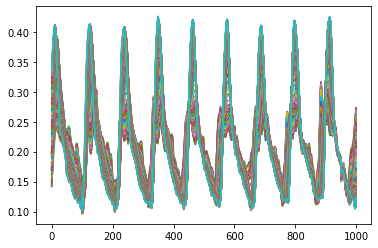

In [38]:
for i in range(100):
    plt.plot(ZtmpPred[i])

([<matplotlib.axis.XTick at 0x15902c35220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

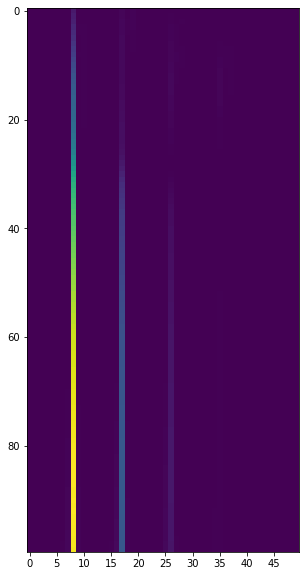

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(PSD)
plt.xticks(np.arange(0, 50, 5))


In [40]:
np.argmax(np.sum(PSD, axis=0))

8